In [1]:
#Data from https://www.kaggle.com/datasets/kapoorshivam/credit-analysis

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive/

/content/drive/MyDrive


In [3]:
import numpy as np
import pandas as pd
import keras
import sys
import tensorflow as tf

In [4]:
df = pd.read_csv('current_app.csv')

In [5]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
#Inspect columns
df.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np

class CustomPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()
        self.num_imputer = SimpleImputer(strategy='mean')
        self.cat_imputer = SimpleImputer(strategy='most_frequent')

        # Explicitly define columns
        self.categorical_columns = [
            'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
            'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN'
        ]
        self.numerical_columns = [
            'AMT_INCOME_TOTAL', 'AMT_CREDIT',
            'AMT_ANNUITY', 'AMT_GOODS_PRICE'
        ]

        # One LabelEncoder per categorical column
        self.label_encoders = {col: LabelEncoder() for col in self.categorical_columns}
        self.fitted = False

    def fit(self, X, y=None):
        X = X.copy()

        # Impute and scale numerical data
        self.num_imputer.fit(X[self.numerical_columns])
        X_num_imputed = pd.DataFrame(
            self.num_imputer.transform(X[self.numerical_columns]),
            columns=self.numerical_columns,
            index=X.index
        )
        self.scaler.fit(X_num_imputed)

        # Impute and label encode categorical data
        self.cat_imputer.fit(X[self.categorical_columns])
        X_cat_imputed = pd.DataFrame(
            self.cat_imputer.transform(X[self.categorical_columns]),
            columns=self.categorical_columns,
            index=X.index
        )
        for col in self.categorical_columns:
            self.label_encoders[col].fit(X_cat_imputed[col])

        self.fitted = True
        return self

    def transform(self, X):
        if not self.fitted:
            raise RuntimeError("You must fit the preprocessor before calling transform.")

        X = X.copy()

        # Impute and scale numerical data
        X_num_imputed = pd.DataFrame(
            self.num_imputer.transform(X[self.numerical_columns]),
            columns=self.numerical_columns,
            index=X.index
        )
        X_num_scaled = self.scaler.transform(X_num_imputed)

        # Impute and label encode categorical data
        X_cat_imputed = pd.DataFrame(
            self.cat_imputer.transform(X[self.categorical_columns]),
            columns=self.categorical_columns,
            index=X.index
        )
        X_cat_encoded = np.column_stack([
            self.label_encoders[col].transform(X_cat_imputed[col])
            for col in self.categorical_columns
        ])

        # Combine numerical and categorical
        X_processed = np.hstack([X_num_scaled, X_cat_encoded])
        return X_processed

In [8]:
#Preprocess
preprocessor = CustomPreprocessor()
X_transformed = preprocessor.fit_transform(df)

In [9]:
print(X_transformed.shape)

(307511, 10)


In [10]:
num_num = len(preprocessor.numerical_columns)
print("Numerical feature columns:", preprocessor.numerical_columns)

Numerical feature columns: ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']


In [11]:
cat_dims = [len(encoder.classes_) for encoder in preprocessor.label_encoders.values()]
print("Categorical features and label-encoded class counts:")
for col, dim in zip(preprocessor.categorical_columns, cat_dims):
    print(f"  {col}: {dim} unique labels")

print("Total features after transform:", len(preprocessor.numerical_columns) + len(cat_dims))

Categorical features and label-encoded class counts:
  TARGET: 2 unique labels
  NAME_CONTRACT_TYPE: 2 unique labels
  CODE_GENDER: 3 unique labels
  FLAG_OWN_CAR: 2 unique labels
  FLAG_OWN_REALTY: 2 unique labels
  CNT_CHILDREN: 15 unique labels
Total features after transform: 10


In [12]:
cat_dims = [len(le.classes_) for le in preprocessor.label_encoders.values()]
num_num = len(preprocessor.numerical_columns)

In [13]:
cat_dims

[2, 2, 3, 2, 2, 15]

In [14]:
#Wasserstein Autoencoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, Model, Input
import numpy as np

def build_encoder(input_dim, latent_dim, noise_stddev=0.1, dropout_rate=0.2, l2_reg=1e-4):
    inputs = keras.Input(shape=(input_dim,))
    x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(inputs)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.GaussianNoise(noise_stddev)(x) #Noise Injection
    z = layers.Dense(latent_dim)(x)
    return keras.Model(inputs, z, name="encoder")

def build_decoder(latent_dim, num_num, cat_dims, l2_reg=1e-4):
    inputs = keras.Input(shape=(latent_dim,))

    x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(inputs)
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)

    # Output for numerical features
    num_out = layers.Dense(num_num, name='numerical_output')(x)

    # Outputs for categorical features (each with softmax)
    cat_outs = []
    for i, dim in enumerate(cat_dims):
        cat_out = layers.Dense(dim, activation='softmax', name=f'cat_output_{i}')(x)
        cat_outs.append(cat_out)

    # Return as separate outputs
    return keras.Model(inputs, [num_out] + cat_outs, name="decoder")

def build_critic(latent_dim, l2_reg=1e-4):
    inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(inputs)
    x = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    out = layers.Dense(1)(x)  # Scalar output for Wasserstein score
    return keras.Model(inputs, out, name="critic")

In [19]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm

# === Setup data and params ===
X = X_transformed.astype(np.float32)  # Assume X_transformed is defined elsewhere
input_dim = X.shape[1]
latent_dim = 10

# Define models (should be tf.keras.Model instances)
encoder = build_encoder(input_dim, latent_dim)
decoder = build_decoder(latent_dim, num_num, cat_dims)
critic = build_critic(latent_dim)

# Optimizers
optimizer_gen = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5, beta_2=0.9)
optimizer_critic = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5, beta_2=0.9)

# Training parameters
batch_size = 256  # increased batch size
epochs = 40
critic_iters = 3  # reduced critic updates per gen update
lambda_gp = 10.0

# Create tf.data.Dataset with caching and prefetching
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

# Warm-up forward passes (optional, helps trigger model building)
_ = encoder(X[:1])
_ = decoder(tf.random.normal([1, latent_dim]))
_ = critic(tf.random.normal([1, latent_dim]))

@tf.function
def train_critic(batch_x):
    critic_loss = 0.0
    for _ in tf.range(critic_iters):
        with tf.GradientTape() as tape:
            z = encoder(batch_x)
            prior_z = tf.random.normal(shape=tf.shape(z), dtype=tf.float32)

            critic_z = critic(z)
            critic_prior = critic(prior_z)

            alpha = tf.random.uniform(shape=[tf.shape(z)[0], 1], dtype=tf.float32)
            interpolates = alpha * z + (1.0 - alpha) * prior_z

            with tf.GradientTape() as gp_tape:
                gp_tape.watch(interpolates)
                critic_interpolates = critic(interpolates)

            gradients = gp_tape.gradient(critic_interpolates, [interpolates])[0]
            slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=1) + 1e-12)
            gradient_penalty = tf.reduce_mean(tf.square(slopes - 1.0))

            loss = tf.reduce_mean(critic_z) - tf.reduce_mean(critic_prior)
            loss += lambda_gp * gradient_penalty

        grads = tape.gradient(loss, critic.trainable_variables)
        optimizer_critic.apply_gradients(zip(grads, critic.trainable_variables))
        critic_loss += loss
    return critic_loss / tf.cast(critic_iters, tf.float32)

@tf.function
def train_generator(batch_x):
    with tf.GradientTape() as tape:
        z = encoder(batch_x)
        outputs = decoder(z)
        critic_z = critic(z)

        # Split input: numerical and categorical
        x_num = batch_x[:, :num_num]
        x_cats = []
        start = num_num
        for _ in cat_dims:
            x_cats.append(tf.cast(batch_x[:, start], tf.int32))  # single column, label-encoded
            start += 1

        # Decoder outputs
        x_recon_num = outputs[0]
        x_recon_cats = outputs[1:]

        # Reconstruction losses
        recon_loss_num = tf.reduce_mean(tf.square(x_num - x_recon_num))
        recon_loss_cat = tf.add_n([
            tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(true, pred))
            for true, pred in zip(x_cats, x_recon_cats)
        ])
        recon_loss = recon_loss_num + recon_loss_cat

        # Generator loss with critic output added (your setup)
        gen_loss = recon_loss - tf.reduce_mean(critic_z)

    grads = tape.gradient(gen_loss, encoder.trainable_variables + decoder.trainable_variables)
    optimizer_gen.apply_gradients(zip(grads, encoder.trainable_variables + decoder.trainable_variables))
    return gen_loss

num_batches = tf.data.experimental.cardinality(dataset).numpy()

for epoch in range(epochs):
    epoch_gen_loss = []
    epoch_critic_loss = []

    print(f"\n=== Epoch {epoch+1}/{epochs} ===", flush=True)
    for batch_idx, batch_x in enumerate(tqdm(dataset, total=num_batches, desc=f"Epoch {epoch+1}")):
        batch_x = tf.cast(batch_x, tf.float32)

        # Check critic output means on prior and encoded samples (sign check)
        if batch_idx == 0:  # Only once per epoch to avoid clutter
            z_encoded = encoder(batch_x)
            z_prior = tf.random.normal(shape=tf.shape(z_encoded))
            mean_prior_score = tf.reduce_mean(critic(z_prior))
            mean_encoded_score = tf.reduce_mean(critic(z_encoded))
            print(f"Critic mean scores at epoch {epoch+1} — Prior: {mean_prior_score.numpy():.4f}, Encoded: {mean_encoded_score.numpy():.4f}")

        critic_loss = train_critic(batch_x)
        gen_loss = train_generator(batch_x)

        epoch_critic_loss.append(critic_loss.numpy())
        epoch_gen_loss.append(gen_loss.numpy())

        # Print every 50 batches to reduce overhead
        if (batch_idx + 1) % 50 == 0 or (batch_idx + 1) == num_batches:
            print(f"Batch {batch_idx + 1}/{num_batches}: Gen Loss = {gen_loss.numpy():.4f}, Critic Loss = {critic_loss.numpy():.4f}", flush=True)

    mean_g_loss = np.mean(epoch_gen_loss)
    mean_c_loss = np.mean(epoch_critic_loss)
    print(f"\n✔ Epoch {epoch+1}/{epochs} Complete | Avg Gen Loss: {mean_g_loss:.6f}, Avg Critic Loss: {mean_c_loss:.6f}", flush=True)


=== Epoch 1/40 ===


Epoch 1:   0%|          | 0/1202 [00:00<?, ?it/s]

Critic mean scores at epoch 1 — Prior: 0.2583, Encoded: 0.0240


Epoch 1:   4%|▍         | 49/1202 [00:04<00:33, 34.60it/s]

Batch 50/1202: Gen Loss = 7.0389, Critic Loss = 1.2744


Epoch 1:   8%|▊         | 98/1202 [00:05<00:20, 55.15it/s]

Batch 100/1202: Gen Loss = 6.6417, Critic Loss = -0.7771


Epoch 1:  12%|█▏        | 146/1202 [00:06<00:20, 52.66it/s]

Batch 150/1202: Gen Loss = 6.0039, Critic Loss = -1.4986


Epoch 1:  16%|█▋        | 197/1202 [00:07<00:14, 71.50it/s]

Batch 200/1202: Gen Loss = 5.2320, Critic Loss = -1.9693


Epoch 1:  20%|██        | 245/1202 [00:07<00:12, 76.25it/s]

Batch 250/1202: Gen Loss = 4.5654, Critic Loss = -2.2299


Epoch 1:  24%|██▍       | 293/1202 [00:08<00:11, 77.16it/s]

Batch 300/1202: Gen Loss = 3.9831, Critic Loss = -2.3970


Epoch 1:  29%|██▉       | 349/1202 [00:09<00:11, 75.99it/s]

Batch 350/1202: Gen Loss = 3.5594, Critic Loss = -2.4808


Epoch 1:  33%|███▎      | 397/1202 [00:09<00:10, 76.08it/s]

Batch 400/1202: Gen Loss = 2.9655, Critic Loss = -2.4506


Epoch 1:  37%|███▋      | 445/1202 [00:10<00:09, 76.14it/s]

Batch 450/1202: Gen Loss = 2.6758, Critic Loss = -2.4388


Epoch 1:  41%|████      | 493/1202 [00:11<00:09, 74.20it/s]

Batch 500/1202: Gen Loss = 2.1912, Critic Loss = -2.3818


Epoch 1:  46%|████▌     | 549/1202 [00:11<00:08, 76.47it/s]

Batch 550/1202: Gen Loss = 2.1047, Critic Loss = -2.2562


Epoch 1:  50%|████▉     | 597/1202 [00:12<00:07, 76.78it/s]

Batch 600/1202: Gen Loss = 1.5539, Critic Loss = -2.2322


Epoch 1:  54%|█████▎    | 645/1202 [00:13<00:07, 74.19it/s]

Batch 650/1202: Gen Loss = 1.2510, Critic Loss = -2.1062


Epoch 1:  58%|█████▊    | 693/1202 [00:13<00:06, 76.21it/s]

Batch 700/1202: Gen Loss = 0.9443, Critic Loss = -2.0915


Epoch 1:  62%|██████▏   | 749/1202 [00:14<00:05, 76.14it/s]

Batch 750/1202: Gen Loss = 0.6441, Critic Loss = -1.9905


Epoch 1:  66%|██████▋   | 797/1202 [00:15<00:05, 77.13it/s]

Batch 800/1202: Gen Loss = 0.5886, Critic Loss = -1.9063


Epoch 1:  70%|███████   | 845/1202 [00:15<00:04, 76.72it/s]

Batch 850/1202: Gen Loss = 0.3811, Critic Loss = -1.8510


Epoch 1:  74%|███████▍  | 893/1202 [00:16<00:04, 74.67it/s]

Batch 900/1202: Gen Loss = 0.0964, Critic Loss = -1.8207


Epoch 1:  79%|███████▊  | 946/1202 [00:17<00:04, 58.62it/s]

Batch 950/1202: Gen Loss = 0.0937, Critic Loss = -1.7520


Epoch 1:  83%|████████▎ | 994/1202 [00:18<00:03, 57.29it/s]

Batch 1000/1202: Gen Loss = 0.1905, Critic Loss = -1.6109


Epoch 1:  87%|████████▋ | 1049/1202 [00:19<00:02, 54.77it/s]

Batch 1050/1202: Gen Loss = 0.2028, Critic Loss = -1.5767


Epoch 1:  91%|█████████ | 1093/1202 [00:19<00:01, 57.96it/s]

Batch 1100/1202: Gen Loss = 0.1641, Critic Loss = -1.5925


Epoch 1:  96%|█████████▌| 1149/1202 [00:20<00:00, 72.36it/s]

Batch 1150/1202: Gen Loss = 0.1489, Critic Loss = -1.4717


Epoch 1: 100%|█████████▉| 1197/1202 [00:21<00:00, 76.45it/s]

Batch 1200/1202: Gen Loss = 0.0151, Critic Loss = -1.3824
Batch 1202/1202: Gen Loss = -0.2129, Critic Loss = -1.4193


Epoch 1: 100%|██████████| 1202/1202 [00:40<00:00, 29.35it/s]


✔ Epoch 1/40 Complete | Avg Gen Loss: 2.566537, Avg Critic Loss: -1.677681

=== Epoch 2/40 ===



Epoch 2:   1%|          | 7/1202 [00:00<00:18, 63.64it/s]

Critic mean scores at epoch 2 — Prior: 2.3722, Encoded: 0.6867


Epoch 2:   4%|▍         | 47/1202 [00:00<00:15, 76.74it/s]

Batch 50/1202: Gen Loss = 0.1123, Critic Loss = -1.2901


Epoch 2:   8%|▊         | 98/1202 [00:01<00:18, 59.40it/s]

Batch 100/1202: Gen Loss = -0.1183, Critic Loss = -1.3259


Epoch 2:  12%|█▏        | 146/1202 [00:02<00:18, 57.29it/s]

Batch 150/1202: Gen Loss = -0.1829, Critic Loss = -1.3453


Epoch 2:  16%|█▋        | 196/1202 [00:03<00:18, 54.26it/s]

Batch 200/1202: Gen Loss = -0.2536, Critic Loss = -1.4227


Epoch 2:  20%|██        | 242/1202 [00:03<00:14, 64.45it/s]

Batch 250/1202: Gen Loss = -0.2225, Critic Loss = -1.3059


Epoch 2:  25%|██▍       | 298/1202 [00:04<00:11, 75.73it/s]

Batch 300/1202: Gen Loss = -0.1140, Critic Loss = -1.1798


Epoch 2:  29%|██▉       | 346/1202 [00:05<00:11, 75.68it/s]

Batch 350/1202: Gen Loss = -0.1698, Critic Loss = -1.2385


Epoch 2:  33%|███▎      | 394/1202 [00:05<00:10, 77.67it/s]

Batch 400/1202: Gen Loss = -0.0419, Critic Loss = -1.2455


Epoch 2:  37%|███▋      | 442/1202 [00:06<00:09, 77.52it/s]

Batch 450/1202: Gen Loss = -0.1543, Critic Loss = -1.1838


Epoch 2:  41%|████▏     | 498/1202 [00:07<00:09, 76.16it/s]

Batch 500/1202: Gen Loss = -0.2958, Critic Loss = -1.1524


Epoch 2:  45%|████▌     | 546/1202 [00:07<00:08, 76.54it/s]

Batch 550/1202: Gen Loss = -0.0323, Critic Loss = -1.1522


Epoch 2:  50%|████▉     | 595/1202 [00:08<00:07, 76.71it/s]

Batch 600/1202: Gen Loss = 0.0681, Critic Loss = -1.2259


Epoch 2:  53%|█████▎    | 643/1202 [00:09<00:07, 78.10it/s]

Batch 650/1202: Gen Loss = -0.0433, Critic Loss = -1.0947


Epoch 2:  58%|█████▊    | 699/1202 [00:09<00:06, 77.00it/s]

Batch 700/1202: Gen Loss = -0.1024, Critic Loss = -1.0275


Epoch 2:  62%|██████▏   | 747/1202 [00:10<00:06, 75.18it/s]

Batch 750/1202: Gen Loss = 0.0334, Critic Loss = -0.9366


Epoch 2:  66%|██████▌   | 795/1202 [00:11<00:05, 76.80it/s]

Batch 800/1202: Gen Loss = 0.3012, Critic Loss = -1.0878


Epoch 2:  70%|███████   | 843/1202 [00:11<00:04, 76.37it/s]

Batch 850/1202: Gen Loss = 0.2253, Critic Loss = -1.0341


Epoch 2:  75%|███████▍  | 899/1202 [00:12<00:03, 76.51it/s]

Batch 900/1202: Gen Loss = -0.1859, Critic Loss = -0.8851


Epoch 2:  79%|███████▉  | 947/1202 [00:13<00:03, 77.53it/s]

Batch 950/1202: Gen Loss = -0.1145, Critic Loss = -0.9678


Epoch 2:  83%|████████▎ | 995/1202 [00:13<00:03, 66.95it/s]

Batch 1000/1202: Gen Loss = 0.0717, Critic Loss = -0.9829


Epoch 2:  87%|████████▋ | 1048/1202 [00:14<00:02, 57.94it/s]

Batch 1050/1202: Gen Loss = 0.3058, Critic Loss = -1.0181


Epoch 2:  91%|█████████ | 1096/1202 [00:15<00:01, 56.69it/s]

Batch 1100/1202: Gen Loss = 0.3328, Critic Loss = -1.1905


Epoch 2:  95%|█████████▌| 1145/1202 [00:16<00:01, 52.17it/s]

Batch 1150/1202: Gen Loss = 0.2263, Critic Loss = -1.0896


Epoch 2: 100%|█████████▉| 1196/1202 [00:17<00:00, 71.96it/s]

Batch 1200/1202: Gen Loss = -0.0511, Critic Loss = -1.0340
Batch 1202/1202: Gen Loss = -0.1076, Critic Loss = -1.0216


Epoch 2: 100%|██████████| 1202/1202 [00:17<00:00, 68.91it/s]


✔ Epoch 2/40 Complete | Avg Gen Loss: 0.152935, Avg Critic Loss: -1.148471

=== Epoch 3/40 ===



Epoch 3:   0%|          | 5/1202 [00:00<00:24, 48.50it/s]

Critic mean scores at epoch 3 — Prior: 1.3610, Encoded: 0.2899


Epoch 3:   4%|▎         | 44/1202 [00:00<00:15, 73.72it/s]

Batch 50/1202: Gen Loss = 0.2028, Critic Loss = -1.0264


Epoch 3:   8%|▊         | 92/1202 [00:01<00:14, 74.31it/s]

Batch 100/1202: Gen Loss = 0.0511, Critic Loss = -1.1490


Epoch 3:  12%|█▏        | 148/1202 [00:01<00:13, 77.88it/s]

Batch 150/1202: Gen Loss = 0.2559, Critic Loss = -1.1198


Epoch 3:  16%|█▋        | 196/1202 [00:02<00:13, 76.68it/s]

Batch 200/1202: Gen Loss = 0.1778, Critic Loss = -1.0897


Epoch 3:  20%|██        | 244/1202 [00:03<00:12, 77.63it/s]

Batch 250/1202: Gen Loss = 0.0659, Critic Loss = -1.0513


Epoch 3:  24%|██▍       | 292/1202 [00:03<00:11, 76.77it/s]

Batch 300/1202: Gen Loss = 0.0868, Critic Loss = -0.9970


Epoch 3:  29%|██▉       | 348/1202 [00:04<00:11, 75.64it/s]

Batch 350/1202: Gen Loss = 0.0412, Critic Loss = -1.0122


Epoch 3:  33%|███▎      | 396/1202 [00:05<00:10, 77.10it/s]

Batch 400/1202: Gen Loss = 0.1936, Critic Loss = -0.9346


Epoch 3:  37%|███▋      | 444/1202 [00:05<00:09, 76.68it/s]

Batch 450/1202: Gen Loss = 0.0367, Critic Loss = -0.8360


Epoch 3:  41%|████      | 492/1202 [00:06<00:09, 75.12it/s]

Batch 500/1202: Gen Loss = -0.2518, Critic Loss = -0.7972


Epoch 3:  46%|████▌     | 548/1202 [00:07<00:08, 77.97it/s]

Batch 550/1202: Gen Loss = 0.0033, Critic Loss = -0.8951


Epoch 3:  50%|████▉     | 596/1202 [00:07<00:07, 77.13it/s]

Batch 600/1202: Gen Loss = -0.3310, Critic Loss = -0.9115


Epoch 3:  54%|█████▎    | 644/1202 [00:08<00:07, 74.50it/s]

Batch 650/1202: Gen Loss = -0.3961, Critic Loss = -0.8384


Epoch 3:  58%|█████▊    | 692/1202 [00:09<00:06, 77.24it/s]

Batch 700/1202: Gen Loss = -0.3261, Critic Loss = -0.8083


Epoch 3:  62%|██████▏   | 746/1202 [00:09<00:07, 60.07it/s]

Batch 750/1202: Gen Loss = -0.1178, Critic Loss = -0.8574


Epoch 3:  66%|██████▋   | 798/1202 [00:10<00:06, 58.79it/s]

Batch 800/1202: Gen Loss = 0.2453, Critic Loss = -0.9532


Epoch 3:  70%|███████   | 847/1202 [00:11<00:06, 53.60it/s]

Batch 850/1202: Gen Loss = 0.2174, Critic Loss = -0.9274


Epoch 3:  75%|███████▍  | 897/1202 [00:12<00:05, 59.61it/s]

Batch 900/1202: Gen Loss = 0.0363, Critic Loss = -0.9178


Epoch 3:  79%|███████▊  | 944/1202 [00:13<00:03, 73.73it/s]

Batch 950/1202: Gen Loss = -0.1421, Critic Loss = -0.7130


Epoch 3:  83%|████████▎ | 992/1202 [00:13<00:02, 75.27it/s]

Batch 1000/1202: Gen Loss = -0.1329, Critic Loss = -0.7928


Epoch 3:  87%|████████▋ | 1048/1202 [00:14<00:02, 75.78it/s]

Batch 1050/1202: Gen Loss = 0.2596, Critic Loss = -0.8437


Epoch 3:  91%|█████████ | 1096/1202 [00:15<00:01, 77.23it/s]

Batch 1100/1202: Gen Loss = 0.5342, Critic Loss = -0.9008


Epoch 3:  95%|█████████▌| 1144/1202 [00:15<00:00, 75.67it/s]

Batch 1150/1202: Gen Loss = 0.4195, Critic Loss = -0.7653


Epoch 3:  99%|█████████▉| 1192/1202 [00:16<00:00, 76.73it/s]

Batch 1200/1202: Gen Loss = -0.0632, Critic Loss = -0.5169


Epoch 3: 100%|█████████▉| 1200/1202 [00:16<00:00, 76.77it/s]

Batch 1202/1202: Gen Loss = -0.0571, Critic Loss = -0.6006


Epoch 3: 100%|██████████| 1202/1202 [00:16<00:00, 72.16it/s]


✔ Epoch 3/40 Complete | Avg Gen Loss: 0.152163, Avg Critic Loss: -0.926619

=== Epoch 4/40 ===



Epoch 4:   1%|          | 7/1202 [00:00<00:17, 67.12it/s]

Critic mean scores at epoch 4 — Prior: 0.9008, Encoded: 0.1654


Epoch 4:   4%|▍         | 46/1202 [00:00<00:15, 76.35it/s]

Batch 50/1202: Gen Loss = 0.1573, Critic Loss = -0.4739


Epoch 4:   8%|▊         | 94/1202 [00:01<00:15, 71.44it/s]

Batch 100/1202: Gen Loss = -0.1757, Critic Loss = -0.6604


Epoch 4:  12%|█▏        | 142/1202 [00:01<00:14, 75.59it/s]

Batch 150/1202: Gen Loss = -0.1344, Critic Loss = -0.7311


Epoch 4:  16%|█▋        | 198/1202 [00:02<00:13, 76.18it/s]

Batch 200/1202: Gen Loss = -0.1404, Critic Loss = -0.8226


Epoch 4:  20%|██        | 246/1202 [00:03<00:12, 75.03it/s]

Batch 250/1202: Gen Loss = -0.3562, Critic Loss = -0.5526


Epoch 4:  24%|██▍       | 294/1202 [00:03<00:11, 77.71it/s]

Batch 300/1202: Gen Loss = -0.6137, Critic Loss = -0.4287


Epoch 4:  28%|██▊       | 342/1202 [00:04<00:11, 75.91it/s]

Batch 350/1202: Gen Loss = -0.5572, Critic Loss = -0.4121


Epoch 4:  33%|███▎      | 398/1202 [00:05<00:10, 76.68it/s]

Batch 400/1202: Gen Loss = 0.3921, Critic Loss = -0.8007


Epoch 4:  37%|███▋      | 446/1202 [00:05<00:10, 71.92it/s]

Batch 450/1202: Gen Loss = 1.3179, Critic Loss = -1.0452


Epoch 4:  41%|████      | 494/1202 [00:06<00:12, 57.41it/s]

Batch 500/1202: Gen Loss = 1.3919, Critic Loss = -0.8349


Epoch 4:  45%|████▌     | 544/1202 [00:07<00:11, 56.55it/s]

Batch 550/1202: Gen Loss = 1.3925, Critic Loss = -0.5991


Epoch 4:  50%|████▉     | 599/1202 [00:08<00:11, 51.79it/s]

Batch 600/1202: Gen Loss = 0.8612, Critic Loss = -0.5519


Epoch 4:  54%|█████▍    | 649/1202 [00:09<00:07, 70.01it/s]

Batch 650/1202: Gen Loss = 0.5820, Critic Loss = -0.7252


Epoch 4:  58%|█████▊    | 697/1202 [00:10<00:06, 75.57it/s]

Batch 700/1202: Gen Loss = 0.5102, Critic Loss = -0.8251


Epoch 4:  62%|██████▏   | 745/1202 [00:10<00:06, 75.82it/s]

Batch 750/1202: Gen Loss = 0.3684, Critic Loss = -0.9161


Epoch 4:  66%|██████▌   | 793/1202 [00:11<00:05, 77.79it/s]

Batch 800/1202: Gen Loss = 0.2780, Critic Loss = -0.6998


Epoch 4:  71%|███████   | 849/1202 [00:12<00:04, 76.99it/s]

Batch 850/1202: Gen Loss = 0.2971, Critic Loss = -0.6187


Epoch 4:  75%|███████▍  | 897/1202 [00:12<00:04, 74.00it/s]

Batch 900/1202: Gen Loss = 0.5215, Critic Loss = -0.6795


Epoch 4:  79%|███████▊  | 945/1202 [00:13<00:03, 78.04it/s]

Batch 950/1202: Gen Loss = 0.7767, Critic Loss = -0.8331


Epoch 4:  83%|████████▎ | 993/1202 [00:13<00:02, 74.18it/s]

Batch 1000/1202: Gen Loss = 0.5577, Critic Loss = -0.6233


Epoch 4:  87%|████████▋ | 1049/1202 [00:14<00:01, 77.64it/s]

Batch 1050/1202: Gen Loss = 0.3718, Critic Loss = -0.5807


Epoch 4:  91%|█████████▏| 1097/1202 [00:15<00:01, 77.42it/s]

Batch 1100/1202: Gen Loss = 0.4697, Critic Loss = -0.6647


Epoch 4:  95%|█████████▌| 1145/1202 [00:15<00:00, 75.50it/s]

Batch 1150/1202: Gen Loss = 0.5222, Critic Loss = -0.7356


Epoch 4:  99%|█████████▉| 1193/1202 [00:16<00:00, 78.19it/s]

Batch 1200/1202: Gen Loss = 0.8698, Critic Loss = -1.0799


Epoch 4: 100%|█████████▉| 1201/1202 [00:16<00:00, 77.74it/s]

Batch 1202/1202: Gen Loss = 0.9030, Critic Loss = -1.0435


Epoch 4: 100%|██████████| 1202/1202 [00:16<00:00, 72.09it/s]


✔ Epoch 4/40 Complete | Avg Gen Loss: 0.413372, Avg Critic Loss: -0.675102

=== Epoch 5/40 ===



Epoch 5:   1%|          | 7/1202 [00:00<00:20, 58.68it/s]

Critic mean scores at epoch 5 — Prior: 0.5138, Encoded: -0.7553


Epoch 5:   4%|▍         | 47/1202 [00:00<00:15, 76.74it/s]

Batch 50/1202: Gen Loss = 1.5651, Critic Loss = -1.1797


Epoch 5:   8%|▊         | 95/1202 [00:01<00:14, 76.16it/s]

Batch 100/1202: Gen Loss = 0.9552, Critic Loss = -0.9935


Epoch 5:  12%|█▏        | 144/1202 [00:01<00:13, 77.50it/s]

Batch 150/1202: Gen Loss = 0.6980, Critic Loss = -0.7162


Epoch 5:  16%|█▋        | 198/1202 [00:02<00:16, 61.86it/s]

Batch 200/1202: Gen Loss = 1.2419, Critic Loss = -0.8430


Epoch 5:  21%|██        | 249/1202 [00:03<00:16, 58.80it/s]

Batch 250/1202: Gen Loss = 1.3085, Critic Loss = -0.7751


Epoch 5:  25%|██▍       | 297/1202 [00:04<00:16, 55.67it/s]

Batch 300/1202: Gen Loss = 1.2219, Critic Loss = -0.6824


Epoch 5:  29%|██▊       | 345/1202 [00:05<00:16, 51.95it/s]

Batch 350/1202: Gen Loss = 1.1060, Critic Loss = -0.7608


Epoch 5:  33%|███▎      | 392/1202 [00:06<00:11, 73.58it/s]

Batch 400/1202: Gen Loss = 1.1165, Critic Loss = -0.7841


Epoch 5:  37%|███▋      | 448/1202 [00:06<00:09, 76.63it/s]

Batch 450/1202: Gen Loss = 1.2763, Critic Loss = -0.7851


Epoch 5:  41%|████▏     | 496/1202 [00:07<00:09, 77.02it/s]

Batch 500/1202: Gen Loss = 1.3853, Critic Loss = -0.7686


Epoch 5:  45%|████▌     | 544/1202 [00:07<00:08, 77.03it/s]

Batch 550/1202: Gen Loss = 2.1693, Critic Loss = -0.8608


Epoch 5:  49%|████▉     | 592/1202 [00:08<00:08, 75.76it/s]

Batch 600/1202: Gen Loss = 2.4556, Critic Loss = -0.9588


Epoch 5:  54%|█████▍    | 648/1202 [00:09<00:07, 76.61it/s]

Batch 650/1202: Gen Loss = 2.0988, Critic Loss = -0.8256


Epoch 5:  58%|█████▊    | 696/1202 [00:09<00:06, 76.66it/s]

Batch 700/1202: Gen Loss = 2.0405, Critic Loss = -0.8192


Epoch 5:  62%|██████▏   | 744/1202 [00:10<00:06, 75.83it/s]

Batch 750/1202: Gen Loss = 1.8886, Critic Loss = -0.7152


Epoch 5:  66%|██████▌   | 792/1202 [00:11<00:05, 75.97it/s]

Batch 800/1202: Gen Loss = 1.9713, Critic Loss = -0.8707


Epoch 5:  71%|███████   | 848/1202 [00:11<00:04, 77.47it/s]

Batch 850/1202: Gen Loss = 1.8346, Critic Loss = -0.7527


Epoch 5:  75%|███████▍  | 896/1202 [00:12<00:04, 75.60it/s]

Batch 900/1202: Gen Loss = 2.1608, Critic Loss = -0.8144


Epoch 5:  79%|███████▊  | 944/1202 [00:13<00:03, 76.46it/s]

Batch 950/1202: Gen Loss = 2.5786, Critic Loss = -0.9085


Epoch 5:  83%|████████▎ | 992/1202 [00:13<00:02, 75.98it/s]

Batch 1000/1202: Gen Loss = 2.5424, Critic Loss = -0.9739


Epoch 5:  87%|████████▋ | 1048/1202 [00:14<00:02, 75.67it/s]

Batch 1050/1202: Gen Loss = 2.3066, Critic Loss = -0.7448


Epoch 5:  91%|█████████ | 1096/1202 [00:15<00:01, 75.71it/s]

Batch 1100/1202: Gen Loss = 1.9799, Critic Loss = -0.7059


Epoch 5:  96%|█████████▌| 1148/1202 [00:16<00:00, 59.73it/s]

Batch 1150/1202: Gen Loss = 1.8454, Critic Loss = -0.8327


Epoch 5: 100%|█████████▉| 1198/1202 [00:16<00:00, 56.55it/s]

Batch 1200/1202: Gen Loss = 1.8343, Critic Loss = -0.8475
Batch 1202/1202: Gen Loss = 1.8232, Critic Loss = -0.8666


Epoch 5: 100%|██████████| 1202/1202 [00:17<00:00, 70.40it/s]


✔ Epoch 5/40 Complete | Avg Gen Loss: 1.706569, Avg Critic Loss: -0.830113

=== Epoch 6/40 ===



Epoch 6:   0%|          | 5/1202 [00:00<00:25, 46.41it/s]

Critic mean scores at epoch 6 — Prior: -0.7041, Encoded: -1.7184


Epoch 6:   4%|▍         | 47/1202 [00:00<00:21, 53.55it/s]

Batch 50/1202: Gen Loss = 2.3981, Critic Loss = -0.7568


Epoch 6:   8%|▊         | 92/1202 [00:01<00:18, 61.42it/s]

Batch 100/1202: Gen Loss = 2.6021, Critic Loss = -0.7593


Epoch 6:  12%|█▏        | 147/1202 [00:02<00:14, 74.30it/s]

Batch 150/1202: Gen Loss = 2.8006, Critic Loss = -0.8986


Epoch 6:  16%|█▌        | 195/1202 [00:03<00:13, 73.16it/s]

Batch 200/1202: Gen Loss = 2.5734, Critic Loss = -0.7669


Epoch 6:  20%|██        | 243/1202 [00:03<00:12, 76.68it/s]

Batch 250/1202: Gen Loss = 2.5282, Critic Loss = -0.8646


Epoch 6:  25%|██▍       | 299/1202 [00:04<00:11, 75.99it/s]

Batch 300/1202: Gen Loss = 2.2273, Critic Loss = -0.7341


Epoch 6:  29%|██▉       | 347/1202 [00:05<00:11, 73.32it/s]

Batch 350/1202: Gen Loss = 2.3160, Critic Loss = -0.6418


Epoch 6:  33%|███▎      | 395/1202 [00:05<00:10, 76.07it/s]

Batch 400/1202: Gen Loss = 2.9664, Critic Loss = -0.7411


Epoch 6:  37%|███▋      | 443/1202 [00:06<00:10, 74.82it/s]

Batch 450/1202: Gen Loss = 3.4292, Critic Loss = -0.9218


Epoch 6:  42%|████▏     | 499/1202 [00:07<00:09, 73.68it/s]

Batch 500/1202: Gen Loss = 3.1928, Critic Loss = -0.7516


Epoch 6:  46%|████▌     | 547/1202 [00:07<00:08, 74.36it/s]

Batch 550/1202: Gen Loss = 3.2763, Critic Loss = -0.8218


Epoch 6:  50%|████▉     | 595/1202 [00:08<00:08, 75.12it/s]

Batch 600/1202: Gen Loss = 2.9941, Critic Loss = -0.8784


Epoch 6:  53%|█████▎    | 643/1202 [00:09<00:07, 75.64it/s]

Batch 650/1202: Gen Loss = 2.9527, Critic Loss = -0.7787


Epoch 6:  58%|█████▊    | 699/1202 [00:09<00:06, 76.13it/s]

Batch 700/1202: Gen Loss = 3.3463, Critic Loss = -0.6603


Epoch 6:  62%|██████▏   | 747/1202 [00:10<00:06, 73.98it/s]

Batch 750/1202: Gen Loss = 3.7123, Critic Loss = -0.7794


Epoch 6:  66%|██████▌   | 795/1202 [00:11<00:05, 73.64it/s]

Batch 800/1202: Gen Loss = 3.6846, Critic Loss = -0.6274


Epoch 6:  71%|███████   | 849/1202 [00:11<00:05, 60.68it/s]

Batch 850/1202: Gen Loss = 3.7707, Critic Loss = -0.6857


Epoch 6:  75%|███████▍  | 898/1202 [00:12<00:05, 55.69it/s]

Batch 900/1202: Gen Loss = 3.7741, Critic Loss = -0.6706


Epoch 6:  79%|███████▉  | 949/1202 [00:13<00:04, 58.52it/s]

Batch 950/1202: Gen Loss = 3.9521, Critic Loss = -0.6692


Epoch 6:  83%|████████▎ | 997/1202 [00:14<00:03, 53.43it/s]

Batch 1000/1202: Gen Loss = 4.0357, Critic Loss = -0.4994


Epoch 6:  87%|████████▋ | 1044/1202 [00:15<00:02, 73.45it/s]

Batch 1050/1202: Gen Loss = 4.3589, Critic Loss = -0.6121


Epoch 6:  91%|█████████ | 1092/1202 [00:15<00:01, 75.76it/s]

Batch 1100/1202: Gen Loss = 4.3491, Critic Loss = -0.6968


Epoch 6:  96%|█████████▌| 1148/1202 [00:16<00:00, 75.97it/s]

Batch 1150/1202: Gen Loss = 4.3090, Critic Loss = -0.6424


Epoch 6: 100%|█████████▉| 1196/1202 [00:17<00:00, 76.26it/s]

Batch 1200/1202: Gen Loss = 4.4561, Critic Loss = -0.7181
Batch 1202/1202: Gen Loss = 4.4644, Critic Loss = -0.6676


Epoch 6: 100%|██████████| 1202/1202 [00:17<00:00, 69.34it/s]


✔ Epoch 6/40 Complete | Avg Gen Loss: 3.279387, Avg Critic Loss: -0.739992

=== Epoch 7/40 ===



Epoch 7:   1%|          | 7/1202 [00:00<00:20, 59.12it/s]

Critic mean scores at epoch 7 — Prior: -3.4032, Encoded: -4.3772


Epoch 7:   4%|▍         | 47/1202 [00:00<00:15, 75.41it/s]

Batch 50/1202: Gen Loss = 5.0331, Critic Loss = -0.7199


Epoch 7:   8%|▊         | 95/1202 [00:01<00:14, 74.63it/s]

Batch 100/1202: Gen Loss = 4.7591, Critic Loss = -0.7226


Epoch 7:  12%|█▏        | 143/1202 [00:01<00:13, 75.71it/s]

Batch 150/1202: Gen Loss = 4.8246, Critic Loss = -0.7804


Epoch 7:  17%|█▋        | 199/1202 [00:02<00:13, 76.02it/s]

Batch 200/1202: Gen Loss = 4.7689, Critic Loss = -0.7061


Epoch 7:  21%|██        | 247/1202 [00:03<00:12, 73.56it/s]

Batch 250/1202: Gen Loss = 4.6540, Critic Loss = -0.6366


Epoch 7:  25%|██▍       | 295/1202 [00:03<00:11, 75.98it/s]

Batch 300/1202: Gen Loss = 4.7836, Critic Loss = -0.6496


Epoch 7:  29%|██▊       | 343/1202 [00:04<00:11, 74.93it/s]

Batch 350/1202: Gen Loss = 4.8650, Critic Loss = -0.6745


Epoch 7:  33%|███▎      | 399/1202 [00:05<00:10, 74.48it/s]

Batch 400/1202: Gen Loss = 4.9818, Critic Loss = -0.6826


Epoch 7:  37%|███▋      | 447/1202 [00:05<00:09, 76.38it/s]

Batch 450/1202: Gen Loss = 5.2383, Critic Loss = -0.8095


Epoch 7:  41%|████      | 495/1202 [00:06<00:09, 75.68it/s]

Batch 500/1202: Gen Loss = 5.2521, Critic Loss = -0.8146


Epoch 7:  45%|████▌     | 543/1202 [00:07<00:08, 76.48it/s]

Batch 550/1202: Gen Loss = 5.3938, Critic Loss = -0.8086


Epoch 7:  50%|████▉     | 599/1202 [00:08<00:10, 57.63it/s]

Batch 600/1202: Gen Loss = 5.2712, Critic Loss = -0.6982


Epoch 7:  54%|█████▍    | 647/1202 [00:09<00:09, 57.81it/s]

Batch 650/1202: Gen Loss = 5.2594, Critic Loss = -0.6857


Epoch 7:  58%|█████▊    | 695/1202 [00:09<00:09, 54.19it/s]

Batch 700/1202: Gen Loss = 5.5134, Critic Loss = -0.7338


Epoch 7:  62%|██████▏   | 749/1202 [00:10<00:06, 67.77it/s]

Batch 750/1202: Gen Loss = 5.5361, Critic Loss = -0.7088


Epoch 7:  66%|██████▋   | 797/1202 [00:11<00:05, 76.04it/s]

Batch 800/1202: Gen Loss = 5.5251, Critic Loss = -0.7701


Epoch 7:  70%|███████   | 845/1202 [00:12<00:04, 76.54it/s]

Batch 850/1202: Gen Loss = 5.5550, Critic Loss = -0.7894


Epoch 7:  74%|███████▍  | 893/1202 [00:12<00:04, 73.94it/s]

Batch 900/1202: Gen Loss = 5.5777, Critic Loss = -0.8033


Epoch 7:  79%|███████▉  | 949/1202 [00:13<00:03, 72.26it/s]

Batch 950/1202: Gen Loss = 5.5619, Critic Loss = -0.7979


Epoch 7:  83%|████████▎ | 997/1202 [00:14<00:02, 75.03it/s]

Batch 1000/1202: Gen Loss = 5.5621, Critic Loss = -0.7726


Epoch 7:  87%|████████▋ | 1045/1202 [00:14<00:02, 73.99it/s]

Batch 1050/1202: Gen Loss = 5.6249, Critic Loss = -0.7094


Epoch 7:  91%|█████████ | 1093/1202 [00:15<00:01, 77.26it/s]

Batch 1100/1202: Gen Loss = 5.5745, Critic Loss = -0.8077


Epoch 7:  96%|█████████▌| 1149/1202 [00:16<00:00, 75.44it/s]

Batch 1150/1202: Gen Loss = 5.4477, Critic Loss = -0.7324


Epoch 7: 100%|█████████▉| 1197/1202 [00:16<00:00, 76.72it/s]

Batch 1200/1202: Gen Loss = 5.4898, Critic Loss = -0.7577
Batch 1202/1202: Gen Loss = 5.3827, Critic Loss = -0.5400


Epoch 7: 100%|██████████| 1202/1202 [00:16<00:00, 71.48it/s]


✔ Epoch 7/40 Complete | Avg Gen Loss: 5.240301, Avg Critic Loss: -0.739011

=== Epoch 8/40 ===



Epoch 8:   1%|          | 7/1202 [00:00<00:18, 65.62it/s]

Critic mean scores at epoch 8 — Prior: -4.4813, Encoded: -5.4251


Epoch 8:   4%|▍         | 47/1202 [00:00<00:15, 76.58it/s]

Batch 50/1202: Gen Loss = 5.9490, Critic Loss = -0.7189


Epoch 8:   8%|▊         | 95/1202 [00:01<00:14, 74.70it/s]

Batch 100/1202: Gen Loss = 5.7021, Critic Loss = -0.7380


Epoch 8:  12%|█▏        | 143/1202 [00:01<00:14, 75.22it/s]

Batch 150/1202: Gen Loss = 5.8320, Critic Loss = -0.8144


Epoch 8:  17%|█▋        | 199/1202 [00:02<00:13, 76.79it/s]

Batch 200/1202: Gen Loss = 5.9403, Critic Loss = -0.7458


Epoch 8:  21%|██        | 247/1202 [00:03<00:12, 75.24it/s]

Batch 250/1202: Gen Loss = 5.9775, Critic Loss = -0.6551


Epoch 8:  24%|██▍       | 294/1202 [00:04<00:14, 62.33it/s]

Batch 300/1202: Gen Loss = 6.1621, Critic Loss = -0.6998


Epoch 8:  29%|██▉       | 349/1202 [00:04<00:14, 57.92it/s]

Batch 350/1202: Gen Loss = 6.4003, Critic Loss = -0.6723


Epoch 8:  33%|███▎      | 398/1202 [00:05<00:14, 53.88it/s]

Batch 400/1202: Gen Loss = 6.6719, Critic Loss = -0.7643


Epoch 8:  37%|███▋      | 446/1202 [00:06<00:14, 53.14it/s]

Batch 450/1202: Gen Loss = 6.7330, Critic Loss = -0.7287


Epoch 8:  41%|████      | 494/1202 [00:07<00:09, 72.47it/s]

Batch 500/1202: Gen Loss = 6.9322, Critic Loss = -0.8209


Epoch 8:  45%|████▌     | 542/1202 [00:08<00:08, 76.22it/s]

Batch 550/1202: Gen Loss = 7.1017, Critic Loss = -0.8287


Epoch 8:  50%|████▉     | 598/1202 [00:08<00:07, 76.46it/s]

Batch 600/1202: Gen Loss = 7.0065, Critic Loss = -0.8469


Epoch 8:  54%|█████▎    | 646/1202 [00:09<00:07, 75.56it/s]

Batch 650/1202: Gen Loss = 6.9047, Critic Loss = -0.7599


Epoch 8:  58%|█████▊    | 694/1202 [00:10<00:06, 75.43it/s]

Batch 700/1202: Gen Loss = 6.9962, Critic Loss = -0.7847


Epoch 8:  62%|██████▏   | 742/1202 [00:10<00:06, 73.77it/s]

Batch 750/1202: Gen Loss = 6.9626, Critic Loss = -0.7449


Epoch 8:  66%|██████▋   | 798/1202 [00:11<00:05, 76.44it/s]

Batch 800/1202: Gen Loss = 7.0370, Critic Loss = -0.7426


Epoch 8:  70%|███████   | 846/1202 [00:12<00:04, 75.78it/s]

Batch 850/1202: Gen Loss = 7.0113, Critic Loss = -0.7021


Epoch 8:  74%|███████▍  | 894/1202 [00:12<00:04, 75.01it/s]

Batch 900/1202: Gen Loss = 7.0779, Critic Loss = -0.7843


Epoch 8:  78%|███████▊  | 942/1202 [00:13<00:03, 77.34it/s]

Batch 950/1202: Gen Loss = 7.1841, Critic Loss = -0.8420


Epoch 8:  83%|████████▎ | 997/1202 [00:14<00:02, 69.10it/s]

Batch 1000/1202: Gen Loss = 7.3043, Critic Loss = -0.7482


Epoch 8:  87%|████████▋ | 1045/1202 [00:14<00:02, 73.35it/s]

Batch 1050/1202: Gen Loss = 7.4648, Critic Loss = -0.7659


Epoch 8:  91%|█████████ | 1093/1202 [00:15<00:01, 76.53it/s]

Batch 1100/1202: Gen Loss = 7.3392, Critic Loss = -0.7560


Epoch 8:  96%|█████████▌| 1149/1202 [00:16<00:00, 75.91it/s]

Batch 1150/1202: Gen Loss = 7.5228, Critic Loss = -0.7485


Epoch 8: 100%|█████████▉| 1197/1202 [00:16<00:00, 75.06it/s]

Batch 1200/1202: Gen Loss = 7.4078, Critic Loss = -0.7271
Batch 1202/1202: Gen Loss = 7.3887, Critic Loss = -0.7592


Epoch 8: 100%|██████████| 1202/1202 [00:16<00:00, 71.41it/s]


✔ Epoch 8/40 Complete | Avg Gen Loss: 6.751526, Avg Critic Loss: -0.769267

=== Epoch 9/40 ===



Epoch 9:   0%|          | 4/1202 [00:00<00:31, 38.18it/s]

Critic mean scores at epoch 9 — Prior: -6.2909, Encoded: -7.3853


Epoch 9:   4%|▍         | 46/1202 [00:00<00:20, 57.43it/s]

Batch 50/1202: Gen Loss = 7.9370, Critic Loss = -0.7649


Epoch 9:   8%|▊         | 94/1202 [00:01<00:19, 57.24it/s]

Batch 100/1202: Gen Loss = 7.4829, Critic Loss = -0.8150


Epoch 9:  12%|█▏        | 148/1202 [00:02<00:18, 55.91it/s]

Batch 150/1202: Gen Loss = 7.4282, Critic Loss = -0.7468


Epoch 9:  16%|█▋        | 196/1202 [00:03<00:14, 67.16it/s]

Batch 200/1202: Gen Loss = 7.6613, Critic Loss = -0.8366


Epoch 9:  20%|██        | 244/1202 [00:04<00:13, 72.45it/s]

Batch 250/1202: Gen Loss = 7.6573, Critic Loss = -0.6926


Epoch 9:  24%|██▍       | 292/1202 [00:04<00:11, 76.85it/s]

Batch 300/1202: Gen Loss = 7.8942, Critic Loss = -0.6896


Epoch 9:  29%|██▉       | 348/1202 [00:05<00:11, 74.81it/s]

Batch 350/1202: Gen Loss = 8.1568, Critic Loss = -0.7663


Epoch 9:  33%|███▎      | 396/1202 [00:06<00:10, 75.61it/s]

Batch 400/1202: Gen Loss = 8.3098, Critic Loss = -0.8396


Epoch 9:  37%|███▋      | 444/1202 [00:06<00:09, 76.30it/s]

Batch 450/1202: Gen Loss = 8.1253, Critic Loss = -0.7298


Epoch 9:  41%|████      | 492/1202 [00:07<00:09, 75.72it/s]

Batch 500/1202: Gen Loss = 8.1449, Critic Loss = -0.8797


Epoch 9:  46%|████▌     | 548/1202 [00:08<00:08, 77.34it/s]

Batch 550/1202: Gen Loss = 8.1226, Critic Loss = -0.7788


Epoch 9:  50%|████▉     | 596/1202 [00:08<00:07, 76.90it/s]

Batch 600/1202: Gen Loss = 8.0324, Critic Loss = -0.8562


Epoch 9:  54%|█████▎    | 644/1202 [00:09<00:07, 74.98it/s]

Batch 650/1202: Gen Loss = 7.9697, Critic Loss = -0.7435


Epoch 9:  58%|█████▊    | 692/1202 [00:09<00:06, 76.98it/s]

Batch 700/1202: Gen Loss = 8.0970, Critic Loss = -0.8433


Epoch 9:  62%|██████▏   | 748/1202 [00:10<00:05, 77.12it/s]

Batch 750/1202: Gen Loss = 8.0906, Critic Loss = -0.7892


Epoch 9:  66%|██████▌   | 796/1202 [00:11<00:05, 74.95it/s]

Batch 800/1202: Gen Loss = 8.3293, Critic Loss = -0.7467


Epoch 9:  70%|███████   | 844/1202 [00:11<00:04, 77.20it/s]

Batch 850/1202: Gen Loss = 8.1482, Critic Loss = -0.7325


Epoch 9:  74%|███████▍  | 892/1202 [00:12<00:04, 76.19it/s]

Batch 900/1202: Gen Loss = 8.0961, Critic Loss = -0.7837


Epoch 9:  79%|███████▉  | 947/1202 [00:13<00:04, 59.13it/s]

Batch 950/1202: Gen Loss = 7.8847, Critic Loss = -0.7531


Epoch 9:  83%|████████▎ | 997/1202 [00:14<00:03, 58.08it/s]

Batch 1000/1202: Gen Loss = 7.8875, Critic Loss = -0.7645


Epoch 9:  87%|████████▋ | 1045/1202 [00:15<00:02, 56.69it/s]

Batch 1050/1202: Gen Loss = 8.2262, Critic Loss = -0.7213


Epoch 9:  91%|█████████▏| 1099/1202 [00:16<00:01, 51.81it/s]

Batch 1100/1202: Gen Loss = 8.4461, Critic Loss = -0.7972


Epoch 9:  95%|█████████▌| 1145/1202 [00:16<00:00, 71.90it/s]

Batch 1150/1202: Gen Loss = 8.4660, Critic Loss = -0.7869


Epoch 9:  99%|█████████▉| 1193/1202 [00:17<00:00, 76.69it/s]

Batch 1200/1202: Gen Loss = 8.6160, Critic Loss = -0.7705


Epoch 9: 100%|█████████▉| 1201/1202 [00:17<00:00, 71.71it/s]

Batch 1202/1202: Gen Loss = 8.6980, Critic Loss = -0.7762


Epoch 9: 100%|██████████| 1202/1202 [00:17<00:00, 68.21it/s]


✔ Epoch 9/40 Complete | Avg Gen Loss: 8.035524, Avg Critic Loss: -0.773399

=== Epoch 10/40 ===



Epoch 10:   1%|          | 7/1202 [00:00<00:18, 66.15it/s]

Critic mean scores at epoch 10 — Prior: -7.6411, Encoded: -8.5694


Epoch 10:   4%|▍         | 47/1202 [00:00<00:15, 75.68it/s]

Batch 50/1202: Gen Loss = 9.2978, Critic Loss = -0.7680


Epoch 10:   8%|▊         | 95/1202 [00:01<00:14, 75.07it/s]

Batch 100/1202: Gen Loss = 8.9196, Critic Loss = -0.7814


Epoch 10:  12%|█▏        | 143/1202 [00:01<00:14, 74.54it/s]

Batch 150/1202: Gen Loss = 8.8962, Critic Loss = -0.8014


Epoch 10:  17%|█▋        | 199/1202 [00:02<00:13, 75.63it/s]

Batch 200/1202: Gen Loss = 8.9510, Critic Loss = -0.7381


Epoch 10:  21%|██        | 247/1202 [00:03<00:12, 75.26it/s]

Batch 250/1202: Gen Loss = 8.8910, Critic Loss = -0.7302


Epoch 10:  25%|██▍       | 295/1202 [00:03<00:11, 76.97it/s]

Batch 300/1202: Gen Loss = 9.0020, Critic Loss = -0.7269


Epoch 10:  29%|██▊       | 343/1202 [00:04<00:11, 75.32it/s]

Batch 350/1202: Gen Loss = 9.0590, Critic Loss = -0.6766


Epoch 10:  33%|███▎      | 399/1202 [00:05<00:10, 74.48it/s]

Batch 400/1202: Gen Loss = 9.1174, Critic Loss = -0.7441


Epoch 10:  37%|███▋      | 447/1202 [00:05<00:09, 76.46it/s]

Batch 450/1202: Gen Loss = 8.9559, Critic Loss = -0.6886


Epoch 10:  41%|████      | 495/1202 [00:06<00:09, 74.59it/s]

Batch 500/1202: Gen Loss = 8.9207, Critic Loss = -0.7279


Epoch 10:  45%|████▌     | 543/1202 [00:07<00:08, 74.36it/s]

Batch 550/1202: Gen Loss = 8.8189, Critic Loss = -0.7396


Epoch 10:  50%|████▉     | 599/1202 [00:07<00:07, 76.57it/s]

Batch 600/1202: Gen Loss = 8.6562, Critic Loss = -0.7221


Epoch 10:  54%|█████▍    | 647/1202 [00:08<00:07, 72.39it/s]

Batch 650/1202: Gen Loss = 8.6770, Critic Loss = -0.6466


Epoch 10:  58%|█████▊    | 695/1202 [00:09<00:09, 56.18it/s]

Batch 700/1202: Gen Loss = 8.7827, Critic Loss = -0.6425


Epoch 10:  62%|██████▏   | 744/1202 [00:10<00:08, 56.49it/s]

Batch 750/1202: Gen Loss = 8.7535, Critic Loss = -0.6092


Epoch 10:  66%|██████▋   | 798/1202 [00:11<00:07, 53.49it/s]

Batch 800/1202: Gen Loss = 9.0692, Critic Loss = -0.6536


Epoch 10:  71%|███████   | 848/1202 [00:12<00:05, 69.55it/s]

Batch 850/1202: Gen Loss = 9.0506, Critic Loss = -0.6825


Epoch 10:  75%|███████▍  | 896/1202 [00:12<00:04, 74.63it/s]

Batch 900/1202: Gen Loss = 9.0411, Critic Loss = -0.6880


Epoch 10:  79%|███████▊  | 944/1202 [00:13<00:03, 77.06it/s]

Batch 950/1202: Gen Loss = 9.1097, Critic Loss = -0.7277


Epoch 10:  83%|████████▎ | 992/1202 [00:14<00:02, 76.72it/s]

Batch 1000/1202: Gen Loss = 9.0224, Critic Loss = -0.6132


Epoch 10:  87%|████████▋ | 1048/1202 [00:14<00:02, 76.19it/s]

Batch 1050/1202: Gen Loss = 9.0641, Critic Loss = -0.5351


Epoch 10:  91%|█████████ | 1096/1202 [00:15<00:01, 77.25it/s]

Batch 1100/1202: Gen Loss = 9.0918, Critic Loss = -0.6960


Epoch 10:  95%|█████████▌| 1144/1202 [00:16<00:00, 74.73it/s]

Batch 1150/1202: Gen Loss = 9.1054, Critic Loss = -0.5984


Epoch 10:  99%|█████████▉| 1192/1202 [00:16<00:00, 72.96it/s]

Batch 1200/1202: Gen Loss = 8.9860, Critic Loss = -0.6146


Epoch 10: 100%|█████████▉| 1200/1202 [00:16<00:00, 73.59it/s]

Batch 1202/1202: Gen Loss = 9.0487, Critic Loss = -0.5844


Epoch 10: 100%|██████████| 1202/1202 [00:16<00:00, 71.24it/s]


✔ Epoch 10/40 Complete | Avg Gen Loss: 8.977899, Avg Critic Loss: -0.693135

=== Epoch 11/40 ===



Epoch 11:   1%|          | 7/1202 [00:00<00:18, 64.14it/s]

Critic mean scores at epoch 11 — Prior: -8.0658, Encoded: -8.9661


Epoch 11:   4%|▍         | 47/1202 [00:00<00:15, 76.44it/s]

Batch 50/1202: Gen Loss = 9.5620, Critic Loss = -0.6159


Epoch 11:   8%|▊         | 95/1202 [00:01<00:14, 76.14it/s]

Batch 100/1202: Gen Loss = 9.1106, Critic Loss = -0.6118


Epoch 11:  12%|█▏        | 143/1202 [00:01<00:14, 72.96it/s]

Batch 150/1202: Gen Loss = 8.9754, Critic Loss = -0.6288


Epoch 11:  17%|█▋        | 199/1202 [00:02<00:13, 76.93it/s]

Batch 200/1202: Gen Loss = 9.0275, Critic Loss = -0.7055


Epoch 11:  21%|██        | 247/1202 [00:03<00:12, 75.81it/s]

Batch 250/1202: Gen Loss = 9.0501, Critic Loss = -0.6306


Epoch 11:  25%|██▍       | 295/1202 [00:03<00:12, 74.54it/s]

Batch 300/1202: Gen Loss = 9.1069, Critic Loss = -0.6064


Epoch 11:  29%|██▊       | 343/1202 [00:04<00:11, 75.75it/s]

Batch 350/1202: Gen Loss = 9.2641, Critic Loss = -0.6278


Epoch 11:  33%|███▎      | 396/1202 [00:05<00:13, 60.05it/s]

Batch 400/1202: Gen Loss = 9.3351, Critic Loss = -0.6596


Epoch 11:  37%|███▋      | 446/1202 [00:06<00:12, 58.50it/s]

Batch 450/1202: Gen Loss = 9.2919, Critic Loss = -0.6332


Epoch 11:  41%|████      | 495/1202 [00:07<00:12, 58.42it/s]

Batch 500/1202: Gen Loss = 9.3870, Critic Loss = -0.7017


Epoch 11:  45%|████▌     | 543/1202 [00:08<00:12, 52.73it/s]

Batch 550/1202: Gen Loss = 9.4911, Critic Loss = -0.6682


Epoch 11:  50%|████▉     | 598/1202 [00:08<00:08, 73.92it/s]

Batch 600/1202: Gen Loss = 9.2491, Critic Loss = -0.6274


Epoch 11:  54%|█████▎    | 646/1202 [00:09<00:07, 74.14it/s]

Batch 650/1202: Gen Loss = 9.2446, Critic Loss = -0.6330


Epoch 11:  58%|█████▊    | 694/1202 [00:10<00:06, 76.01it/s]

Batch 700/1202: Gen Loss = 9.2513, Critic Loss = -0.6436


Epoch 11:  62%|██████▏   | 742/1202 [00:10<00:06, 73.57it/s]

Batch 750/1202: Gen Loss = 9.2306, Critic Loss = -0.6876


Epoch 11:  66%|██████▋   | 798/1202 [00:11<00:05, 73.57it/s]

Batch 800/1202: Gen Loss = 9.2210, Critic Loss = -0.6349


Epoch 11:  70%|███████   | 846/1202 [00:12<00:04, 75.67it/s]

Batch 850/1202: Gen Loss = 9.0968, Critic Loss = -0.7179


Epoch 11:  74%|███████▍  | 894/1202 [00:12<00:04, 75.79it/s]

Batch 900/1202: Gen Loss = 9.0537, Critic Loss = -0.5783


Epoch 11:  78%|███████▊  | 942/1202 [00:13<00:03, 73.64it/s]

Batch 950/1202: Gen Loss = 9.0610, Critic Loss = -0.6729


Epoch 11:  83%|████████▎ | 998/1202 [00:14<00:02, 75.81it/s]

Batch 1000/1202: Gen Loss = 9.0977, Critic Loss = -0.6406


Epoch 11:  87%|████████▋ | 1046/1202 [00:14<00:02, 72.04it/s]

Batch 1050/1202: Gen Loss = 9.1454, Critic Loss = -0.5775


Epoch 11:  91%|█████████ | 1094/1202 [00:15<00:01, 73.89it/s]

Batch 1100/1202: Gen Loss = 9.1325, Critic Loss = -0.6569


Epoch 11:  95%|█████████▌| 1142/1202 [00:16<00:00, 76.34it/s]

Batch 1150/1202: Gen Loss = 9.0168, Critic Loss = -0.6744


Epoch 11: 100%|█████████▉| 1198/1202 [00:16<00:00, 75.48it/s]

Batch 1200/1202: Gen Loss = 9.0122, Critic Loss = -0.6727
Batch 1202/1202: Gen Loss = 9.0450, Critic Loss = -0.5920


Epoch 11: 100%|██████████| 1202/1202 [00:16<00:00, 71.27it/s]


✔ Epoch 11/40 Complete | Avg Gen Loss: 9.215291, Avg Critic Loss: -0.648790

=== Epoch 12/40 ===



Epoch 12:   1%|          | 7/1202 [00:00<00:18, 64.18it/s]

Critic mean scores at epoch 12 — Prior: -8.0924, Encoded: -8.9621


Epoch 12:   4%|▍         | 47/1202 [00:00<00:15, 73.40it/s]

Batch 50/1202: Gen Loss = 9.5603, Critic Loss = -0.6168


Epoch 12:   8%|▊         | 95/1202 [00:01<00:16, 68.45it/s]

Batch 100/1202: Gen Loss = 9.0278, Critic Loss = -0.6313


Epoch 12:  12%|█▏        | 146/1202 [00:02<00:18, 57.44it/s]

Batch 150/1202: Gen Loss = 8.8566, Critic Loss = -0.6864


Epoch 12:  16%|█▌        | 194/1202 [00:03<00:18, 55.78it/s]

Batch 200/1202: Gen Loss = 8.6548, Critic Loss = -0.6656


Epoch 12:  20%|██        | 244/1202 [00:03<00:17, 54.86it/s]

Batch 250/1202: Gen Loss = 8.5716, Critic Loss = -0.6633


Epoch 12:  24%|██▍       | 293/1202 [00:04<00:13, 69.51it/s]

Batch 300/1202: Gen Loss = 8.5270, Critic Loss = -0.5715


Epoch 12:  29%|██▉       | 349/1202 [00:05<00:11, 75.74it/s]

Batch 350/1202: Gen Loss = 8.5870, Critic Loss = -0.5612


Epoch 12:  33%|███▎      | 397/1202 [00:06<00:10, 75.19it/s]

Batch 400/1202: Gen Loss = 8.5948, Critic Loss = -0.6352


Epoch 12:  37%|███▋      | 445/1202 [00:06<00:09, 76.45it/s]

Batch 450/1202: Gen Loss = 8.4577, Critic Loss = -0.5226


Epoch 12:  41%|████      | 493/1202 [00:07<00:09, 76.50it/s]

Batch 500/1202: Gen Loss = 8.4938, Critic Loss = -0.6379


Epoch 12:  46%|████▌     | 549/1202 [00:08<00:08, 74.44it/s]

Batch 550/1202: Gen Loss = 8.7286, Critic Loss = -0.6800


Epoch 12:  50%|████▉     | 597/1202 [00:08<00:08, 75.05it/s]

Batch 600/1202: Gen Loss = 8.3991, Critic Loss = -0.5596


Epoch 12:  54%|█████▎    | 645/1202 [00:09<00:07, 76.39it/s]

Batch 650/1202: Gen Loss = 8.3584, Critic Loss = -0.5529


Epoch 12:  58%|█████▊    | 693/1202 [00:10<00:06, 74.22it/s]

Batch 700/1202: Gen Loss = 8.3411, Critic Loss = -0.4974


Epoch 12:  62%|██████▏   | 749/1202 [00:10<00:05, 76.63it/s]

Batch 750/1202: Gen Loss = 8.4133, Critic Loss = -0.5312


Epoch 12:  66%|██████▋   | 797/1202 [00:11<00:05, 75.96it/s]

Batch 800/1202: Gen Loss = 8.8002, Critic Loss = -0.5507


Epoch 12:  70%|███████   | 845/1202 [00:12<00:04, 73.47it/s]

Batch 850/1202: Gen Loss = 8.9289, Critic Loss = -0.5582


Epoch 12:  74%|███████▍  | 893/1202 [00:12<00:04, 75.66it/s]

Batch 900/1202: Gen Loss = 9.0206, Critic Loss = -0.5380


Epoch 12:  79%|███████▉  | 949/1202 [00:13<00:03, 75.75it/s]

Batch 950/1202: Gen Loss = 9.1704, Critic Loss = -0.5888


Epoch 12:  83%|████████▎ | 997/1202 [00:14<00:02, 72.33it/s]

Batch 1000/1202: Gen Loss = 9.3064, Critic Loss = -0.5570


Epoch 12:  87%|████████▋ | 1048/1202 [00:14<00:02, 58.65it/s]

Batch 1050/1202: Gen Loss = 9.2961, Critic Loss = -0.5383


Epoch 12:  91%|█████████ | 1096/1202 [00:15<00:01, 56.10it/s]

Batch 1100/1202: Gen Loss = 9.2287, Critic Loss = -0.5698


Epoch 12:  95%|█████████▌| 1146/1202 [00:16<00:00, 57.33it/s]

Batch 1150/1202: Gen Loss = 9.2899, Critic Loss = -0.5986


Epoch 12:  99%|█████████▉| 1195/1202 [00:17<00:00, 57.14it/s]

Batch 1200/1202: Gen Loss = 9.3348, Critic Loss = -0.5865
Batch 1202/1202: Gen Loss = 9.3716, Critic Loss = -0.5937


Epoch 12: 100%|██████████| 1202/1202 [00:17<00:00, 67.88it/s]


✔ Epoch 12/40 Complete | Avg Gen Loss: 8.840038, Avg Critic Loss: -0.586119

=== Epoch 13/40 ===



Epoch 13:   1%|          | 7/1202 [00:00<00:18, 62.93it/s]

Critic mean scores at epoch 13 — Prior: -8.5169, Encoded: -9.2606


Epoch 13:   4%|▍         | 47/1202 [00:00<00:15, 72.36it/s]

Batch 50/1202: Gen Loss = 10.0027, Critic Loss = -0.5519


Epoch 13:   8%|▊         | 95/1202 [00:01<00:14, 75.06it/s]

Batch 100/1202: Gen Loss = 9.5287, Critic Loss = -0.4779


Epoch 13:  12%|█▏        | 143/1202 [00:01<00:14, 74.46it/s]

Batch 150/1202: Gen Loss = 9.5667, Critic Loss = -0.5994


Epoch 13:  17%|█▋        | 199/1202 [00:02<00:13, 76.22it/s]

Batch 200/1202: Gen Loss = 9.5040, Critic Loss = -0.5528


Epoch 13:  21%|██        | 247/1202 [00:03<00:12, 76.28it/s]

Batch 250/1202: Gen Loss = 9.4659, Critic Loss = -0.5794


Epoch 13:  25%|██▍       | 295/1202 [00:03<00:11, 75.63it/s]

Batch 300/1202: Gen Loss = 9.4159, Critic Loss = -0.5481


Epoch 13:  29%|██▊       | 343/1202 [00:04<00:11, 76.76it/s]

Batch 350/1202: Gen Loss = 9.5563, Critic Loss = -0.5712


Epoch 13:  33%|███▎      | 399/1202 [00:05<00:10, 76.33it/s]

Batch 400/1202: Gen Loss = 9.5290, Critic Loss = -0.5822


Epoch 13:  37%|███▋      | 447/1202 [00:05<00:10, 74.27it/s]

Batch 450/1202: Gen Loss = 9.4694, Critic Loss = -0.5536


Epoch 13:  41%|████      | 495/1202 [00:06<00:09, 76.01it/s]

Batch 500/1202: Gen Loss = 9.5149, Critic Loss = -0.6020


Epoch 13:  45%|████▌     | 543/1202 [00:07<00:08, 75.30it/s]

Batch 550/1202: Gen Loss = 9.8474, Critic Loss = -0.6399


Epoch 13:  50%|████▉     | 599/1202 [00:07<00:08, 73.50it/s]

Batch 600/1202: Gen Loss = 9.7158, Critic Loss = -0.5829


Epoch 13:  54%|█████▍    | 647/1202 [00:08<00:07, 72.89it/s]

Batch 650/1202: Gen Loss = 9.6305, Critic Loss = -0.5735


Epoch 13:  58%|█████▊    | 695/1202 [00:09<00:06, 73.63it/s]

Batch 700/1202: Gen Loss = 9.5179, Critic Loss = -0.5661


Epoch 13:  62%|██████▏   | 743/1202 [00:10<00:07, 64.48it/s]

Batch 750/1202: Gen Loss = 9.5285, Critic Loss = -0.5805


Epoch 13:  66%|██████▌   | 794/1202 [00:10<00:07, 55.22it/s]

Batch 800/1202: Gen Loss = 9.6632, Critic Loss = -0.6226


Epoch 13:  71%|███████   | 848/1202 [00:11<00:06, 55.69it/s]

Batch 850/1202: Gen Loss = 9.5654, Critic Loss = -0.5430


Epoch 13:  75%|███████▍  | 896/1202 [00:12<00:05, 52.94it/s]

Batch 900/1202: Gen Loss = 9.5565, Critic Loss = -0.6331


Epoch 13:  79%|███████▉  | 947/1202 [00:13<00:03, 70.49it/s]

Batch 950/1202: Gen Loss = 9.5827, Critic Loss = -0.7209


Epoch 13:  83%|████████▎ | 995/1202 [00:14<00:02, 73.94it/s]

Batch 1000/1202: Gen Loss = 9.4945, Critic Loss = -0.5313


Epoch 13:  87%|████████▋ | 1043/1202 [00:14<00:02, 74.99it/s]

Batch 1050/1202: Gen Loss = 9.5446, Critic Loss = -0.5509


Epoch 13:  91%|█████████▏| 1099/1202 [00:15<00:01, 74.96it/s]

Batch 1100/1202: Gen Loss = 9.5193, Critic Loss = -0.6401


Epoch 13:  95%|█████████▌| 1147/1202 [00:16<00:00, 76.08it/s]

Batch 1150/1202: Gen Loss = 9.5420, Critic Loss = -0.5685


Epoch 13:  99%|█████████▉| 1195/1202 [00:16<00:00, 76.10it/s]

Batch 1200/1202: Gen Loss = 9.5771, Critic Loss = -0.5950
Batch 1202/1202: Gen Loss = 9.6409, Critic Loss = -0.6031


Epoch 13: 100%|██████████| 1202/1202 [00:17<00:00, 70.60it/s]


✔ Epoch 13/40 Complete | Avg Gen Loss: 9.580438, Avg Critic Loss: -0.594069

=== Epoch 14/40 ===



Epoch 14:   1%|          | 7/1202 [00:00<00:18, 63.22it/s]

Critic mean scores at epoch 14 — Prior: -8.6582, Encoded: -9.4349


Epoch 14:   4%|▍         | 47/1202 [00:00<00:15, 74.05it/s]

Batch 50/1202: Gen Loss = 10.1706, Critic Loss = -0.5314


Epoch 14:   8%|▊         | 95/1202 [00:01<00:14, 76.20it/s]

Batch 100/1202: Gen Loss = 9.5563, Critic Loss = -0.5037


Epoch 14:  12%|█▏        | 143/1202 [00:01<00:13, 76.08it/s]

Batch 150/1202: Gen Loss = 9.5187, Critic Loss = -0.5551


Epoch 14:  17%|█▋        | 199/1202 [00:02<00:13, 75.23it/s]

Batch 200/1202: Gen Loss = 9.4947, Critic Loss = -0.5462


Epoch 14:  21%|██        | 247/1202 [00:03<00:12, 76.17it/s]

Batch 250/1202: Gen Loss = 9.3968, Critic Loss = -0.4978


Epoch 14:  25%|██▍       | 295/1202 [00:03<00:11, 75.66it/s]

Batch 300/1202: Gen Loss = 9.3201, Critic Loss = -0.4318


Epoch 14:  29%|██▊       | 343/1202 [00:04<00:11, 74.82it/s]

Batch 350/1202: Gen Loss = 9.3574, Critic Loss = -0.4833


Epoch 14:  33%|███▎      | 399/1202 [00:05<00:10, 76.93it/s]

Batch 400/1202: Gen Loss = 9.2951, Critic Loss = -0.4832


Epoch 14:  37%|███▋      | 447/1202 [00:05<00:09, 76.31it/s]

Batch 450/1202: Gen Loss = 9.2662, Critic Loss = -0.4263


Epoch 14:  41%|████▏     | 496/1202 [00:06<00:12, 55.54it/s]

Batch 500/1202: Gen Loss = 9.5018, Critic Loss = -0.4712


Epoch 14:  45%|████▌     | 544/1202 [00:07<00:12, 54.23it/s]

Batch 550/1202: Gen Loss = 9.6520, Critic Loss = -0.5482


Epoch 14:  50%|████▉     | 599/1202 [00:08<00:11, 52.98it/s]

Batch 600/1202: Gen Loss = 9.5011, Critic Loss = -0.4709


Epoch 14:  54%|█████▎    | 645/1202 [00:09<00:08, 64.61it/s]

Batch 650/1202: Gen Loss = 9.4914, Critic Loss = -0.4659


Epoch 14:  58%|█████▊    | 693/1202 [00:10<00:06, 73.53it/s]

Batch 700/1202: Gen Loss = 9.5288, Critic Loss = -0.4522


Epoch 14:  62%|██████▏   | 749/1202 [00:10<00:06, 74.36it/s]

Batch 750/1202: Gen Loss = 9.6357, Critic Loss = -0.5029


Epoch 14:  66%|██████▋   | 797/1202 [00:11<00:05, 75.97it/s]

Batch 800/1202: Gen Loss = 9.7173, Critic Loss = -0.5390


Epoch 14:  70%|███████   | 845/1202 [00:12<00:04, 72.45it/s]

Batch 850/1202: Gen Loss = 9.6443, Critic Loss = -0.5299


Epoch 14:  74%|███████▍  | 893/1202 [00:12<00:04, 74.96it/s]

Batch 900/1202: Gen Loss = 9.6411, Critic Loss = -0.4730


Epoch 14:  79%|███████▉  | 949/1202 [00:13<00:03, 74.70it/s]

Batch 950/1202: Gen Loss = 9.6537, Critic Loss = -0.4733


Epoch 14:  83%|████████▎ | 997/1202 [00:14<00:02, 73.05it/s]

Batch 1000/1202: Gen Loss = 9.7095, Critic Loss = -0.4181


Epoch 14:  87%|████████▋ | 1045/1202 [00:14<00:02, 74.92it/s]

Batch 1050/1202: Gen Loss = 9.8201, Critic Loss = -0.3880


Epoch 14:  91%|█████████ | 1093/1202 [00:15<00:01, 73.77it/s]

Batch 1100/1202: Gen Loss = 9.9339, Critic Loss = -0.5047


Epoch 14:  96%|█████████▌| 1149/1202 [00:16<00:00, 73.97it/s]

Batch 1150/1202: Gen Loss = 9.9742, Critic Loss = -0.4683


Epoch 14: 100%|█████████▉| 1197/1202 [00:16<00:00, 76.93it/s]

Batch 1200/1202: Gen Loss = 9.9688, Critic Loss = -0.4600
Batch 1202/1202: Gen Loss = 9.9683, Critic Loss = -0.5027


Epoch 14: 100%|██████████| 1202/1202 [00:16<00:00, 70.78it/s]


✔ Epoch 14/40 Complete | Avg Gen Loss: 9.620240, Avg Critic Loss: -0.504404

=== Epoch 15/40 ===



Epoch 15:   0%|          | 5/1202 [00:00<00:24, 48.38it/s]

Critic mean scores at epoch 15 — Prior: -9.1869, Encoded: -9.8706


Epoch 15:   4%|▎         | 45/1202 [00:00<00:15, 74.48it/s]

Batch 50/1202: Gen Loss = 10.4787, Critic Loss = -0.4211


Epoch 15:   8%|▊         | 93/1202 [00:01<00:14, 74.00it/s]

Batch 100/1202: Gen Loss = 10.0573, Critic Loss = -0.4328


Epoch 15:  12%|█▏        | 149/1202 [00:02<00:13, 75.54it/s]

Batch 150/1202: Gen Loss = 10.1293, Critic Loss = -0.4172


Epoch 15:  16%|█▌        | 194/1202 [00:02<00:16, 60.34it/s]

Batch 200/1202: Gen Loss = 10.0761, Critic Loss = -0.4818


Epoch 15:  20%|██        | 245/1202 [00:03<00:16, 58.89it/s]

Batch 250/1202: Gen Loss = 10.0575, Critic Loss = -0.4019


Epoch 15:  25%|██▍       | 299/1202 [00:04<00:16, 55.56it/s]

Batch 300/1202: Gen Loss = 10.0112, Critic Loss = -0.3411


Epoch 15:  29%|██▉       | 346/1202 [00:05<00:16, 51.87it/s]

Batch 350/1202: Gen Loss = 10.1058, Critic Loss = -0.4844


Epoch 15:  33%|███▎      | 394/1202 [00:06<00:11, 73.08it/s]

Batch 400/1202: Gen Loss = 10.0905, Critic Loss = -0.4148


Epoch 15:  37%|███▋      | 442/1202 [00:06<00:10, 73.53it/s]

Batch 450/1202: Gen Loss = 10.1980, Critic Loss = -0.3754


Epoch 15:  41%|████▏     | 496/1202 [00:07<00:14, 49.61it/s]

Batch 500/1202: Gen Loss = 10.1137, Critic Loss = -0.3571


Epoch 15:  46%|████▌     | 548/1202 [00:08<00:09, 70.74it/s]

Batch 550/1202: Gen Loss = 10.2845, Critic Loss = -0.4347


Epoch 15:  50%|████▉     | 596/1202 [00:09<00:08, 74.92it/s]

Batch 600/1202: Gen Loss = 10.0928, Critic Loss = -0.4341


Epoch 15:  54%|█████▎    | 644/1202 [00:09<00:07, 74.61it/s]

Batch 650/1202: Gen Loss = 10.0391, Critic Loss = -0.4083


Epoch 15:  58%|█████▊    | 692/1202 [00:10<00:06, 73.56it/s]

Batch 700/1202: Gen Loss = 10.0455, Critic Loss = -0.4110


Epoch 15:  62%|██████▏   | 748/1202 [00:11<00:05, 75.77it/s]

Batch 750/1202: Gen Loss = 9.9483, Critic Loss = -0.3397


Epoch 15:  66%|██████▌   | 796/1202 [00:11<00:05, 75.89it/s]

Batch 800/1202: Gen Loss = 10.0909, Critic Loss = -0.3875


Epoch 15:  70%|███████   | 844/1202 [00:12<00:04, 73.27it/s]

Batch 850/1202: Gen Loss = 10.0040, Critic Loss = -0.4013


Epoch 15:  74%|███████▍  | 892/1202 [00:13<00:04, 74.98it/s]

Batch 900/1202: Gen Loss = 10.0401, Critic Loss = -0.4436


Epoch 15:  79%|███████▉  | 948/1202 [00:13<00:03, 75.82it/s]

Batch 950/1202: Gen Loss = 10.0869, Critic Loss = -0.4282


Epoch 15:  83%|████████▎ | 996/1202 [00:14<00:02, 73.96it/s]

Batch 1000/1202: Gen Loss = 10.0445, Critic Loss = -0.3679


Epoch 15:  87%|████████▋ | 1044/1202 [00:15<00:02, 75.84it/s]

Batch 1050/1202: Gen Loss = 10.0026, Critic Loss = -0.3456


Epoch 15:  91%|█████████ | 1095/1202 [00:16<00:01, 57.49it/s]

Batch 1100/1202: Gen Loss = 9.9482, Critic Loss = -0.4388


Epoch 15:  95%|█████████▌| 1144/1202 [00:17<00:01, 56.71it/s]

Batch 1150/1202: Gen Loss = 10.0242, Critic Loss = -0.4224


Epoch 15: 100%|█████████▉| 1198/1202 [00:17<00:00, 54.26it/s]

Batch 1200/1202: Gen Loss = 9.9864, Critic Loss = -0.4219
Batch 1202/1202: Gen Loss = 9.9955, Critic Loss = -0.3699


Epoch 15: 100%|██████████| 1202/1202 [00:18<00:00, 66.59it/s]


✔ Epoch 15/40 Complete | Avg Gen Loss: 10.086072, Avg Critic Loss: -0.424151

=== Epoch 16/40 ===



Epoch 16:   0%|          | 4/1202 [00:00<00:31, 38.26it/s]

Critic mean scores at epoch 16 — Prior: -9.2692, Encoded: -9.8800


Epoch 16:   4%|▍         | 49/1202 [00:00<00:18, 61.84it/s]

Batch 50/1202: Gen Loss = 10.5079, Critic Loss = -0.3848


Epoch 16:   8%|▊         | 97/1202 [00:01<00:14, 74.41it/s]

Batch 100/1202: Gen Loss = 10.0834, Critic Loss = -0.3869


Epoch 16:  12%|█▏        | 145/1202 [00:02<00:14, 73.50it/s]

Batch 150/1202: Gen Loss = 10.1173, Critic Loss = -0.4987


Epoch 16:  16%|█▌        | 193/1202 [00:02<00:13, 75.17it/s]

Batch 200/1202: Gen Loss = 10.0351, Critic Loss = -0.4808


Epoch 16:  21%|██        | 249/1202 [00:03<00:12, 75.72it/s]

Batch 250/1202: Gen Loss = 9.9443, Critic Loss = -0.4281


Epoch 16:  25%|██▍       | 297/1202 [00:04<00:12, 75.12it/s]

Batch 300/1202: Gen Loss = 9.8739, Critic Loss = -0.3297


Epoch 16:  29%|██▊       | 345/1202 [00:04<00:11, 75.18it/s]

Batch 350/1202: Gen Loss = 10.0025, Critic Loss = -0.4695


Epoch 16:  33%|███▎      | 393/1202 [00:05<00:10, 75.73it/s]

Batch 400/1202: Gen Loss = 9.9863, Critic Loss = -0.4235


Epoch 16:  37%|███▋      | 449/1202 [00:06<00:09, 75.96it/s]

Batch 450/1202: Gen Loss = 9.9147, Critic Loss = -0.3591


Epoch 16:  41%|████▏     | 497/1202 [00:06<00:09, 76.11it/s]

Batch 500/1202: Gen Loss = 9.9716, Critic Loss = -0.3685


Epoch 16:  45%|████▌     | 545/1202 [00:07<00:08, 75.86it/s]

Batch 550/1202: Gen Loss = 10.1167, Critic Loss = -0.4321


Epoch 16:  49%|████▉     | 593/1202 [00:08<00:08, 72.97it/s]

Batch 600/1202: Gen Loss = 9.9546, Critic Loss = -0.4374


Epoch 16:  54%|█████▍    | 649/1202 [00:08<00:07, 74.66it/s]

Batch 650/1202: Gen Loss = 9.9564, Critic Loss = -0.3962


Epoch 16:  58%|█████▊    | 697/1202 [00:09<00:06, 74.66it/s]

Batch 700/1202: Gen Loss = 9.9664, Critic Loss = -0.4032


Epoch 16:  62%|██████▏   | 745/1202 [00:10<00:06, 74.07it/s]

Batch 750/1202: Gen Loss = 9.8822, Critic Loss = -0.3955


Epoch 16:  66%|██████▋   | 799/1202 [00:11<00:06, 61.39it/s]

Batch 800/1202: Gen Loss = 10.0909, Critic Loss = -0.4091


Epoch 16:  71%|███████   | 849/1202 [00:11<00:06, 58.50it/s]

Batch 850/1202: Gen Loss = 10.0048, Critic Loss = -0.3772


Epoch 16:  75%|███████▍  | 898/1202 [00:12<00:05, 57.48it/s]

Batch 900/1202: Gen Loss = 9.9904, Critic Loss = -0.4083


Epoch 16:  79%|███████▊  | 946/1202 [00:13<00:04, 53.49it/s]

Batch 950/1202: Gen Loss = 9.9993, Critic Loss = -0.4640


Epoch 16:  83%|████████▎ | 997/1202 [00:14<00:02, 70.18it/s]

Batch 1000/1202: Gen Loss = 10.0843, Critic Loss = -0.3929


Epoch 16:  87%|████████▋ | 1045/1202 [00:15<00:02, 75.35it/s]

Batch 1050/1202: Gen Loss = 10.1119, Critic Loss = -0.3739


Epoch 16:  91%|█████████ | 1093/1202 [00:15<00:01, 73.64it/s]

Batch 1100/1202: Gen Loss = 10.0528, Critic Loss = -0.3788


Epoch 16:  96%|█████████▌| 1149/1202 [00:16<00:00, 73.63it/s]

Batch 1150/1202: Gen Loss = 10.2482, Critic Loss = -0.4621


Epoch 16: 100%|█████████▉| 1197/1202 [00:17<00:00, 74.96it/s]

Batch 1200/1202: Gen Loss = 10.2468, Critic Loss = -0.3869
Batch 1202/1202: Gen Loss = 10.3164, Critic Loss = -0.4538


Epoch 16: 100%|██████████| 1202/1202 [00:17<00:00, 69.84it/s]


✔ Epoch 16/40 Complete | Avg Gen Loss: 10.052430, Avg Critic Loss: -0.415037

=== Epoch 17/40 ===



Epoch 17:   1%|          | 7/1202 [00:00<00:18, 63.45it/s]

Critic mean scores at epoch 17 — Prior: -9.4993, Encoded: -10.1777


Epoch 17:   4%|▍         | 47/1202 [00:00<00:15, 75.24it/s]

Batch 50/1202: Gen Loss = 10.7799, Critic Loss = -0.3940


Epoch 17:   8%|▊         | 95/1202 [00:01<00:16, 68.06it/s]

Batch 100/1202: Gen Loss = 10.3410, Critic Loss = -0.4069


Epoch 17:  12%|█▏        | 143/1202 [00:01<00:14, 74.49it/s]

Batch 150/1202: Gen Loss = 10.4444, Critic Loss = -0.4429


Epoch 17:  17%|█▋        | 199/1202 [00:02<00:13, 74.39it/s]

Batch 200/1202: Gen Loss = 10.4318, Critic Loss = -0.4355


Epoch 17:  21%|██        | 247/1202 [00:03<00:12, 76.62it/s]

Batch 250/1202: Gen Loss = 10.4082, Critic Loss = -0.3873


Epoch 17:  25%|██▍       | 295/1202 [00:03<00:11, 75.91it/s]

Batch 300/1202: Gen Loss = 10.4258, Critic Loss = -0.3595


Epoch 17:  29%|██▊       | 343/1202 [00:04<00:11, 73.09it/s]

Batch 350/1202: Gen Loss = 10.5772, Critic Loss = -0.4060


Epoch 17:  33%|███▎      | 399/1202 [00:05<00:10, 74.93it/s]

Batch 400/1202: Gen Loss = 10.5455, Critic Loss = -0.4070


Epoch 17:  37%|███▋      | 447/1202 [00:06<00:10, 74.85it/s]

Batch 450/1202: Gen Loss = 10.5893, Critic Loss = -0.3459


Epoch 17:  41%|████      | 495/1202 [00:06<00:09, 75.87it/s]

Batch 500/1202: Gen Loss = 10.5982, Critic Loss = -0.4339


Epoch 17:  46%|████▌     | 549/1202 [00:07<00:11, 57.77it/s]

Batch 550/1202: Gen Loss = 10.7126, Critic Loss = -0.3728


Epoch 17:  50%|████▉     | 599/1202 [00:08<00:10, 57.63it/s]

Batch 600/1202: Gen Loss = 10.5574, Critic Loss = -0.3887


Epoch 17:  54%|█████▍    | 648/1202 [00:09<00:10, 54.79it/s]

Batch 650/1202: Gen Loss = 10.5247, Critic Loss = -0.3943


Epoch 17:  58%|█████▊    | 694/1202 [00:10<00:08, 61.00it/s]

Batch 700/1202: Gen Loss = 10.5580, Critic Loss = -0.3615


Epoch 17:  62%|██████▏   | 742/1202 [00:10<00:06, 73.56it/s]

Batch 750/1202: Gen Loss = 10.5625, Critic Loss = -0.4237


Epoch 17:  66%|██████▋   | 798/1202 [00:11<00:05, 74.63it/s]

Batch 800/1202: Gen Loss = 10.6761, Critic Loss = -0.4154


Epoch 17:  70%|███████   | 846/1202 [00:12<00:04, 75.11it/s]

Batch 850/1202: Gen Loss = 10.6188, Critic Loss = -0.4311


Epoch 17:  74%|███████▍  | 894/1202 [00:12<00:04, 75.91it/s]

Batch 900/1202: Gen Loss = 10.6219, Critic Loss = -0.3667


Epoch 17:  78%|███████▊  | 942/1202 [00:13<00:03, 74.71it/s]

Batch 950/1202: Gen Loss = 10.6489, Critic Loss = -0.3896


Epoch 17:  83%|████████▎ | 998/1202 [00:14<00:02, 74.49it/s]

Batch 1000/1202: Gen Loss = 10.7179, Critic Loss = -0.3372


Epoch 17:  87%|████████▋ | 1046/1202 [00:14<00:02, 75.56it/s]

Batch 1050/1202: Gen Loss = 10.6983, Critic Loss = -0.3835


Epoch 17:  91%|█████████ | 1094/1202 [00:15<00:01, 74.15it/s]

Batch 1100/1202: Gen Loss = 10.4407, Critic Loss = -0.4246


Epoch 17:  95%|█████████▌| 1142/1202 [00:16<00:00, 73.04it/s]

Batch 1150/1202: Gen Loss = 10.3343, Critic Loss = -0.3035


Epoch 17: 100%|█████████▉| 1198/1202 [00:16<00:00, 75.84it/s]

Batch 1200/1202: Gen Loss = 10.2072, Critic Loss = -0.3507
Batch 1202/1202: Gen Loss = 10.2215, Critic Loss = -0.4087


Epoch 17: 100%|██████████| 1202/1202 [00:16<00:00, 70.75it/s]


✔ Epoch 17/40 Complete | Avg Gen Loss: 10.550411, Avg Critic Loss: -0.399724

=== Epoch 18/40 ===



Epoch 18:   0%|          | 6/1202 [00:00<00:20, 59.04it/s]

Critic mean scores at epoch 18 — Prior: -9.5061, Encoded: -10.1107


Epoch 18:   4%|▎         | 45/1202 [00:00<00:15, 74.26it/s]

Batch 50/1202: Gen Loss = 10.7020, Critic Loss = -0.3343


Epoch 18:   8%|▊         | 93/1202 [00:01<00:15, 72.23it/s]

Batch 100/1202: Gen Loss = 10.3154, Critic Loss = -0.3244


Epoch 18:  12%|█▏        | 149/1202 [00:02<00:14, 75.21it/s]

Batch 150/1202: Gen Loss = 10.2923, Critic Loss = -0.3846


Epoch 18:  16%|█▋        | 197/1202 [00:02<00:13, 75.49it/s]

Batch 200/1202: Gen Loss = 10.3174, Critic Loss = -0.4137


Epoch 18:  21%|██        | 247/1202 [00:03<00:17, 54.38it/s]

Batch 250/1202: Gen Loss = 10.1797, Critic Loss = -0.4012


Epoch 18:  25%|██▍       | 296/1202 [00:04<00:17, 51.05it/s]

Batch 300/1202: Gen Loss = 10.1024, Critic Loss = -0.3106


Epoch 18:  29%|██▊       | 344/1202 [00:05<00:15, 55.14it/s]

Batch 350/1202: Gen Loss = 10.1444, Critic Loss = -0.3627


Epoch 18:  33%|███▎      | 399/1202 [00:06<00:14, 56.03it/s]

Batch 400/1202: Gen Loss = 10.0198, Critic Loss = -0.3833


Epoch 18:  37%|███▋      | 446/1202 [00:07<00:10, 72.55it/s]

Batch 450/1202: Gen Loss = 9.8950, Critic Loss = -0.3314


Epoch 18:  41%|████      | 494/1202 [00:07<00:09, 73.66it/s]

Batch 500/1202: Gen Loss = 9.8272, Critic Loss = -0.3825


Epoch 18:  45%|████▌     | 542/1202 [00:08<00:08, 75.62it/s]

Batch 550/1202: Gen Loss = 9.9115, Critic Loss = -0.4146


Epoch 18:  50%|████▉     | 598/1202 [00:09<00:08, 75.28it/s]

Batch 600/1202: Gen Loss = 9.7230, Critic Loss = -0.3602


Epoch 18:  54%|█████▎    | 646/1202 [00:09<00:07, 72.46it/s]

Batch 650/1202: Gen Loss = 9.7496, Critic Loss = -0.3702


Epoch 18:  58%|█████▊    | 694/1202 [00:10<00:06, 75.71it/s]

Batch 700/1202: Gen Loss = 9.7112, Critic Loss = -0.3664


Epoch 18:  62%|██████▏   | 742/1202 [00:11<00:06, 75.49it/s]

Batch 750/1202: Gen Loss = 9.7011, Critic Loss = -0.3427


Epoch 18:  66%|██████▋   | 798/1202 [00:11<00:05, 73.67it/s]

Batch 800/1202: Gen Loss = 9.7756, Critic Loss = -0.3561


Epoch 18:  70%|███████   | 846/1202 [00:12<00:04, 75.17it/s]

Batch 850/1202: Gen Loss = 9.8058, Critic Loss = -0.3783


Epoch 18:  74%|███████▍  | 894/1202 [00:13<00:04, 75.01it/s]

Batch 900/1202: Gen Loss = 9.7456, Critic Loss = -0.4191


Epoch 18:  78%|███████▊  | 942/1202 [00:13<00:03, 72.22it/s]

Batch 950/1202: Gen Loss = 9.6713, Critic Loss = -0.4075


Epoch 18:  83%|████████▎ | 998/1202 [00:14<00:02, 70.69it/s]

Batch 1000/1202: Gen Loss = 9.6551, Critic Loss = -0.3076


Epoch 18:  87%|████████▋ | 1046/1202 [00:15<00:02, 74.43it/s]

Batch 1050/1202: Gen Loss = 9.7383, Critic Loss = -0.3338


Epoch 18:  91%|█████████ | 1094/1202 [00:15<00:01, 72.96it/s]

Batch 1100/1202: Gen Loss = 9.5823, Critic Loss = -0.3599


Epoch 18:  95%|█████████▌| 1142/1202 [00:16<00:00, 69.08it/s]

Batch 1150/1202: Gen Loss = 9.6291, Critic Loss = -0.2796


Epoch 18:  99%|█████████▉| 1194/1202 [00:17<00:00, 56.39it/s]

Batch 1200/1202: Gen Loss = 9.7022, Critic Loss = -0.4024


Epoch 18: 100%|█████████▉| 1200/1202 [00:17<00:00, 55.74it/s]

Batch 1202/1202: Gen Loss = 9.6304, Critic Loss = -0.3586


Epoch 18: 100%|██████████| 1202/1202 [00:17<00:00, 68.44it/s]


✔ Epoch 18/40 Complete | Avg Gen Loss: 9.926156, Avg Critic Loss: -0.361569

=== Epoch 19/40 ===



Epoch 19:   0%|          | 5/1202 [00:00<00:26, 45.96it/s]

Critic mean scores at epoch 19 — Prior: -8.9263, Encoded: -9.5492


Epoch 19:   4%|▍         | 47/1202 [00:00<00:20, 57.13it/s]

Batch 50/1202: Gen Loss = 10.2480, Critic Loss = -0.3145


Epoch 19:   8%|▊         | 96/1202 [00:01<00:20, 54.44it/s]

Batch 100/1202: Gen Loss = 9.6706, Critic Loss = -0.2796


Epoch 19:  12%|█▏        | 146/1202 [00:02<00:15, 68.77it/s]

Batch 150/1202: Gen Loss = 9.7368, Critic Loss = -0.2714


Epoch 19:  16%|█▌        | 194/1202 [00:03<00:13, 75.04it/s]

Batch 200/1202: Gen Loss = 9.7772, Critic Loss = -0.3660


Epoch 19:  20%|██        | 242/1202 [00:03<00:12, 74.67it/s]

Batch 250/1202: Gen Loss = 9.8326, Critic Loss = -0.3193


Epoch 19:  25%|██▍       | 298/1202 [00:04<00:12, 73.66it/s]

Batch 300/1202: Gen Loss = 9.8460, Critic Loss = -0.3395


Epoch 19:  29%|██▉       | 346/1202 [00:05<00:11, 76.33it/s]

Batch 350/1202: Gen Loss = 9.8378, Critic Loss = -0.3591


Epoch 19:  33%|███▎      | 394/1202 [00:05<00:10, 75.88it/s]

Batch 400/1202: Gen Loss = 9.8579, Critic Loss = -0.3675


Epoch 19:  37%|███▋      | 442/1202 [00:06<00:10, 75.32it/s]

Batch 450/1202: Gen Loss = 9.8356, Critic Loss = -0.2590


Epoch 19:  41%|████▏     | 498/1202 [00:07<00:09, 74.99it/s]

Batch 500/1202: Gen Loss = 9.9000, Critic Loss = -0.3540


Epoch 19:  45%|████▌     | 546/1202 [00:07<00:08, 73.47it/s]

Batch 550/1202: Gen Loss = 10.1088, Critic Loss = -0.3892


Epoch 19:  49%|████▉     | 594/1202 [00:08<00:08, 75.99it/s]

Batch 600/1202: Gen Loss = 9.9274, Critic Loss = -0.3287


Epoch 19:  53%|█████▎    | 642/1202 [00:09<00:07, 74.78it/s]

Batch 650/1202: Gen Loss = 9.9194, Critic Loss = -0.2730


Epoch 19:  58%|█████▊    | 698/1202 [00:09<00:06, 74.87it/s]

Batch 700/1202: Gen Loss = 9.9319, Critic Loss = -0.3196


Epoch 19:  62%|██████▏   | 746/1202 [00:10<00:06, 75.79it/s]

Batch 750/1202: Gen Loss = 9.8008, Critic Loss = -0.2431


Epoch 19:  66%|██████▌   | 794/1202 [00:11<00:05, 73.88it/s]

Batch 800/1202: Gen Loss = 9.9040, Critic Loss = -0.2811


Epoch 19:  70%|███████   | 842/1202 [00:11<00:04, 74.20it/s]

Batch 850/1202: Gen Loss = 10.0500, Critic Loss = -0.3493


Epoch 19:  74%|███████▍  | 894/1202 [00:12<00:05, 57.99it/s]

Batch 900/1202: Gen Loss = 10.0601, Critic Loss = -0.2842


Epoch 19:  79%|███████▉  | 949/1202 [00:13<00:04, 57.89it/s]

Batch 950/1202: Gen Loss = 9.9329, Critic Loss = -0.3538


Epoch 19:  83%|████████▎ | 998/1202 [00:14<00:03, 53.99it/s]

Batch 1000/1202: Gen Loss = 10.0889, Critic Loss = -0.2725


Epoch 19:  87%|████████▋ | 1042/1202 [00:15<00:02, 58.45it/s]

Batch 1050/1202: Gen Loss = 10.0406, Critic Loss = -0.2710


Epoch 19:  91%|█████████▏| 1098/1202 [00:16<00:01, 72.30it/s]

Batch 1100/1202: Gen Loss = 10.0575, Critic Loss = -0.3043


Epoch 19:  95%|█████████▌| 1146/1202 [00:16<00:00, 74.55it/s]

Batch 1150/1202: Gen Loss = 10.1860, Critic Loss = -0.2350


Epoch 19:  99%|█████████▉| 1194/1202 [00:17<00:00, 73.77it/s]

Batch 1200/1202: Gen Loss = 10.1540, Critic Loss = -0.3317
Batch 1202/1202: Gen Loss = 10.3484, Critic Loss = -0.4094


Epoch 19: 100%|██████████| 1202/1202 [00:17<00:00, 68.35it/s]


✔ Epoch 19/40 Complete | Avg Gen Loss: 9.950172, Avg Critic Loss: -0.319875

=== Epoch 20/40 ===



Epoch 20:   0%|          | 6/1202 [00:00<00:20, 58.89it/s]

Critic mean scores at epoch 20 — Prior: -9.4847, Encoded: -10.0445


Epoch 20:   4%|▍         | 46/1202 [00:00<00:16, 70.32it/s]

Batch 50/1202: Gen Loss = 10.7088, Critic Loss = -0.3166


Epoch 20:   8%|▊         | 94/1202 [00:01<00:14, 75.44it/s]

Batch 100/1202: Gen Loss = 10.2524, Critic Loss = -0.3001


Epoch 20:  12%|█▏        | 142/1202 [00:01<00:14, 74.65it/s]

Batch 150/1202: Gen Loss = 10.3407, Critic Loss = -0.2644


Epoch 20:  16%|█▋        | 198/1202 [00:02<00:13, 73.30it/s]

Batch 200/1202: Gen Loss = 10.4795, Critic Loss = -0.3220


Epoch 20:  20%|██        | 246/1202 [00:03<00:12, 74.78it/s]

Batch 250/1202: Gen Loss = 10.5670, Critic Loss = -0.3238


Epoch 20:  24%|██▍       | 294/1202 [00:03<00:12, 74.56it/s]

Batch 300/1202: Gen Loss = 10.5488, Critic Loss = -0.3313


Epoch 20:  28%|██▊       | 342/1202 [00:04<00:11, 74.97it/s]

Batch 350/1202: Gen Loss = 10.6704, Critic Loss = -0.2692


Epoch 20:  33%|███▎      | 398/1202 [00:05<00:10, 74.83it/s]

Batch 400/1202: Gen Loss = 10.6820, Critic Loss = -0.3645


Epoch 20:  37%|███▋      | 446/1202 [00:06<00:10, 74.73it/s]

Batch 450/1202: Gen Loss = 10.7190, Critic Loss = -0.2981


Epoch 20:  41%|████      | 494/1202 [00:06<00:09, 75.17it/s]

Batch 500/1202: Gen Loss = 10.7087, Critic Loss = -0.3194


Epoch 20:  45%|████▌     | 542/1202 [00:07<00:08, 74.91it/s]

Batch 550/1202: Gen Loss = 10.8842, Critic Loss = -0.3627


Epoch 20:  50%|████▉     | 595/1202 [00:08<00:10, 60.12it/s]

Batch 600/1202: Gen Loss = 10.6916, Critic Loss = -0.2863


Epoch 20:  54%|█████▎    | 644/1202 [00:09<00:09, 55.94it/s]

Batch 650/1202: Gen Loss = 10.8046, Critic Loss = -0.3350


Epoch 20:  58%|█████▊    | 699/1202 [00:10<00:08, 56.10it/s]

Batch 700/1202: Gen Loss = 10.7757, Critic Loss = -0.3447


Epoch 20:  62%|██████▏   | 747/1202 [00:10<00:08, 51.19it/s]

Batch 750/1202: Gen Loss = 10.7277, Critic Loss = -0.2673


Epoch 20:  66%|██████▌   | 792/1202 [00:11<00:05, 70.64it/s]

Batch 800/1202: Gen Loss = 10.7332, Critic Loss = -0.3276


Epoch 20:  71%|███████   | 848/1202 [00:12<00:04, 73.45it/s]

Batch 850/1202: Gen Loss = 10.8206, Critic Loss = -0.2971


Epoch 20:  75%|███████▍  | 896/1202 [00:12<00:04, 75.76it/s]

Batch 900/1202: Gen Loss = 10.7996, Critic Loss = -0.3658


Epoch 20:  79%|███████▊  | 944/1202 [00:13<00:03, 75.12it/s]

Batch 950/1202: Gen Loss = 10.8624, Critic Loss = -0.3219


Epoch 20:  83%|████████▎ | 992/1202 [00:14<00:02, 74.07it/s]

Batch 1000/1202: Gen Loss = 10.7577, Critic Loss = -0.2557


Epoch 20:  87%|████████▋ | 1048/1202 [00:15<00:02, 75.48it/s]

Batch 1050/1202: Gen Loss = 10.8863, Critic Loss = -0.2697


Epoch 20:  91%|█████████ | 1096/1202 [00:15<00:01, 74.39it/s]

Batch 1100/1202: Gen Loss = 10.7635, Critic Loss = -0.3400


Epoch 20:  95%|█████████▌| 1144/1202 [00:16<00:00, 73.62it/s]

Batch 1150/1202: Gen Loss = 10.8599, Critic Loss = -0.2827


Epoch 20:  99%|█████████▉| 1192/1202 [00:16<00:00, 75.45it/s]

Batch 1200/1202: Gen Loss = 10.8852, Critic Loss = -0.3730


Epoch 20: 100%|█████████▉| 1200/1202 [00:17<00:00, 75.13it/s]

Batch 1202/1202: Gen Loss = 10.9260, Critic Loss = -0.4558


Epoch 20: 100%|██████████| 1202/1202 [00:17<00:00, 70.25it/s]


✔ Epoch 20/40 Complete | Avg Gen Loss: 10.714220, Avg Critic Loss: -0.308918

=== Epoch 21/40 ===



Epoch 21:   0%|          | 6/1202 [00:00<00:22, 53.14it/s]

Critic mean scores at epoch 21 — Prior: -10.2081, Encoded: -10.7250


Epoch 21:   4%|▍         | 46/1202 [00:00<00:15, 73.58it/s]

Batch 50/1202: Gen Loss = 11.4375, Critic Loss = -0.3267


Epoch 21:   8%|▊         | 94/1202 [00:01<00:15, 73.31it/s]

Batch 100/1202: Gen Loss = 10.9145, Critic Loss = -0.2752


Epoch 21:  12%|█▏        | 142/1202 [00:01<00:14, 75.39it/s]

Batch 150/1202: Gen Loss = 11.1151, Critic Loss = -0.3104


Epoch 21:  16%|█▋        | 198/1202 [00:02<00:13, 74.41it/s]

Batch 200/1202: Gen Loss = 11.0385, Critic Loss = -0.3236


Epoch 21:  20%|██        | 246/1202 [00:03<00:13, 73.49it/s]

Batch 250/1202: Gen Loss = 10.9748, Critic Loss = -0.3329


Epoch 21:  24%|██▍       | 294/1202 [00:04<00:12, 74.81it/s]

Batch 300/1202: Gen Loss = 10.8938, Critic Loss = -0.2888


Epoch 21:  29%|██▉       | 346/1202 [00:04<00:15, 56.74it/s]

Batch 350/1202: Gen Loss = 11.0417, Critic Loss = -0.3323


Epoch 21:  33%|███▎      | 394/1202 [00:05<00:14, 55.86it/s]

Batch 400/1202: Gen Loss = 11.0469, Critic Loss = -0.3505


Epoch 21:  37%|███▋      | 448/1202 [00:06<00:14, 53.33it/s]

Batch 450/1202: Gen Loss = 11.1175, Critic Loss = -0.2976


Epoch 21:  41%|████      | 495/1202 [00:07<00:11, 64.23it/s]

Batch 500/1202: Gen Loss = 11.1387, Critic Loss = -0.3652


Epoch 21:  45%|████▌     | 543/1202 [00:08<00:08, 73.93it/s]

Batch 550/1202: Gen Loss = 11.4808, Critic Loss = -0.3867


Epoch 21:  50%|████▉     | 599/1202 [00:09<00:08, 74.68it/s]

Batch 600/1202: Gen Loss = 11.2146, Critic Loss = -0.2695


Epoch 21:  54%|█████▍    | 647/1202 [00:09<00:07, 73.86it/s]

Batch 650/1202: Gen Loss = 11.1539, Critic Loss = -0.3740


Epoch 21:  58%|█████▊    | 695/1202 [00:10<00:06, 75.89it/s]

Batch 700/1202: Gen Loss = 11.1227, Critic Loss = -0.3269


Epoch 21:  62%|██████▏   | 743/1202 [00:10<00:06, 74.76it/s]

Batch 750/1202: Gen Loss = 11.1476, Critic Loss = -0.3459


Epoch 21:  66%|██████▋   | 799/1202 [00:11<00:05, 72.62it/s]

Batch 800/1202: Gen Loss = 11.1616, Critic Loss = -0.2943


Epoch 21:  70%|███████   | 847/1202 [00:12<00:04, 73.93it/s]

Batch 850/1202: Gen Loss = 11.1373, Critic Loss = -0.2661


Epoch 21:  74%|███████▍  | 895/1202 [00:13<00:04, 74.35it/s]

Batch 900/1202: Gen Loss = 11.2472, Critic Loss = -0.2775


Epoch 21:  78%|███████▊  | 943/1202 [00:13<00:03, 73.70it/s]

Batch 950/1202: Gen Loss = 11.2381, Critic Loss = -0.3871


Epoch 21:  83%|████████▎ | 999/1202 [00:14<00:02, 73.46it/s]

Batch 1000/1202: Gen Loss = 11.2969, Critic Loss = -0.3319


Epoch 21:  87%|████████▋ | 1047/1202 [00:15<00:02, 73.79it/s]

Batch 1050/1202: Gen Loss = 11.2638, Critic Loss = -0.3194


Epoch 21:  91%|█████████ | 1095/1202 [00:15<00:01, 73.55it/s]

Batch 1100/1202: Gen Loss = 11.0234, Critic Loss = -0.3679


Epoch 21:  95%|█████████▌| 1143/1202 [00:16<00:00, 74.87it/s]

Batch 1150/1202: Gen Loss = 11.0906, Critic Loss = -0.2950


Epoch 21: 100%|█████████▉| 1199/1202 [00:17<00:00, 74.79it/s]

Batch 1200/1202: Gen Loss = 10.9901, Critic Loss = -0.3055
Batch 1202/1202: Gen Loss = 11.0556, Critic Loss = -0.3765


Epoch 21: 100%|██████████| 1202/1202 [00:17<00:00, 69.89it/s]


✔ Epoch 21/40 Complete | Avg Gen Loss: 11.149554, Avg Critic Loss: -0.313659

=== Epoch 22/40 ===



Epoch 22:   0%|          | 6/1202 [00:00<00:21, 56.71it/s]

Critic mean scores at epoch 22 — Prior: -10.4178, Encoded: -10.9294


Epoch 22:   4%|▍         | 48/1202 [00:00<00:21, 53.78it/s]

Batch 50/1202: Gen Loss = 11.3890, Critic Loss = -0.3113


Epoch 22:   8%|▊         | 98/1202 [00:01<00:19, 56.51it/s]

Batch 100/1202: Gen Loss = 10.9465, Critic Loss = -0.2253


Epoch 22:  12%|█▏        | 146/1202 [00:02<00:18, 55.83it/s]

Batch 150/1202: Gen Loss = 10.9737, Critic Loss = -0.1478


Epoch 22:  16%|█▌        | 195/1202 [00:03<00:17, 57.16it/s]

Batch 200/1202: Gen Loss = 11.1454, Critic Loss = -0.2699


Epoch 22:  20%|██        | 242/1202 [00:04<00:13, 72.37it/s]

Batch 250/1202: Gen Loss = 11.1316, Critic Loss = -0.2617


Epoch 22:  25%|██▍       | 298/1202 [00:04<00:12, 73.38it/s]

Batch 300/1202: Gen Loss = 11.2054, Critic Loss = -0.2690


Epoch 22:  29%|██▉       | 346/1202 [00:05<00:11, 72.94it/s]

Batch 350/1202: Gen Loss = 11.2574, Critic Loss = -0.2617


Epoch 22:  33%|███▎      | 394/1202 [00:06<00:10, 74.32it/s]

Batch 400/1202: Gen Loss = 11.2598, Critic Loss = -0.3135


Epoch 22:  37%|███▋      | 442/1202 [00:06<00:10, 75.08it/s]

Batch 450/1202: Gen Loss = 11.1187, Critic Loss = -0.3057


Epoch 22:  41%|████▏     | 498/1202 [00:07<00:09, 73.36it/s]

Batch 500/1202: Gen Loss = 11.0665, Critic Loss = -0.3044


Epoch 22:  45%|████▌     | 546/1202 [00:08<00:08, 73.25it/s]

Batch 550/1202: Gen Loss = 11.1295, Critic Loss = -0.2360


Epoch 22:  49%|████▉     | 594/1202 [00:08<00:08, 75.35it/s]

Batch 600/1202: Gen Loss = 10.9292, Critic Loss = -0.2113


Epoch 22:  53%|█████▎    | 642/1202 [00:09<00:07, 75.34it/s]

Batch 650/1202: Gen Loss = 10.9946, Critic Loss = -0.2394


Epoch 22:  58%|█████▊    | 698/1202 [00:10<00:06, 74.43it/s]

Batch 700/1202: Gen Loss = 11.0237, Critic Loss = -0.1950


Epoch 22:  62%|██████▏   | 746/1202 [00:11<00:06, 75.55it/s]

Batch 750/1202: Gen Loss = 11.1993, Critic Loss = -0.2982


Epoch 22:  66%|██████▌   | 794/1202 [00:11<00:05, 74.85it/s]

Batch 800/1202: Gen Loss = 11.1333, Critic Loss = -0.2099


Epoch 22:  70%|███████   | 842/1202 [00:12<00:04, 73.11it/s]

Batch 850/1202: Gen Loss = 11.1834, Critic Loss = -0.1855


Epoch 22:  75%|███████▍  | 898/1202 [00:13<00:04, 75.10it/s]

Batch 900/1202: Gen Loss = 11.1447, Critic Loss = -0.1766


Epoch 22:  79%|███████▊  | 945/1202 [00:13<00:04, 62.65it/s]

Batch 950/1202: Gen Loss = 11.0408, Critic Loss = -0.2198


Epoch 22:  83%|████████▎ | 995/1202 [00:14<00:03, 53.54it/s]

Batch 1000/1202: Gen Loss = 11.0719, Critic Loss = -0.2020


Epoch 22:  87%|████████▋ | 1044/1202 [00:15<00:02, 55.85it/s]

Batch 1050/1202: Gen Loss = 11.1872, Critic Loss = -0.2766


Epoch 22:  91%|█████████ | 1094/1202 [00:16<00:02, 52.93it/s]

Batch 1100/1202: Gen Loss = 10.8390, Critic Loss = -0.2829


Epoch 22:  95%|█████████▌| 1144/1202 [00:17<00:00, 69.80it/s]

Batch 1150/1202: Gen Loss = 10.7555, Critic Loss = -0.1557


Epoch 22:  99%|█████████▉| 1192/1202 [00:17<00:00, 73.53it/s]

Batch 1200/1202: Gen Loss = 10.6420, Critic Loss = -0.1533


Epoch 22: 100%|█████████▉| 1200/1202 [00:18<00:00, 73.20it/s]

Batch 1202/1202: Gen Loss = 10.7527, Critic Loss = -0.2657


Epoch 22: 100%|██████████| 1202/1202 [00:18<00:00, 66.31it/s]


✔ Epoch 22/40 Complete | Avg Gen Loss: 11.122572, Avg Critic Loss: -0.256472

=== Epoch 23/40 ===



Epoch 23:   0%|          | 6/1202 [00:00<00:20, 59.53it/s]

Critic mean scores at epoch 23 — Prior: -10.1430, Encoded: -10.6487


Epoch 23:   4%|▎         | 45/1202 [00:00<00:15, 73.87it/s]

Batch 50/1202: Gen Loss = 11.2491, Critic Loss = -0.2429


Epoch 23:   8%|▊         | 93/1202 [00:01<00:14, 74.64it/s]

Batch 100/1202: Gen Loss = 10.7835, Critic Loss = -0.2190


Epoch 23:  12%|█▏        | 149/1202 [00:02<00:14, 74.69it/s]

Batch 150/1202: Gen Loss = 10.7810, Critic Loss = -0.2162


Epoch 23:  16%|█▋        | 197/1202 [00:02<00:13, 74.01it/s]

Batch 200/1202: Gen Loss = 10.9501, Critic Loss = -0.2701


Epoch 23:  20%|██        | 245/1202 [00:03<00:12, 74.88it/s]

Batch 250/1202: Gen Loss = 11.0250, Critic Loss = -0.2263


Epoch 23:  24%|██▍       | 293/1202 [00:03<00:12, 74.65it/s]

Batch 300/1202: Gen Loss = 11.0862, Critic Loss = -0.2255


Epoch 23:  29%|██▉       | 349/1202 [00:04<00:11, 74.86it/s]

Batch 350/1202: Gen Loss = 10.9745, Critic Loss = -0.2334


Epoch 23:  33%|███▎      | 397/1202 [00:05<00:10, 74.66it/s]

Batch 400/1202: Gen Loss = 10.9375, Critic Loss = -0.2584


Epoch 23:  37%|███▋      | 445/1202 [00:06<00:10, 74.25it/s]

Batch 450/1202: Gen Loss = 10.9426, Critic Loss = -0.2418


Epoch 23:  41%|████      | 493/1202 [00:06<00:09, 74.20it/s]

Batch 500/1202: Gen Loss = 10.8904, Critic Loss = -0.1848


Epoch 23:  46%|████▌     | 549/1202 [00:07<00:08, 74.74it/s]

Batch 550/1202: Gen Loss = 11.0296, Critic Loss = -0.2981


Epoch 23:  50%|████▉     | 597/1202 [00:08<00:08, 74.96it/s]

Batch 600/1202: Gen Loss = 11.0869, Critic Loss = -0.2569


Epoch 23:  54%|█████▎    | 645/1202 [00:08<00:07, 74.57it/s]

Batch 650/1202: Gen Loss = 11.1609, Critic Loss = -0.2768


Epoch 23:  58%|█████▊    | 698/1202 [00:09<00:09, 55.32it/s]

Batch 700/1202: Gen Loss = 11.1978, Critic Loss = -0.2718


Epoch 23:  62%|██████▏   | 746/1202 [00:10<00:08, 55.88it/s]

Batch 750/1202: Gen Loss = 11.2028, Critic Loss = -0.2501


Epoch 23:  66%|██████▌   | 794/1202 [00:11<00:07, 52.50it/s]

Batch 800/1202: Gen Loss = 11.2466, Critic Loss = -0.1985


Epoch 23:  71%|███████   | 848/1202 [00:12<00:05, 65.85it/s]

Batch 850/1202: Gen Loss = 11.1661, Critic Loss = -0.1816


Epoch 23:  75%|███████▍  | 896/1202 [00:13<00:04, 71.99it/s]

Batch 900/1202: Gen Loss = 11.2599, Critic Loss = -0.2488


Epoch 23:  79%|███████▊  | 944/1202 [00:13<00:03, 75.94it/s]

Batch 950/1202: Gen Loss = 11.2271, Critic Loss = -0.2316


Epoch 23:  83%|████████▎ | 992/1202 [00:14<00:02, 73.07it/s]

Batch 1000/1202: Gen Loss = 11.1848, Critic Loss = -0.1971


Epoch 23:  87%|████████▋ | 1048/1202 [00:15<00:02, 71.60it/s]

Batch 1050/1202: Gen Loss = 11.3216, Critic Loss = -0.2675


Epoch 23:  91%|█████████ | 1096/1202 [00:15<00:01, 73.77it/s]

Batch 1100/1202: Gen Loss = 11.0385, Critic Loss = -0.2939


Epoch 23:  95%|█████████▌| 1144/1202 [00:16<00:00, 72.26it/s]

Batch 1150/1202: Gen Loss = 11.0795, Critic Loss = -0.2749


Epoch 23:  99%|█████████▉| 1192/1202 [00:17<00:00, 70.28it/s]

Batch 1200/1202: Gen Loss = 11.0571, Critic Loss = -0.2140


Epoch 23: 100%|█████████▉| 1200/1202 [00:17<00:00, 66.47it/s]

Batch 1202/1202: Gen Loss = 11.0561, Critic Loss = -0.3106


Epoch 23: 100%|██████████| 1202/1202 [00:17<00:00, 69.54it/s]


✔ Epoch 23/40 Complete | Avg Gen Loss: 11.096982, Avg Critic Loss: -0.240689

=== Epoch 24/40 ===



Epoch 24:   0%|          | 6/1202 [00:00<00:21, 56.48it/s]

Critic mean scores at epoch 24 — Prior: -10.5107, Encoded: -11.0185


Epoch 24:   4%|▍         | 46/1202 [00:00<00:15, 73.13it/s]

Batch 50/1202: Gen Loss = 11.6873, Critic Loss = -0.2642


Epoch 24:   8%|▊         | 94/1202 [00:01<00:15, 73.75it/s]

Batch 100/1202: Gen Loss = 11.1421, Critic Loss = -0.2523


Epoch 24:  12%|█▏        | 142/1202 [00:01<00:14, 74.12it/s]

Batch 150/1202: Gen Loss = 11.2028, Critic Loss = -0.2435


Epoch 24:  16%|█▋        | 198/1202 [00:02<00:13, 74.70it/s]

Batch 200/1202: Gen Loss = 11.3156, Critic Loss = -0.3032


Epoch 24:  20%|██        | 246/1202 [00:03<00:13, 73.27it/s]

Batch 250/1202: Gen Loss = 11.3186, Critic Loss = -0.1751


Epoch 24:  24%|██▍       | 294/1202 [00:04<00:12, 72.96it/s]

Batch 300/1202: Gen Loss = 11.4557, Critic Loss = -0.2827


Epoch 24:  28%|██▊       | 342/1202 [00:04<00:11, 74.34it/s]

Batch 350/1202: Gen Loss = 11.4447, Critic Loss = -0.2215


Epoch 24:  33%|███▎      | 397/1202 [00:05<00:13, 57.53it/s]

Batch 400/1202: Gen Loss = 11.4708, Critic Loss = -0.2680


Epoch 24:  37%|███▋      | 445/1202 [00:06<00:13, 56.63it/s]

Batch 450/1202: Gen Loss = 11.3787, Critic Loss = -0.2220


Epoch 24:  42%|████▏     | 499/1202 [00:07<00:13, 52.98it/s]

Batch 500/1202: Gen Loss = 11.4438, Critic Loss = -0.2289


Epoch 24:  45%|████▌     | 545/1202 [00:08<00:10, 63.47it/s]

Batch 550/1202: Gen Loss = 11.5190, Critic Loss = -0.2875


Epoch 24:  49%|████▉     | 593/1202 [00:09<00:08, 72.39it/s]

Batch 600/1202: Gen Loss = 11.3459, Critic Loss = -0.2515


Epoch 24:  54%|█████▍    | 649/1202 [00:09<00:07, 74.01it/s]

Batch 650/1202: Gen Loss = 11.4666, Critic Loss = -0.2841


Epoch 24:  58%|█████▊    | 697/1202 [00:10<00:06, 73.65it/s]

Batch 700/1202: Gen Loss = 11.3654, Critic Loss = -0.3069


Epoch 24:  62%|██████▏   | 745/1202 [00:11<00:06, 75.50it/s]

Batch 750/1202: Gen Loss = 11.4095, Critic Loss = -0.3322


Epoch 24:  66%|██████▌   | 793/1202 [00:11<00:05, 74.38it/s]

Batch 800/1202: Gen Loss = 11.4324, Critic Loss = -0.2282


Epoch 24:  71%|███████   | 849/1202 [00:12<00:04, 73.68it/s]

Batch 850/1202: Gen Loss = 11.4000, Critic Loss = -0.2291


Epoch 24:  75%|███████▍  | 897/1202 [00:13<00:04, 75.16it/s]

Batch 900/1202: Gen Loss = 11.2809, Critic Loss = -0.2700


Epoch 24:  79%|███████▊  | 945/1202 [00:13<00:03, 73.87it/s]

Batch 950/1202: Gen Loss = 11.1655, Critic Loss = -0.2410


Epoch 24:  83%|████████▎ | 993/1202 [00:14<00:02, 73.58it/s]

Batch 1000/1202: Gen Loss = 11.1775, Critic Loss = -0.2040


Epoch 24:  87%|████████▋ | 1049/1202 [00:15<00:02, 75.13it/s]

Batch 1050/1202: Gen Loss = 11.2975, Critic Loss = -0.2084


Epoch 24:  91%|█████████▏| 1097/1202 [00:15<00:01, 74.39it/s]

Batch 1100/1202: Gen Loss = 11.2372, Critic Loss = -0.2065


Epoch 24:  95%|█████████▌| 1145/1202 [00:16<00:00, 73.78it/s]

Batch 1150/1202: Gen Loss = 11.4717, Critic Loss = -0.2039


Epoch 24:  99%|█████████▉| 1193/1202 [00:17<00:00, 75.63it/s]

Batch 1200/1202: Gen Loss = 11.4883, Critic Loss = -0.2102


Epoch 24: 100%|█████████▉| 1201/1202 [00:17<00:00, 74.89it/s]

Batch 1202/1202: Gen Loss = 11.4948, Critic Loss = -0.3213


Epoch 24: 100%|██████████| 1202/1202 [00:17<00:00, 69.48it/s]


✔ Epoch 24/40 Complete | Avg Gen Loss: 11.377480, Avg Critic Loss: -0.251331

=== Epoch 25/40 ===



Epoch 25:   0%|          | 6/1202 [00:00<00:19, 59.99it/s]

Critic mean scores at epoch 25 — Prior: -10.9205, Encoded: -11.3801


Epoch 25:   4%|▎         | 45/1202 [00:00<00:15, 73.06it/s]

Batch 50/1202: Gen Loss = 11.7384, Critic Loss = -0.2254


Epoch 25:   8%|▊         | 94/1202 [00:01<00:19, 56.16it/s]

Batch 100/1202: Gen Loss = 11.1355, Critic Loss = -0.2236


Epoch 25:  12%|█▏        | 148/1202 [00:02<00:19, 54.40it/s]

Batch 150/1202: Gen Loss = 11.0339, Critic Loss = -0.2261


Epoch 25:  16%|█▋        | 197/1202 [00:03<00:18, 55.25it/s]

Batch 200/1202: Gen Loss = 11.0113, Critic Loss = -0.2263


Epoch 25:  21%|██        | 247/1202 [00:04<00:16, 58.12it/s]

Batch 250/1202: Gen Loss = 10.9327, Critic Loss = -0.2384


Epoch 25:  24%|██▍       | 294/1202 [00:04<00:12, 72.89it/s]

Batch 300/1202: Gen Loss = 10.9291, Critic Loss = -0.2560


Epoch 25:  28%|██▊       | 342/1202 [00:05<00:11, 73.61it/s]

Batch 350/1202: Gen Loss = 11.0723, Critic Loss = -0.2300


Epoch 25:  33%|███▎      | 398/1202 [00:06<00:10, 74.63it/s]

Batch 400/1202: Gen Loss = 11.2365, Critic Loss = -0.2315


Epoch 25:  37%|███▋      | 446/1202 [00:06<00:10, 74.01it/s]

Batch 450/1202: Gen Loss = 11.2092, Critic Loss = -0.1617


Epoch 25:  41%|████      | 494/1202 [00:07<00:09, 71.71it/s]

Batch 500/1202: Gen Loss = 11.3005, Critic Loss = -0.2506


Epoch 25:  45%|████▌     | 542/1202 [00:08<00:08, 75.51it/s]

Batch 550/1202: Gen Loss = 11.2101, Critic Loss = -0.1921


Epoch 25:  50%|████▉     | 598/1202 [00:09<00:08, 75.42it/s]

Batch 600/1202: Gen Loss = 10.9342, Critic Loss = -0.1585


Epoch 25:  54%|█████▎    | 646/1202 [00:09<00:07, 73.99it/s]

Batch 650/1202: Gen Loss = 10.8678, Critic Loss = -0.2245


Epoch 25:  58%|█████▊    | 694/1202 [00:10<00:06, 75.42it/s]

Batch 700/1202: Gen Loss = 10.7592, Critic Loss = -0.2456


Epoch 25:  62%|██████▏   | 742/1202 [00:10<00:06, 72.99it/s]

Batch 750/1202: Gen Loss = 10.8569, Critic Loss = -0.2627


Epoch 25:  66%|██████▋   | 798/1202 [00:11<00:05, 72.87it/s]

Batch 800/1202: Gen Loss = 11.0491, Critic Loss = -0.2253


Epoch 25:  70%|███████   | 846/1202 [00:12<00:04, 75.67it/s]

Batch 850/1202: Gen Loss = 11.1624, Critic Loss = -0.2544


Epoch 25:  74%|███████▍  | 894/1202 [00:13<00:04, 72.24it/s]

Batch 900/1202: Gen Loss = 10.9505, Critic Loss = -0.2754


Epoch 25:  78%|███████▊  | 942/1202 [00:13<00:03, 72.10it/s]

Batch 950/1202: Gen Loss = 10.9426, Critic Loss = -0.2469


Epoch 25:  83%|████████▎ | 996/1202 [00:14<00:03, 60.56it/s]

Batch 1000/1202: Gen Loss = 11.0209, Critic Loss = -0.2655


Epoch 25:  87%|████████▋ | 1045/1202 [00:15<00:02, 55.65it/s]

Batch 1050/1202: Gen Loss = 11.1083, Critic Loss = -0.3002


Epoch 25:  91%|█████████ | 1093/1202 [00:16<00:01, 56.52it/s]

Batch 1100/1202: Gen Loss = 10.9582, Critic Loss = -0.2907


Epoch 25:  96%|█████████▌| 1148/1202 [00:17<00:01, 51.93it/s]

Batch 1150/1202: Gen Loss = 10.9558, Critic Loss = -0.2295


Epoch 25: 100%|█████████▉| 1199/1202 [00:18<00:00, 69.70it/s]

Batch 1200/1202: Gen Loss = 11.1149, Critic Loss = -0.2405
Batch 1202/1202: Gen Loss = 11.1144, Critic Loss = -0.3063


Epoch 25: 100%|██████████| 1202/1202 [00:18<00:00, 66.30it/s]


✔ Epoch 25/40 Complete | Avg Gen Loss: 11.094431, Avg Critic Loss: -0.235947

=== Epoch 26/40 ===



Epoch 26:   0%|          | 6/1202 [00:00<00:20, 57.08it/s]

Critic mean scores at epoch 26 — Prior: -10.6060, Encoded: -11.0121


Epoch 26:   4%|▍         | 46/1202 [00:00<00:15, 75.08it/s]

Batch 50/1202: Gen Loss = 11.6998, Critic Loss = -0.2176


Epoch 26:   8%|▊         | 94/1202 [00:01<00:14, 74.72it/s]

Batch 100/1202: Gen Loss = 11.1790, Critic Loss = -0.2314


Epoch 26:  12%|█▏        | 142/1202 [00:01<00:14, 73.42it/s]

Batch 150/1202: Gen Loss = 11.1287, Critic Loss = -0.3047


Epoch 26:  16%|█▋        | 198/1202 [00:02<00:13, 74.02it/s]

Batch 200/1202: Gen Loss = 11.0407, Critic Loss = -0.3575


Epoch 26:  20%|██        | 246/1202 [00:03<00:12, 73.91it/s]

Batch 250/1202: Gen Loss = 10.7504, Critic Loss = -0.2289


Epoch 26:  24%|██▍       | 294/1202 [00:04<00:12, 72.98it/s]

Batch 300/1202: Gen Loss = 10.7929, Critic Loss = -0.2504


Epoch 26:  28%|██▊       | 342/1202 [00:04<00:11, 74.69it/s]

Batch 350/1202: Gen Loss = 10.7373, Critic Loss = -0.2312


Epoch 26:  33%|███▎      | 398/1202 [00:05<00:10, 74.67it/s]

Batch 400/1202: Gen Loss = 10.8031, Critic Loss = -0.3194


Epoch 26:  37%|███▋      | 446/1202 [00:06<00:10, 72.95it/s]

Batch 450/1202: Gen Loss = 10.7216, Critic Loss = -0.2503


Epoch 26:  41%|████      | 494/1202 [00:06<00:09, 74.72it/s]

Batch 500/1202: Gen Loss = 10.8076, Critic Loss = -0.2902


Epoch 26:  45%|████▌     | 542/1202 [00:07<00:08, 74.08it/s]

Batch 550/1202: Gen Loss = 10.9623, Critic Loss = -0.2816


Epoch 26:  50%|████▉     | 598/1202 [00:08<00:08, 72.71it/s]

Batch 600/1202: Gen Loss = 10.8659, Critic Loss = -0.1905


Epoch 26:  54%|█████▎    | 646/1202 [00:08<00:07, 73.50it/s]

Batch 650/1202: Gen Loss = 11.0069, Critic Loss = -0.2788


Epoch 26:  58%|█████▊    | 694/1202 [00:09<00:07, 67.45it/s]

Batch 700/1202: Gen Loss = 10.9150, Critic Loss = -0.2237


Epoch 26:  62%|██████▏   | 746/1202 [00:10<00:07, 57.25it/s]

Batch 750/1202: Gen Loss = 10.8270, Critic Loss = -0.2501


Epoch 26:  66%|██████▌   | 796/1202 [00:11<00:07, 54.98it/s]

Batch 800/1202: Gen Loss = 10.6986, Critic Loss = -0.2014


Epoch 26:  70%|███████   | 846/1202 [00:12<00:06, 54.81it/s]

Batch 850/1202: Gen Loss = 10.6295, Critic Loss = -0.1626


Epoch 26:  74%|███████▍  | 892/1202 [00:13<00:04, 63.56it/s]

Batch 900/1202: Gen Loss = 10.6358, Critic Loss = -0.2017


Epoch 26:  79%|███████▉  | 947/1202 [00:13<00:03, 73.84it/s]

Batch 950/1202: Gen Loss = 10.8084, Critic Loss = -0.2872


Epoch 26:  83%|████████▎ | 995/1202 [00:14<00:02, 69.57it/s]

Batch 1000/1202: Gen Loss = 10.8051, Critic Loss = -0.2192


Epoch 26:  87%|████████▋ | 1043/1202 [00:15<00:02, 74.66it/s]

Batch 1050/1202: Gen Loss = 10.8532, Critic Loss = -0.1493


Epoch 26:  91%|█████████▏| 1099/1202 [00:15<00:01, 74.11it/s]

Batch 1100/1202: Gen Loss = 10.8006, Critic Loss = -0.1398


Epoch 26:  95%|█████████▌| 1147/1202 [00:16<00:00, 72.38it/s]

Batch 1150/1202: Gen Loss = 10.9392, Critic Loss = -0.1440


Epoch 26:  99%|█████████▉| 1195/1202 [00:17<00:00, 73.63it/s]

Batch 1200/1202: Gen Loss = 10.9241, Critic Loss = -0.1519
Batch 1202/1202: Gen Loss = 11.0292, Critic Loss = -0.3430


Epoch 26: 100%|██████████| 1202/1202 [00:17<00:00, 69.74it/s]


✔ Epoch 26/40 Complete | Avg Gen Loss: 10.909051, Avg Critic Loss: -0.235743

=== Epoch 27/40 ===



Epoch 27:   0%|          | 6/1202 [00:00<00:21, 55.87it/s]

Critic mean scores at epoch 27 — Prior: -10.4672, Encoded: -10.9041


Epoch 27:   4%|▎         | 44/1202 [00:00<00:15, 72.81it/s]

Batch 50/1202: Gen Loss = 11.3584, Critic Loss = -0.2479


Epoch 27:   8%|▊         | 92/1202 [00:01<00:15, 73.19it/s]

Batch 100/1202: Gen Loss = 10.7577, Critic Loss = -0.2085


Epoch 27:  12%|█▏        | 148/1202 [00:02<00:14, 74.62it/s]

Batch 150/1202: Gen Loss = 10.8457, Critic Loss = -0.2887


Epoch 27:  16%|█▋        | 196/1202 [00:02<00:13, 73.53it/s]

Batch 200/1202: Gen Loss = 10.7246, Critic Loss = -0.2207


Epoch 27:  20%|██        | 244/1202 [00:03<00:13, 72.24it/s]

Batch 250/1202: Gen Loss = 10.6439, Critic Loss = -0.1526


Epoch 27:  24%|██▍       | 292/1202 [00:04<00:12, 74.57it/s]

Batch 300/1202: Gen Loss = 10.7273, Critic Loss = -0.2445


Epoch 27:  29%|██▉       | 348/1202 [00:04<00:11, 73.58it/s]

Batch 350/1202: Gen Loss = 10.7613, Critic Loss = -0.2391


Epoch 27:  33%|███▎      | 396/1202 [00:05<00:11, 72.28it/s]

Batch 400/1202: Gen Loss = 10.8898, Critic Loss = -0.2329


Epoch 27:  37%|███▋      | 445/1202 [00:06<00:13, 55.30it/s]

Batch 450/1202: Gen Loss = 10.8911, Critic Loss = -0.2343


Epoch 27:  42%|████▏     | 499/1202 [00:07<00:13, 50.88it/s]

Batch 500/1202: Gen Loss = 11.0147, Critic Loss = -0.2568


Epoch 27:  45%|████▌     | 546/1202 [00:08<00:12, 52.54it/s]

Batch 550/1202: Gen Loss = 10.8769, Critic Loss = -0.1545


Epoch 27:  50%|████▉     | 597/1202 [00:09<00:09, 61.70it/s]

Batch 600/1202: Gen Loss = 10.6563, Critic Loss = -0.1208


Epoch 27:  54%|█████▎    | 645/1202 [00:09<00:07, 72.01it/s]

Batch 650/1202: Gen Loss = 10.7464, Critic Loss = -0.2270


Epoch 27:  58%|█████▊    | 693/1202 [00:10<00:06, 74.59it/s]

Batch 700/1202: Gen Loss = 10.5662, Critic Loss = -0.2041


Epoch 27:  62%|██████▏   | 749/1202 [00:11<00:06, 74.43it/s]

Batch 750/1202: Gen Loss = 10.4321, Critic Loss = -0.1829


Epoch 27:  66%|██████▋   | 797/1202 [00:11<00:05, 73.34it/s]

Batch 800/1202: Gen Loss = 10.5417, Critic Loss = -0.1719


Epoch 27:  70%|███████   | 845/1202 [00:12<00:04, 73.72it/s]

Batch 850/1202: Gen Loss = 10.5713, Critic Loss = -0.2495


Epoch 27:  74%|███████▍  | 893/1202 [00:13<00:04, 71.94it/s]

Batch 900/1202: Gen Loss = 10.6744, Critic Loss = -0.1969


Epoch 27:  79%|███████▉  | 949/1202 [00:13<00:03, 73.28it/s]

Batch 950/1202: Gen Loss = 10.7184, Critic Loss = -0.1899


Epoch 27:  83%|████████▎ | 997/1202 [00:14<00:02, 76.38it/s]

Batch 1000/1202: Gen Loss = 10.8365, Critic Loss = -0.1600


Epoch 27:  87%|████████▋ | 1045/1202 [00:15<00:02, 74.86it/s]

Batch 1050/1202: Gen Loss = 10.7662, Critic Loss = -0.1752


Epoch 27:  91%|█████████ | 1093/1202 [00:15<00:01, 72.37it/s]

Batch 1100/1202: Gen Loss = 10.5992, Critic Loss = -0.2114


Epoch 27:  96%|█████████▌| 1149/1202 [00:16<00:00, 75.42it/s]

Batch 1150/1202: Gen Loss = 10.5660, Critic Loss = -0.1305


Epoch 27: 100%|█████████▉| 1197/1202 [00:17<00:00, 73.80it/s]

Batch 1200/1202: Gen Loss = 10.4391, Critic Loss = -0.0397
Batch 1202/1202: Gen Loss = 10.5305, Critic Loss = -0.0583


Epoch 27: 100%|██████████| 1202/1202 [00:17<00:00, 69.08it/s]


✔ Epoch 27/40 Complete | Avg Gen Loss: 10.754330, Avg Critic Loss: -0.209875

=== Epoch 28/40 ===



Epoch 28:   0%|          | 6/1202 [00:00<00:21, 56.49it/s]

Critic mean scores at epoch 28 — Prior: -10.0609, Encoded: -10.4270


Epoch 28:   4%|▍         | 46/1202 [00:00<00:16, 71.32it/s]

Batch 50/1202: Gen Loss = 10.9075, Critic Loss = -0.1752


Epoch 28:   8%|▊         | 94/1202 [00:01<00:14, 75.49it/s]

Batch 100/1202: Gen Loss = 10.3495, Critic Loss = -0.1309


Epoch 28:  12%|█▏        | 147/1202 [00:02<00:17, 59.08it/s]

Batch 150/1202: Gen Loss = 10.3787, Critic Loss = -0.1862


Epoch 28:  16%|█▌        | 195/1202 [00:03<00:17, 57.02it/s]

Batch 200/1202: Gen Loss = 10.3578, Critic Loss = -0.1989


Epoch 28:  20%|██        | 244/1202 [00:03<00:16, 57.20it/s]

Batch 250/1202: Gen Loss = 10.2260, Critic Loss = -0.1252


Epoch 28:  25%|██▍       | 298/1202 [00:04<00:18, 49.84it/s]

Batch 300/1202: Gen Loss = 10.4044, Critic Loss = -0.2589


Epoch 28:  29%|██▊       | 345/1202 [00:05<00:12, 70.36it/s]

Batch 350/1202: Gen Loss = 10.5320, Critic Loss = -0.2252


Epoch 28:  33%|███▎      | 393/1202 [00:06<00:10, 74.57it/s]

Batch 400/1202: Gen Loss = 10.4862, Critic Loss = -0.2786


Epoch 28:  37%|███▋      | 449/1202 [00:06<00:10, 72.65it/s]

Batch 450/1202: Gen Loss = 10.3784, Critic Loss = -0.1499


Epoch 28:  41%|████▏     | 497/1202 [00:07<00:09, 75.11it/s]

Batch 500/1202: Gen Loss = 10.4746, Critic Loss = -0.1819


Epoch 28:  45%|████▌     | 545/1202 [00:08<00:08, 74.74it/s]

Batch 550/1202: Gen Loss = 10.6850, Critic Loss = -0.2062


Epoch 28:  49%|████▉     | 593/1202 [00:08<00:08, 75.06it/s]

Batch 600/1202: Gen Loss = 10.6870, Critic Loss = -0.1423


Epoch 28:  54%|█████▍    | 649/1202 [00:09<00:07, 74.58it/s]

Batch 650/1202: Gen Loss = 10.8225, Critic Loss = -0.1790


Epoch 28:  58%|█████▊    | 697/1202 [00:10<00:07, 70.89it/s]

Batch 700/1202: Gen Loss = 10.7027, Critic Loss = -0.2004


Epoch 28:  62%|██████▏   | 745/1202 [00:11<00:06, 74.59it/s]

Batch 750/1202: Gen Loss = 10.5796, Critic Loss = -0.1501


Epoch 28:  66%|██████▌   | 793/1202 [00:11<00:05, 75.33it/s]

Batch 800/1202: Gen Loss = 10.5428, Critic Loss = -0.1286


Epoch 28:  71%|███████   | 849/1202 [00:12<00:04, 73.48it/s]

Batch 850/1202: Gen Loss = 10.5922, Critic Loss = -0.1735


Epoch 28:  75%|███████▍  | 897/1202 [00:13<00:04, 75.04it/s]

Batch 900/1202: Gen Loss = 10.6117, Critic Loss = -0.2021


Epoch 28:  79%|███████▊  | 945/1202 [00:13<00:03, 74.51it/s]

Batch 950/1202: Gen Loss = 10.5911, Critic Loss = -0.1856


Epoch 28:  83%|████████▎ | 993/1202 [00:14<00:02, 72.78it/s]

Batch 1000/1202: Gen Loss = 10.6251, Critic Loss = -0.1481


Epoch 28:  87%|████████▋ | 1048/1202 [00:15<00:02, 64.27it/s]

Batch 1050/1202: Gen Loss = 10.5464, Critic Loss = -0.1233


Epoch 28:  91%|█████████▏| 1099/1202 [00:16<00:01, 56.74it/s]

Batch 1100/1202: Gen Loss = 10.4535, Critic Loss = -0.1627


Epoch 28:  95%|█████████▌| 1147/1202 [00:16<00:00, 56.42it/s]

Batch 1150/1202: Gen Loss = 10.4990, Critic Loss = -0.0819


Epoch 28: 100%|█████████▉| 1196/1202 [00:17<00:00, 53.19it/s]

Batch 1200/1202: Gen Loss = 10.7533, Critic Loss = -0.1228
Batch 1202/1202: Gen Loss = 10.7556, Critic Loss = -0.0237


Epoch 28: 100%|██████████| 1202/1202 [00:18<00:00, 66.77it/s]


✔ Epoch 28/40 Complete | Avg Gen Loss: 10.557819, Avg Critic Loss: -0.184354

=== Epoch 29/40 ===



Epoch 29:   0%|          | 3/1202 [00:00<00:43, 27.75it/s]

Critic mean scores at epoch 29 — Prior: -10.3575, Encoded: -10.7012


Epoch 29:   4%|▎         | 43/1202 [00:00<00:17, 66.67it/s]

Batch 50/1202: Gen Loss = 11.2533, Critic Loss = -0.1820


Epoch 29:   8%|▊         | 99/1202 [00:01<00:14, 74.64it/s]

Batch 100/1202: Gen Loss = 10.7225, Critic Loss = -0.1430


Epoch 29:  12%|█▏        | 147/1202 [00:02<00:14, 75.04it/s]

Batch 150/1202: Gen Loss = 10.7055, Critic Loss = -0.1869


Epoch 29:  16%|█▌        | 195/1202 [00:02<00:13, 72.39it/s]

Batch 200/1202: Gen Loss = 10.6489, Critic Loss = -0.2023


Epoch 29:  20%|██        | 243/1202 [00:03<00:12, 73.94it/s]

Batch 250/1202: Gen Loss = 10.6210, Critic Loss = -0.1166


Epoch 29:  25%|██▍       | 299/1202 [00:04<00:11, 75.39it/s]

Batch 300/1202: Gen Loss = 10.7617, Critic Loss = -0.1909


Epoch 29:  29%|██▉       | 347/1202 [00:04<00:11, 73.97it/s]

Batch 350/1202: Gen Loss = 10.8673, Critic Loss = -0.1923


Epoch 29:  33%|███▎      | 395/1202 [00:05<00:10, 74.60it/s]

Batch 400/1202: Gen Loss = 10.9572, Critic Loss = -0.2713


Epoch 29:  37%|███▋      | 443/1202 [00:06<00:10, 73.58it/s]

Batch 450/1202: Gen Loss = 10.7430, Critic Loss = -0.1962


Epoch 29:  42%|████▏     | 499/1202 [00:06<00:09, 73.69it/s]

Batch 500/1202: Gen Loss = 10.6606, Critic Loss = -0.2345


Epoch 29:  46%|████▌     | 547/1202 [00:07<00:08, 75.08it/s]

Batch 550/1202: Gen Loss = 10.6198, Critic Loss = -0.1722


Epoch 29:  50%|████▉     | 595/1202 [00:08<00:08, 72.63it/s]

Batch 600/1202: Gen Loss = 10.5487, Critic Loss = -0.0609


Epoch 29:  53%|█████▎    | 643/1202 [00:08<00:07, 73.05it/s]

Batch 650/1202: Gen Loss = 10.8005, Critic Loss = -0.1637


Epoch 29:  58%|█████▊    | 699/1202 [00:09<00:06, 74.18it/s]

Batch 700/1202: Gen Loss = 10.5836, Critic Loss = -0.1449


Epoch 29:  62%|██████▏   | 747/1202 [00:10<00:06, 75.01it/s]

Batch 750/1202: Gen Loss = 10.5924, Critic Loss = -0.1306


Epoch 29:  66%|██████▌   | 795/1202 [00:11<00:07, 57.44it/s]

Batch 800/1202: Gen Loss = 10.4446, Critic Loss = -0.1743


Epoch 29:  71%|███████   | 849/1202 [00:12<00:06, 53.43it/s]

Batch 850/1202: Gen Loss = 10.4016, Critic Loss = -0.1805


Epoch 29:  75%|███████▍  | 898/1202 [00:13<00:05, 54.39it/s]

Batch 900/1202: Gen Loss = 10.4691, Critic Loss = -0.1845


Epoch 29:  79%|███████▉  | 948/1202 [00:13<00:04, 60.72it/s]

Batch 950/1202: Gen Loss = 10.5854, Critic Loss = -0.1531


Epoch 29:  83%|████████▎ | 995/1202 [00:14<00:02, 72.05it/s]

Batch 1000/1202: Gen Loss = 10.8172, Critic Loss = -0.1688


Epoch 29:  87%|████████▋ | 1043/1202 [00:15<00:02, 72.86it/s]

Batch 1050/1202: Gen Loss = 11.0746, Critic Loss = -0.1456


Epoch 29:  91%|█████████▏| 1099/1202 [00:15<00:01, 74.42it/s]

Batch 1100/1202: Gen Loss = 10.9305, Critic Loss = -0.1921


Epoch 29:  95%|█████████▌| 1147/1202 [00:16<00:00, 74.37it/s]

Batch 1150/1202: Gen Loss = 10.9942, Critic Loss = -0.1212


Epoch 29:  99%|█████████▉| 1195/1202 [00:17<00:00, 72.87it/s]

Batch 1200/1202: Gen Loss = 10.8968, Critic Loss = -0.2027
Batch 1202/1202: Gen Loss = 10.9734, Critic Loss = -0.1700


Epoch 29: 100%|██████████| 1202/1202 [00:17<00:00, 69.13it/s]


✔ Epoch 29/40 Complete | Avg Gen Loss: 10.745748, Avg Critic Loss: -0.183555

=== Epoch 30/40 ===



Epoch 30:   0%|          | 6/1202 [00:00<00:21, 56.28it/s]

Critic mean scores at epoch 30 — Prior: -10.3384, Encoded: -10.7990


Epoch 30:   4%|▍         | 46/1202 [00:00<00:15, 73.84it/s]

Batch 50/1202: Gen Loss = 11.1185, Critic Loss = -0.1921


Epoch 30:   8%|▊         | 94/1202 [00:01<00:14, 74.28it/s]

Batch 100/1202: Gen Loss = 10.6016, Critic Loss = -0.1440


Epoch 30:  12%|█▏        | 142/1202 [00:01<00:14, 74.11it/s]

Batch 150/1202: Gen Loss = 10.5802, Critic Loss = -0.1895


Epoch 30:  16%|█▋        | 198/1202 [00:02<00:13, 74.99it/s]

Batch 200/1202: Gen Loss = 10.6886, Critic Loss = -0.2390


Epoch 30:  20%|██        | 246/1202 [00:03<00:12, 73.68it/s]

Batch 250/1202: Gen Loss = 10.7320, Critic Loss = -0.1191


Epoch 30:  24%|██▍       | 294/1202 [00:04<00:12, 73.53it/s]

Batch 300/1202: Gen Loss = 10.9716, Critic Loss = -0.1683


Epoch 30:  28%|██▊       | 342/1202 [00:04<00:11, 72.44it/s]

Batch 350/1202: Gen Loss = 10.9791, Critic Loss = -0.1766


Epoch 30:  33%|███▎      | 398/1202 [00:05<00:10, 74.29it/s]

Batch 400/1202: Gen Loss = 11.0692, Critic Loss = -0.2201


Epoch 30:  37%|███▋      | 446/1202 [00:06<00:10, 74.24it/s]

Batch 450/1202: Gen Loss = 10.9449, Critic Loss = -0.2169


Epoch 30:  42%|████▏     | 499/1202 [00:06<00:11, 60.38it/s]

Batch 500/1202: Gen Loss = 10.8611, Critic Loss = -0.1969


Epoch 30:  46%|████▌     | 549/1202 [00:07<00:11, 59.23it/s]

Batch 550/1202: Gen Loss = 10.8143, Critic Loss = -0.1776


Epoch 30:  50%|████▉     | 597/1202 [00:08<00:10, 55.99it/s]

Batch 600/1202: Gen Loss = 10.5852, Critic Loss = -0.1471


Epoch 30:  54%|█████▎    | 645/1202 [00:09<00:10, 51.93it/s]

Batch 650/1202: Gen Loss = 10.5943, Critic Loss = -0.1576


Epoch 30:  58%|█████▊    | 696/1202 [00:10<00:07, 68.24it/s]

Batch 700/1202: Gen Loss = 10.4944, Critic Loss = -0.1547


Epoch 30:  62%|██████▏   | 743/1202 [00:11<00:06, 73.90it/s]

Batch 750/1202: Gen Loss = 10.4854, Critic Loss = -0.1176


Epoch 30:  66%|██████▋   | 799/1202 [00:11<00:05, 73.64it/s]

Batch 800/1202: Gen Loss = 10.5482, Critic Loss = -0.1425


Epoch 30:  70%|███████   | 847/1202 [00:12<00:04, 72.25it/s]

Batch 850/1202: Gen Loss = 10.6914, Critic Loss = -0.1263


Epoch 30:  74%|███████▍  | 895/1202 [00:13<00:04, 74.04it/s]

Batch 900/1202: Gen Loss = 10.8220, Critic Loss = -0.2102


Epoch 30:  78%|███████▊  | 943/1202 [00:13<00:03, 74.30it/s]

Batch 950/1202: Gen Loss = 10.6360, Critic Loss = -0.2043


Epoch 30:  83%|████████▎ | 999/1202 [00:14<00:02, 72.50it/s]

Batch 1000/1202: Gen Loss = 10.7480, Critic Loss = -0.1656


Epoch 30:  87%|████████▋ | 1047/1202 [00:15<00:02, 70.69it/s]

Batch 1050/1202: Gen Loss = 10.8620, Critic Loss = -0.0660


Epoch 30:  91%|█████████ | 1095/1202 [00:15<00:01, 73.66it/s]

Batch 1100/1202: Gen Loss = 10.6555, Critic Loss = -0.1528


Epoch 30:  95%|█████████▌| 1143/1202 [00:16<00:00, 71.84it/s]

Batch 1150/1202: Gen Loss = 10.7555, Critic Loss = -0.2021


Epoch 30: 100%|█████████▉| 1199/1202 [00:17<00:00, 74.26it/s]

Batch 1200/1202: Gen Loss = 10.6916, Critic Loss = -0.2217
Batch 1202/1202: Gen Loss = 10.7593, Critic Loss = -0.2979


Epoch 30: 100%|██████████| 1202/1202 [00:17<00:00, 69.45it/s]


✔ Epoch 30/40 Complete | Avg Gen Loss: 10.771642, Avg Critic Loss: -0.182451

=== Epoch 31/40 ===



Epoch 31:   0%|          | 5/1202 [00:00<00:23, 49.90it/s]

Critic mean scores at epoch 31 — Prior: -10.2227, Encoded: -10.6079


Epoch 31:   4%|▎         | 43/1202 [00:00<00:15, 73.33it/s]

Batch 50/1202: Gen Loss = 11.0347, Critic Loss = -0.2002


Epoch 31:   8%|▊         | 99/1202 [00:01<00:15, 72.65it/s]

Batch 100/1202: Gen Loss = 10.7029, Critic Loss = -0.1541


Epoch 31:  12%|█▏        | 147/1202 [00:02<00:13, 75.38it/s]

Batch 150/1202: Gen Loss = 10.8515, Critic Loss = -0.2467


Epoch 31:  16%|█▌        | 194/1202 [00:02<00:15, 64.72it/s]

Batch 200/1202: Gen Loss = 10.9071, Critic Loss = -0.2701


Epoch 31:  20%|██        | 246/1202 [00:03<00:16, 58.41it/s]

Batch 250/1202: Gen Loss = 10.7381, Critic Loss = -0.1599


Epoch 31:  25%|██▍       | 296/1202 [00:04<00:16, 55.91it/s]

Batch 300/1202: Gen Loss = 10.8920, Critic Loss = -0.1606


Epoch 31:  29%|██▊       | 344/1202 [00:05<00:16, 52.86it/s]

Batch 350/1202: Gen Loss = 10.6738, Critic Loss = -0.1162


Epoch 31:  33%|███▎      | 398/1202 [00:06<00:12, 65.50it/s]

Batch 400/1202: Gen Loss = 10.6847, Critic Loss = -0.1053


Epoch 31:  37%|███▋      | 445/1202 [00:06<00:10, 71.69it/s]

Batch 450/1202: Gen Loss = 10.7103, Critic Loss = -0.0425


Epoch 31:  41%|████      | 493/1202 [00:07<00:09, 71.56it/s]

Batch 500/1202: Gen Loss = 10.7368, Critic Loss = -0.1539


Epoch 31:  46%|████▌     | 549/1202 [00:08<00:08, 73.39it/s]

Batch 550/1202: Gen Loss = 10.7034, Critic Loss = -0.0541


Epoch 31:  50%|████▉     | 597/1202 [00:09<00:08, 73.79it/s]

Batch 600/1202: Gen Loss = 10.6849, Critic Loss = -0.1668


Epoch 31:  54%|█████▎    | 645/1202 [00:09<00:07, 72.93it/s]

Batch 650/1202: Gen Loss = 10.7739, Critic Loss = -0.1722


Epoch 31:  58%|█████▊    | 693/1202 [00:10<00:06, 73.48it/s]

Batch 700/1202: Gen Loss = 10.6163, Critic Loss = -0.1018


Epoch 31:  62%|██████▏   | 749/1202 [00:11<00:06, 72.67it/s]

Batch 750/1202: Gen Loss = 10.6744, Critic Loss = -0.1058


Epoch 31:  66%|██████▋   | 797/1202 [00:11<00:05, 71.44it/s]

Batch 800/1202: Gen Loss = 10.6816, Critic Loss = -0.1024


Epoch 31:  70%|███████   | 845/1202 [00:12<00:04, 73.42it/s]

Batch 850/1202: Gen Loss = 10.7320, Critic Loss = -0.1668


Epoch 31:  74%|███████▍  | 893/1202 [00:13<00:04, 73.16it/s]

Batch 900/1202: Gen Loss = 10.6270, Critic Loss = -0.1577


Epoch 31:  79%|███████▉  | 949/1202 [00:13<00:03, 72.52it/s]

Batch 950/1202: Gen Loss = 10.4873, Critic Loss = -0.1647


Epoch 31:  83%|████████▎ | 997/1202 [00:14<00:02, 74.10it/s]

Batch 1000/1202: Gen Loss = 10.5614, Critic Loss = -0.1173


Epoch 31:  87%|████████▋ | 1045/1202 [00:15<00:02, 73.13it/s]

Batch 1050/1202: Gen Loss = 10.7006, Critic Loss = -0.1262


Epoch 31:  91%|█████████ | 1093/1202 [00:15<00:01, 72.56it/s]

Batch 1100/1202: Gen Loss = 10.6083, Critic Loss = -0.1924


Epoch 31:  95%|█████████▌| 1147/1202 [00:16<00:00, 57.18it/s]

Batch 1150/1202: Gen Loss = 10.6127, Critic Loss = -0.2221


Epoch 31:  99%|█████████▉| 1195/1202 [00:17<00:00, 56.57it/s]

Batch 1200/1202: Gen Loss = 10.6057, Critic Loss = -0.2113


Epoch 31: 100%|█████████▉| 1201/1202 [00:17<00:00, 55.99it/s]

Batch 1202/1202: Gen Loss = 10.6100, Critic Loss = -0.2079


Epoch 31: 100%|██████████| 1202/1202 [00:17<00:00, 67.29it/s]


✔ Epoch 31/40 Complete | Avg Gen Loss: 10.719218, Avg Critic Loss: -0.154284

=== Epoch 32/40 ===



Epoch 32:   0%|          | 3/1202 [00:00<00:42, 27.96it/s]

Critic mean scores at epoch 32 — Prior: -10.0894, Encoded: -10.5056


Epoch 32:   4%|▎         | 45/1202 [00:00<00:21, 53.20it/s]

Batch 50/1202: Gen Loss = 11.0630, Critic Loss = -0.1671


Epoch 32:   8%|▊         | 96/1202 [00:01<00:18, 59.70it/s]

Batch 100/1202: Gen Loss = 10.5227, Critic Loss = -0.0596


Epoch 32:  12%|█▏        | 142/1202 [00:02<00:14, 70.86it/s]

Batch 150/1202: Gen Loss = 10.5597, Critic Loss = -0.1696


Epoch 32:  16%|█▋        | 198/1202 [00:03<00:13, 74.19it/s]

Batch 200/1202: Gen Loss = 10.5685, Critic Loss = -0.0835


Epoch 32:  20%|██        | 246/1202 [00:03<00:12, 74.32it/s]

Batch 250/1202: Gen Loss = 10.4472, Critic Loss = -0.1303


Epoch 32:  24%|██▍       | 294/1202 [00:04<00:12, 72.45it/s]

Batch 300/1202: Gen Loss = 10.4709, Critic Loss = -0.1609


Epoch 32:  28%|██▊       | 342/1202 [00:05<00:11, 73.35it/s]

Batch 350/1202: Gen Loss = 10.4193, Critic Loss = -0.1325


Epoch 32:  33%|███▎      | 398/1202 [00:05<00:10, 73.32it/s]

Batch 400/1202: Gen Loss = 10.3535, Critic Loss = -0.1239


Epoch 32:  37%|███▋      | 446/1202 [00:06<00:10, 72.08it/s]

Batch 450/1202: Gen Loss = 10.2787, Critic Loss = -0.0907


Epoch 32:  41%|████      | 494/1202 [00:07<00:09, 73.08it/s]

Batch 500/1202: Gen Loss = 10.3901, Critic Loss = -0.1493


Epoch 32:  45%|████▌     | 542/1202 [00:07<00:09, 73.12it/s]

Batch 550/1202: Gen Loss = 10.4456, Critic Loss = -0.0551


Epoch 32:  50%|████▉     | 598/1202 [00:08<00:08, 73.27it/s]

Batch 600/1202: Gen Loss = 10.5184, Critic Loss = -0.1525


Epoch 32:  54%|█████▎    | 646/1202 [00:09<00:07, 73.29it/s]

Batch 650/1202: Gen Loss = 10.5777, Critic Loss = -0.0741


Epoch 32:  58%|█████▊    | 694/1202 [00:10<00:07, 67.73it/s]

Batch 700/1202: Gen Loss = 10.6646, Critic Loss = -0.1113


Epoch 32:  62%|██████▏   | 749/1202 [00:10<00:06, 73.77it/s]

Batch 750/1202: Gen Loss = 10.6787, Critic Loss = -0.0997


Epoch 32:  66%|██████▋   | 797/1202 [00:11<00:05, 74.43it/s]

Batch 800/1202: Gen Loss = 10.6144, Critic Loss = -0.0671


Epoch 32:  70%|███████   | 847/1202 [00:12<00:06, 57.76it/s]

Batch 850/1202: Gen Loss = 10.5824, Critic Loss = -0.1224


Epoch 32:  75%|███████▍  | 896/1202 [00:13<00:05, 57.16it/s]

Batch 900/1202: Gen Loss = 10.5356, Critic Loss = -0.1690


Epoch 32:  79%|███████▊  | 944/1202 [00:14<00:04, 54.52it/s]

Batch 950/1202: Gen Loss = 10.3965, Critic Loss = -0.0726


Epoch 32:  83%|████████▎ | 993/1202 [00:15<00:03, 53.64it/s]

Batch 1000/1202: Gen Loss = 10.4748, Critic Loss = -0.0671


Epoch 32:  87%|████████▋ | 1049/1202 [00:15<00:02, 70.56it/s]

Batch 1050/1202: Gen Loss = 10.7832, Critic Loss = -0.1431


Epoch 32:  91%|█████████▏| 1097/1202 [00:16<00:01, 73.66it/s]

Batch 1100/1202: Gen Loss = 10.5209, Critic Loss = -0.0970


Epoch 32:  95%|█████████▌| 1145/1202 [00:17<00:00, 73.82it/s]

Batch 1150/1202: Gen Loss = 10.4925, Critic Loss = -0.0874


Epoch 32:  99%|█████████▉| 1193/1202 [00:17<00:00, 75.39it/s]

Batch 1200/1202: Gen Loss = 10.5870, Critic Loss = -0.1348


Epoch 32: 100%|█████████▉| 1201/1202 [00:17<00:00, 71.13it/s]

Batch 1202/1202: Gen Loss = 10.4856, Critic Loss = -0.0526


Epoch 32: 100%|██████████| 1202/1202 [00:17<00:00, 66.87it/s]


✔ Epoch 32/40 Complete | Avg Gen Loss: 10.549699, Avg Critic Loss: -0.122546

=== Epoch 33/40 ===



Epoch 33:   0%|          | 6/1202 [00:00<00:21, 54.70it/s]

Critic mean scores at epoch 33 — Prior: -10.1805, Encoded: -10.4951


Epoch 33:   4%|▎         | 45/1202 [00:00<00:15, 73.57it/s]

Batch 50/1202: Gen Loss = 11.0762, Critic Loss = -0.1029


Epoch 33:   8%|▊         | 93/1202 [00:01<00:14, 73.97it/s]

Batch 100/1202: Gen Loss = 10.6121, Critic Loss = -0.0601


Epoch 33:  12%|█▏        | 149/1202 [00:02<00:14, 71.12it/s]

Batch 150/1202: Gen Loss = 10.6961, Critic Loss = -0.1464


Epoch 33:  16%|█▋        | 197/1202 [00:02<00:13, 73.58it/s]

Batch 200/1202: Gen Loss = 10.6474, Critic Loss = -0.1179


Epoch 33:  20%|██        | 245/1202 [00:03<00:13, 72.41it/s]

Batch 250/1202: Gen Loss = 10.5461, Critic Loss = -0.1137


Epoch 33:  24%|██▍       | 293/1202 [00:04<00:12, 73.90it/s]

Batch 300/1202: Gen Loss = 10.4738, Critic Loss = -0.0960


Epoch 33:  29%|██▉       | 349/1202 [00:04<00:11, 74.65it/s]

Batch 350/1202: Gen Loss = 10.4891, Critic Loss = -0.0754


Epoch 33:  33%|███▎      | 397/1202 [00:05<00:11, 72.27it/s]

Batch 400/1202: Gen Loss = 10.4998, Critic Loss = -0.0924


Epoch 33:  37%|███▋      | 445/1202 [00:06<00:10, 73.23it/s]

Batch 450/1202: Gen Loss = 10.4746, Critic Loss = -0.0228


Epoch 33:  41%|████      | 493/1202 [00:06<00:09, 73.95it/s]

Batch 500/1202: Gen Loss = 10.6234, Critic Loss = -0.1456


Epoch 33:  45%|████▌     | 545/1202 [00:07<00:11, 57.20it/s]

Batch 550/1202: Gen Loss = 10.8120, Critic Loss = -0.1820


Epoch 33:  49%|████▉     | 594/1202 [00:08<00:10, 56.84it/s]

Batch 600/1202: Gen Loss = 10.5903, Critic Loss = -0.0873


Epoch 33:  54%|█████▍    | 648/1202 [00:09<00:10, 53.90it/s]

Batch 650/1202: Gen Loss = 10.6432, Critic Loss = -0.1078


Epoch 33:  58%|█████▊    | 696/1202 [00:10<00:09, 51.33it/s]

Batch 700/1202: Gen Loss = 10.6491, Critic Loss = -0.1081


Epoch 33:  62%|██████▏   | 743/1202 [00:11<00:06, 71.49it/s]

Batch 750/1202: Gen Loss = 10.4875, Critic Loss = -0.0706


Epoch 33:  66%|██████▋   | 799/1202 [00:11<00:05, 72.83it/s]

Batch 800/1202: Gen Loss = 10.5691, Critic Loss = -0.1238


Epoch 33:  70%|███████   | 847/1202 [00:12<00:04, 74.44it/s]

Batch 850/1202: Gen Loss = 10.6829, Critic Loss = -0.1526


Epoch 33:  74%|███████▍  | 895/1202 [00:13<00:04, 73.00it/s]

Batch 900/1202: Gen Loss = 10.8621, Critic Loss = -0.1734


Epoch 33:  78%|███████▊  | 943/1202 [00:13<00:03, 71.59it/s]

Batch 950/1202: Gen Loss = 10.7638, Critic Loss = -0.0998


Epoch 33:  83%|████████▎ | 999/1202 [00:14<00:02, 74.88it/s]

Batch 1000/1202: Gen Loss = 10.9394, Critic Loss = -0.1038


Epoch 33:  87%|████████▋ | 1047/1202 [00:15<00:02, 73.57it/s]

Batch 1050/1202: Gen Loss = 10.7054, Critic Loss = -0.0639


Epoch 33:  91%|█████████ | 1095/1202 [00:15<00:01, 71.18it/s]

Batch 1100/1202: Gen Loss = 10.5572, Critic Loss = -0.0884


Epoch 33:  95%|█████████▌| 1143/1202 [00:16<00:00, 73.30it/s]

Batch 1150/1202: Gen Loss = 10.7430, Critic Loss = -0.1439


Epoch 33: 100%|█████████▉| 1199/1202 [00:17<00:00, 72.64it/s]

Batch 1200/1202: Gen Loss = 10.7821, Critic Loss = -0.1871
Batch 1202/1202: Gen Loss = 10.7237, Critic Loss = -0.1662


Epoch 33: 100%|██████████| 1202/1202 [00:17<00:00, 69.22it/s]


✔ Epoch 33/40 Complete | Avg Gen Loss: 10.663402, Avg Critic Loss: -0.113978

=== Epoch 34/40 ===



Epoch 34:   0%|          | 6/1202 [00:00<00:21, 54.72it/s]

Critic mean scores at epoch 34 — Prior: -10.3429, Encoded: -10.6762


Epoch 34:   4%|▍         | 46/1202 [00:00<00:16, 71.41it/s]

Batch 50/1202: Gen Loss = 11.1432, Critic Loss = -0.0872


Epoch 34:   8%|▊         | 94/1202 [00:01<00:14, 74.81it/s]

Batch 100/1202: Gen Loss = 10.7747, Critic Loss = -0.0800


Epoch 34:  12%|█▏        | 142/1202 [00:01<00:14, 74.17it/s]

Batch 150/1202: Gen Loss = 10.7026, Critic Loss = -0.1228


Epoch 34:  16%|█▋        | 198/1202 [00:02<00:13, 73.79it/s]

Batch 200/1202: Gen Loss = 10.7376, Critic Loss = -0.0780


Epoch 34:  20%|██        | 244/1202 [00:03<00:16, 59.60it/s]

Batch 250/1202: Gen Loss = 10.9249, Critic Loss = -0.1283


Epoch 34:  24%|██▍       | 293/1202 [00:04<00:15, 57.94it/s]

Batch 300/1202: Gen Loss = 11.0182, Critic Loss = -0.0951


Epoch 34:  29%|██▉       | 349/1202 [00:05<00:15, 56.44it/s]

Batch 350/1202: Gen Loss = 10.9326, Critic Loss = -0.1168


Epoch 34:  33%|███▎      | 397/1202 [00:06<00:15, 52.90it/s]

Batch 400/1202: Gen Loss = 10.8088, Critic Loss = -0.1022


Epoch 34:  37%|███▋      | 447/1202 [00:07<00:11, 67.93it/s]

Batch 450/1202: Gen Loss = 10.7621, Critic Loss = -0.0480


Epoch 34:  41%|████      | 494/1202 [00:07<00:09, 73.41it/s]

Batch 500/1202: Gen Loss = 10.8030, Critic Loss = -0.1012


Epoch 34:  45%|████▌     | 542/1202 [00:08<00:08, 74.11it/s]

Batch 550/1202: Gen Loss = 10.8090, Critic Loss = -0.0821


Epoch 34:  50%|████▉     | 598/1202 [00:09<00:08, 72.18it/s]

Batch 600/1202: Gen Loss = 10.6915, Critic Loss = -0.1029


Epoch 34:  54%|█████▎    | 646/1202 [00:09<00:07, 74.72it/s]

Batch 650/1202: Gen Loss = 10.7325, Critic Loss = -0.1317


Epoch 34:  58%|█████▊    | 694/1202 [00:10<00:06, 72.92it/s]

Batch 700/1202: Gen Loss = 10.8560, Critic Loss = -0.1129


Epoch 34:  62%|██████▏   | 742/1202 [00:11<00:06, 71.79it/s]

Batch 750/1202: Gen Loss = 10.8287, Critic Loss = -0.0511


Epoch 34:  66%|██████▋   | 798/1202 [00:11<00:05, 74.01it/s]

Batch 800/1202: Gen Loss = 10.9615, Critic Loss = -0.1236


Epoch 34:  70%|███████   | 846/1202 [00:12<00:04, 73.43it/s]

Batch 850/1202: Gen Loss = 11.0291, Critic Loss = -0.1126


Epoch 34:  74%|███████▍  | 894/1202 [00:13<00:04, 72.10it/s]

Batch 900/1202: Gen Loss = 11.1630, Critic Loss = -0.1513


Epoch 34:  78%|███████▊  | 942/1202 [00:13<00:03, 73.68it/s]

Batch 950/1202: Gen Loss = 11.1257, Critic Loss = -0.1013


Epoch 34:  83%|████████▎ | 998/1202 [00:14<00:02, 73.51it/s]

Batch 1000/1202: Gen Loss = 11.1086, Critic Loss = -0.1274


Epoch 34:  87%|████████▋ | 1046/1202 [00:15<00:02, 71.97it/s]

Batch 1050/1202: Gen Loss = 11.0744, Critic Loss = -0.1117


Epoch 34:  91%|█████████ | 1094/1202 [00:15<00:01, 73.44it/s]

Batch 1100/1202: Gen Loss = 10.9327, Critic Loss = -0.1133


Epoch 34:  95%|█████████▌| 1142/1202 [00:16<00:00, 72.45it/s]

Batch 1150/1202: Gen Loss = 10.8878, Critic Loss = -0.1862


Epoch 34:  99%|█████████▉| 1194/1202 [00:17<00:00, 53.12it/s]

Batch 1200/1202: Gen Loss = 10.9273, Critic Loss = -0.1739


Epoch 34: 100%|█████████▉| 1200/1202 [00:17<00:00, 54.17it/s]

Batch 1202/1202: Gen Loss = 10.9023, Critic Loss = -0.1404


Epoch 34: 100%|██████████| 1202/1202 [00:17<00:00, 67.88it/s]


✔ Epoch 34/40 Complete | Avg Gen Loss: 10.906085, Avg Critic Loss: -0.115881

=== Epoch 35/40 ===



Epoch 35:   0%|          | 4/1202 [00:00<00:33, 35.30it/s]

Critic mean scores at epoch 35 — Prior: -10.5105, Encoded: -10.8366


Epoch 35:   4%|▎         | 45/1202 [00:00<00:21, 54.41it/s]

Batch 50/1202: Gen Loss = 11.4206, Critic Loss = -0.0970


Epoch 35:   8%|▊         | 99/1202 [00:01<00:21, 51.59it/s]

Batch 100/1202: Gen Loss = 11.1129, Critic Loss = -0.0851


Epoch 35:  12%|█▏        | 148/1202 [00:02<00:15, 67.76it/s]

Batch 150/1202: Gen Loss = 11.0968, Critic Loss = -0.1533


Epoch 35:  16%|█▌        | 195/1202 [00:03<00:13, 73.11it/s]

Batch 200/1202: Gen Loss = 11.0414, Critic Loss = -0.1100


Epoch 35:  20%|██        | 243/1202 [00:03<00:13, 72.66it/s]

Batch 250/1202: Gen Loss = 11.0393, Critic Loss = -0.1540


Epoch 35:  25%|██▍       | 299/1202 [00:04<00:12, 74.07it/s]

Batch 300/1202: Gen Loss = 11.0121, Critic Loss = -0.1716


Epoch 35:  29%|██▉       | 347/1202 [00:05<00:11, 74.10it/s]

Batch 350/1202: Gen Loss = 11.0594, Critic Loss = -0.1243


Epoch 35:  33%|███▎      | 395/1202 [00:06<00:11, 73.03it/s]

Batch 400/1202: Gen Loss = 11.0864, Critic Loss = -0.1866


Epoch 35:  37%|███▋      | 443/1202 [00:06<00:10, 74.86it/s]

Batch 450/1202: Gen Loss = 11.0183, Critic Loss = -0.0519


Epoch 35:  42%|████▏     | 499/1202 [00:07<00:09, 73.70it/s]

Batch 500/1202: Gen Loss = 11.0140, Critic Loss = -0.0924


Epoch 35:  46%|████▌     | 547/1202 [00:08<00:09, 72.38it/s]

Batch 550/1202: Gen Loss = 11.1425, Critic Loss = -0.1018


Epoch 35:  50%|████▉     | 595/1202 [00:08<00:08, 73.22it/s]

Batch 600/1202: Gen Loss = 10.8675, Critic Loss = -0.1435


Epoch 35:  53%|█████▎    | 643/1202 [00:09<00:07, 73.53it/s]

Batch 650/1202: Gen Loss = 10.7352, Critic Loss = -0.1572


Epoch 35:  58%|█████▊    | 699/1202 [00:10<00:06, 72.70it/s]

Batch 700/1202: Gen Loss = 10.5742, Critic Loss = -0.0382


Epoch 35:  62%|██████▏   | 747/1202 [00:10<00:06, 74.12it/s]

Batch 750/1202: Gen Loss = 10.6040, Critic Loss = -0.0720


Epoch 35:  66%|██████▌   | 795/1202 [00:11<00:05, 73.21it/s]

Batch 800/1202: Gen Loss = 10.8619, Critic Loss = -0.1291


Epoch 35:  70%|███████   | 843/1202 [00:12<00:04, 72.06it/s]

Batch 850/1202: Gen Loss = 10.7636, Critic Loss = -0.1180


Epoch 35:  75%|███████▍  | 896/1202 [00:13<00:05, 55.86it/s]

Batch 900/1202: Gen Loss = 10.8704, Critic Loss = -0.1956


Epoch 35:  79%|███████▊  | 946/1202 [00:14<00:04, 57.23it/s]

Batch 950/1202: Gen Loss = 10.7736, Critic Loss = -0.1375


Epoch 35:  83%|████████▎ | 994/1202 [00:14<00:03, 54.66it/s]

Batch 1000/1202: Gen Loss = 10.8666, Critic Loss = -0.1003


Epoch 35:  87%|████████▋ | 1044/1202 [00:15<00:02, 59.23it/s]

Batch 1050/1202: Gen Loss = 10.8791, Critic Loss = -0.1081


Epoch 35:  91%|█████████▏| 1099/1202 [00:16<00:01, 73.03it/s]

Batch 1100/1202: Gen Loss = 10.7664, Critic Loss = -0.1007


Epoch 35:  95%|█████████▌| 1147/1202 [00:17<00:00, 71.83it/s]

Batch 1150/1202: Gen Loss = 10.9015, Critic Loss = -0.1507


Epoch 35:  99%|█████████▉| 1195/1202 [00:17<00:00, 72.60it/s]

Batch 1200/1202: Gen Loss = 10.8880, Critic Loss = -0.1469
Batch 1202/1202: Gen Loss = 10.9202, Critic Loss = -0.1457


Epoch 35: 100%|██████████| 1202/1202 [00:18<00:00, 66.62it/s]


✔ Epoch 35/40 Complete | Avg Gen Loss: 10.934261, Avg Critic Loss: -0.130388

=== Epoch 36/40 ===



Epoch 36:   0%|          | 5/1202 [00:00<00:24, 49.30it/s]

Critic mean scores at epoch 36 — Prior: -10.4221, Encoded: -10.7879


Epoch 36:   4%|▎         | 44/1202 [00:00<00:15, 73.02it/s]

Batch 50/1202: Gen Loss = 11.2484, Critic Loss = -0.0656


Epoch 36:   8%|▊         | 92/1202 [00:01<00:14, 74.52it/s]

Batch 100/1202: Gen Loss = 10.8312, Critic Loss = -0.0555


Epoch 36:  12%|█▏        | 148/1202 [00:02<00:14, 73.14it/s]

Batch 150/1202: Gen Loss = 10.7616, Critic Loss = -0.0402


Epoch 36:  16%|█▋        | 196/1202 [00:02<00:13, 73.32it/s]

Batch 200/1202: Gen Loss = 10.8123, Critic Loss = -0.0571


Epoch 36:  20%|██        | 244/1202 [00:03<00:12, 74.76it/s]

Batch 250/1202: Gen Loss = 10.8230, Critic Loss = -0.1580


Epoch 36:  24%|██▍       | 292/1202 [00:04<00:12, 73.86it/s]

Batch 300/1202: Gen Loss = 10.6002, Critic Loss = -0.1086


Epoch 36:  29%|██▉       | 348/1202 [00:04<00:11, 73.47it/s]

Batch 350/1202: Gen Loss = 10.6459, Critic Loss = -0.1003


Epoch 36:  33%|███▎      | 396/1202 [00:05<00:10, 73.93it/s]

Batch 400/1202: Gen Loss = 10.8276, Critic Loss = -0.1567


Epoch 36:  37%|███▋      | 444/1202 [00:06<00:10, 73.08it/s]

Batch 450/1202: Gen Loss = 10.8752, Critic Loss = -0.0898


Epoch 36:  41%|████      | 492/1202 [00:06<00:09, 72.63it/s]

Batch 500/1202: Gen Loss = 11.0124, Critic Loss = -0.1163


Epoch 36:  46%|████▌     | 548/1202 [00:07<00:08, 74.33it/s]

Batch 550/1202: Gen Loss = 11.0289, Critic Loss = -0.1531


Epoch 36:  50%|████▉     | 597/1202 [00:08<00:10, 58.79it/s]

Batch 600/1202: Gen Loss = 10.8782, Critic Loss = -0.0960


Epoch 36:  54%|█████▎    | 646/1202 [00:09<00:10, 55.08it/s]

Batch 650/1202: Gen Loss = 10.7887, Critic Loss = -0.0985


Epoch 36:  58%|█████▊    | 694/1202 [00:10<00:09, 51.38it/s]

Batch 700/1202: Gen Loss = 10.8359, Critic Loss = -0.1496


Epoch 36:  62%|██████▏   | 749/1202 [00:11<00:08, 54.30it/s]

Batch 750/1202: Gen Loss = 10.9129, Critic Loss = -0.1404


Epoch 36:  66%|██████▋   | 797/1202 [00:11<00:05, 69.29it/s]

Batch 800/1202: Gen Loss = 10.8534, Critic Loss = -0.0748


Epoch 36:  70%|███████   | 844/1202 [00:12<00:04, 74.35it/s]

Batch 850/1202: Gen Loss = 10.7422, Critic Loss = -0.1137


Epoch 36:  74%|███████▍  | 892/1202 [00:13<00:04, 72.93it/s]

Batch 900/1202: Gen Loss = 10.7499, Critic Loss = -0.1284


Epoch 36:  79%|███████▉  | 948/1202 [00:13<00:03, 71.86it/s]

Batch 950/1202: Gen Loss = 10.6218, Critic Loss = -0.1509


Epoch 36:  83%|████████▎ | 996/1202 [00:14<00:02, 74.21it/s]

Batch 1000/1202: Gen Loss = 10.5556, Critic Loss = -0.0529


Epoch 36:  87%|████████▋ | 1044/1202 [00:15<00:02, 71.65it/s]

Batch 1050/1202: Gen Loss = 10.6034, Critic Loss = -0.0990


Epoch 36:  91%|█████████ | 1092/1202 [00:15<00:01, 74.64it/s]

Batch 1100/1202: Gen Loss = 10.5534, Critic Loss = -0.0900


Epoch 36:  96%|█████████▌| 1148/1202 [00:16<00:00, 73.83it/s]

Batch 1150/1202: Gen Loss = 10.5513, Critic Loss = -0.1117


Epoch 36: 100%|█████████▉| 1196/1202 [00:17<00:00, 72.98it/s]

Batch 1200/1202: Gen Loss = 10.5578, Critic Loss = -0.1798
Batch 1202/1202: Gen Loss = 10.5183, Critic Loss = -0.0951


Epoch 36: 100%|██████████| 1202/1202 [00:17<00:00, 68.96it/s]


✔ Epoch 36/40 Complete | Avg Gen Loss: 10.779909, Avg Critic Loss: -0.118506



=== Epoch 37/40 ===


Epoch 37:   0%|          | 6/1202 [00:00<00:21, 54.57it/s]

Critic mean scores at epoch 37 — Prior: -10.1527, Encoded: -10.4964


Epoch 37:   4%|▎         | 45/1202 [00:00<00:16, 69.58it/s]

Batch 50/1202: Gen Loss = 10.8739, Critic Loss = -0.0245


Epoch 37:   8%|▊         | 92/1202 [00:01<00:15, 71.86it/s]

Batch 100/1202: Gen Loss = 10.5197, Critic Loss = -0.1115


Epoch 37:  12%|█▏        | 148/1202 [00:02<00:14, 72.98it/s]

Batch 150/1202: Gen Loss = 10.5252, Critic Loss = -0.1446


Epoch 37:  16%|█▋        | 196/1202 [00:02<00:14, 71.43it/s]

Batch 200/1202: Gen Loss = 10.5089, Critic Loss = -0.1144


Epoch 37:  20%|██        | 244/1202 [00:03<00:12, 74.00it/s]

Batch 250/1202: Gen Loss = 10.6114, Critic Loss = -0.1668


Epoch 37:  25%|██▍       | 296/1202 [00:04<00:15, 57.06it/s]

Batch 300/1202: Gen Loss = 10.8819, Critic Loss = -0.0901


Epoch 37:  29%|██▊       | 344/1202 [00:05<00:15, 54.22it/s]

Batch 350/1202: Gen Loss = 10.8680, Critic Loss = -0.1628


Epoch 37:  33%|███▎      | 398/1202 [00:06<00:14, 55.73it/s]

Batch 400/1202: Gen Loss = 10.7294, Critic Loss = -0.1309


Epoch 37:  37%|███▋      | 446/1202 [00:07<00:15, 49.45it/s]

Batch 450/1202: Gen Loss = 10.6514, Critic Loss = -0.1131


Epoch 37:  42%|████▏     | 499/1202 [00:07<00:09, 72.38it/s]

Batch 500/1202: Gen Loss = 10.6377, Critic Loss = -0.0967


Epoch 37:  46%|████▌     | 547/1202 [00:08<00:08, 73.53it/s]

Batch 550/1202: Gen Loss = 10.6868, Critic Loss = -0.1738


Epoch 37:  50%|████▉     | 595/1202 [00:09<00:08, 71.12it/s]

Batch 600/1202: Gen Loss = 10.6002, Critic Loss = -0.1278


Epoch 37:  53%|█████▎    | 643/1202 [00:09<00:07, 73.62it/s]

Batch 650/1202: Gen Loss = 10.6960, Critic Loss = -0.1674


Epoch 37:  58%|█████▊    | 699/1202 [00:10<00:07, 71.47it/s]

Batch 700/1202: Gen Loss = 10.6134, Critic Loss = -0.1288


Epoch 37:  62%|██████▏   | 747/1202 [00:11<00:06, 72.03it/s]

Batch 750/1202: Gen Loss = 10.5703, Critic Loss = -0.1328


Epoch 37:  66%|██████▌   | 795/1202 [00:11<00:05, 67.87it/s]

Batch 800/1202: Gen Loss = 10.5757, Critic Loss = -0.1486


Epoch 37:  71%|███████   | 849/1202 [00:12<00:04, 71.79it/s]

Batch 850/1202: Gen Loss = 10.4869, Critic Loss = -0.1650


Epoch 37:  75%|███████▍  | 896/1202 [00:13<00:04, 70.95it/s]

Batch 900/1202: Gen Loss = 10.5379, Critic Loss = -0.1898


Epoch 37:  79%|███████▊  | 944/1202 [00:14<00:03, 73.02it/s]

Batch 950/1202: Gen Loss = 10.5487, Critic Loss = -0.1195


Epoch 37:  83%|████████▎ | 992/1202 [00:14<00:02, 71.57it/s]

Batch 1000/1202: Gen Loss = 10.4797, Critic Loss = -0.0734


Epoch 37:  87%|████████▋ | 1048/1202 [00:15<00:02, 70.99it/s]

Batch 1050/1202: Gen Loss = 10.5198, Critic Loss = -0.0965


Epoch 37:  91%|█████████ | 1096/1202 [00:16<00:01, 72.50it/s]

Batch 1100/1202: Gen Loss = 10.3391, Critic Loss = -0.1010


Epoch 37:  95%|█████████▌| 1144/1202 [00:16<00:00, 71.75it/s]

Batch 1150/1202: Gen Loss = 10.3768, Critic Loss = -0.1353


Epoch 37: 100%|█████████▉| 1196/1202 [00:17<00:00, 54.28it/s]

Batch 1200/1202: Gen Loss = 10.3429, Critic Loss = -0.1169
Batch 1202/1202: Gen Loss = 10.3507, Critic Loss = -0.2969


Epoch 37: 100%|██████████| 1202/1202 [00:17<00:00, 67.26it/s]


✔ Epoch 37/40 Complete | Avg Gen Loss: 10.594237, Avg Critic Loss: -0.129757

=== Epoch 38/40 ===



Epoch 38:   0%|          | 3/1202 [00:00<00:50, 23.95it/s]

Critic mean scores at epoch 38 — Prior: -9.8817, Encoded: -10.2767


Epoch 38:   4%|▎         | 45/1202 [00:00<00:21, 54.90it/s]

Batch 50/1202: Gen Loss = 10.8831, Critic Loss = -0.0657


Epoch 38:   8%|▊         | 99/1202 [00:01<00:20, 54.03it/s]

Batch 100/1202: Gen Loss = 10.6270, Critic Loss = -0.1179


Epoch 38:  12%|█▏        | 145/1202 [00:02<00:22, 47.35it/s]

Batch 150/1202: Gen Loss = 10.4793, Critic Loss = -0.1260


Epoch 38:  17%|█▋        | 199/1202 [00:03<00:14, 70.81it/s]

Batch 200/1202: Gen Loss = 10.3893, Critic Loss = -0.0928


Epoch 38:  21%|██        | 247/1202 [00:04<00:13, 72.32it/s]

Batch 250/1202: Gen Loss = 10.4136, Critic Loss = -0.1276


Epoch 38:  25%|██▍       | 295/1202 [00:04<00:12, 70.99it/s]

Batch 300/1202: Gen Loss = 10.5822, Critic Loss = -0.1164


Epoch 38:  29%|██▊       | 343/1202 [00:05<00:11, 73.37it/s]

Batch 350/1202: Gen Loss = 10.7506, Critic Loss = -0.1472


Epoch 38:  33%|███▎      | 399/1202 [00:06<00:10, 73.12it/s]

Batch 400/1202: Gen Loss = 10.7562, Critic Loss = -0.0820


Epoch 38:  37%|███▋      | 447/1202 [00:07<00:10, 70.81it/s]

Batch 450/1202: Gen Loss = 10.7307, Critic Loss = -0.0959


Epoch 38:  41%|████      | 495/1202 [00:07<00:10, 70.13it/s]

Batch 500/1202: Gen Loss = 10.5271, Critic Loss = -0.1300


Epoch 38:  45%|████▌     | 542/1202 [00:08<00:09, 71.96it/s]

Batch 550/1202: Gen Loss = 10.6666, Critic Loss = -0.1442


Epoch 38:  50%|████▉     | 598/1202 [00:09<00:08, 71.33it/s]

Batch 600/1202: Gen Loss = 10.3281, Critic Loss = -0.1417


Epoch 38:  54%|█████▎    | 646/1202 [00:09<00:07, 72.47it/s]

Batch 650/1202: Gen Loss = 10.3985, Critic Loss = -0.0880


Epoch 38:  58%|█████▊    | 694/1202 [00:10<00:07, 72.25it/s]

Batch 700/1202: Gen Loss = 10.3650, Critic Loss = -0.0159


Epoch 38:  62%|██████▏   | 742/1202 [00:11<00:06, 72.21it/s]

Batch 750/1202: Gen Loss = 10.5652, Critic Loss = -0.0757


Epoch 38:  66%|██████▋   | 798/1202 [00:11<00:05, 73.17it/s]

Batch 800/1202: Gen Loss = 10.5968, Critic Loss = -0.1115


Epoch 38:  70%|███████   | 846/1202 [00:12<00:04, 71.50it/s]

Batch 850/1202: Gen Loss = 10.4964, Critic Loss = -0.1402


Epoch 38:  75%|███████▍  | 896/1202 [00:13<00:05, 55.37it/s]

Batch 900/1202: Gen Loss = 10.3486, Critic Loss = -0.1446


Epoch 38:  79%|███████▊  | 944/1202 [00:14<00:04, 54.37it/s]

Batch 950/1202: Gen Loss = 10.1648, Critic Loss = -0.1529


Epoch 38:  83%|████████▎ | 998/1202 [00:15<00:03, 54.70it/s]

Batch 1000/1202: Gen Loss = 10.2695, Critic Loss = -0.0954


Epoch 38:  87%|████████▋ | 1046/1202 [00:16<00:03, 50.34it/s]

Batch 1050/1202: Gen Loss = 10.4502, Critic Loss = -0.0894


Epoch 38:  91%|█████████ | 1092/1202 [00:16<00:01, 69.39it/s]

Batch 1100/1202: Gen Loss = 10.2744, Critic Loss = -0.0202


Epoch 38:  96%|█████████▌| 1148/1202 [00:17<00:00, 70.87it/s]

Batch 1150/1202: Gen Loss = 10.3644, Critic Loss = -0.1025


Epoch 38: 100%|█████████▉| 1196/1202 [00:18<00:00, 71.81it/s]

Batch 1200/1202: Gen Loss = 10.2678, Critic Loss = -0.0963
Batch 1202/1202: Gen Loss = 10.3250, Critic Loss = -0.1971


Epoch 38: 100%|██████████| 1202/1202 [00:18<00:00, 64.80it/s]


✔ Epoch 38/40 Complete | Avg Gen Loss: 10.480731, Avg Critic Loss: -0.113188

=== Epoch 39/40 ===



Epoch 39:   0%|          | 6/1202 [00:00<00:22, 53.73it/s]

Critic mean scores at epoch 39 — Prior: -9.8246, Encoded: -10.2257


Epoch 39:   4%|▎         | 45/1202 [00:00<00:15, 72.52it/s]

Batch 50/1202: Gen Loss = 10.5825, Critic Loss = -0.0307


Epoch 39:   8%|▊         | 93/1202 [00:01<00:15, 72.63it/s]

Batch 100/1202: Gen Loss = 10.1700, Critic Loss = -0.0467


Epoch 39:  12%|█▏        | 149/1202 [00:02<00:14, 71.16it/s]

Batch 150/1202: Gen Loss = 10.0926, Critic Loss = -0.0850


Epoch 39:  16%|█▋        | 197/1202 [00:02<00:13, 73.39it/s]

Batch 200/1202: Gen Loss = 10.0629, Critic Loss = -0.0660


Epoch 39:  20%|██        | 245/1202 [00:03<00:13, 73.09it/s]

Batch 250/1202: Gen Loss = 10.0987, Critic Loss = -0.0396


Epoch 39:  24%|██▍       | 293/1202 [00:04<00:12, 71.50it/s]

Batch 300/1202: Gen Loss = 10.1476, Critic Loss = -0.0873


Epoch 39:  29%|██▉       | 349/1202 [00:04<00:11, 72.93it/s]

Batch 350/1202: Gen Loss = 10.0555, Critic Loss = -0.0647


Epoch 39:  33%|███▎      | 397/1202 [00:05<00:11, 72.40it/s]

Batch 400/1202: Gen Loss = 10.1892, Critic Loss = -0.0861


Epoch 39:  37%|███▋      | 445/1202 [00:06<00:10, 69.64it/s]

Batch 450/1202: Gen Loss = 10.1179, Critic Loss = -0.0794


Epoch 39:  41%|████      | 493/1202 [00:06<00:09, 73.33it/s]

Batch 500/1202: Gen Loss = 10.2687, Critic Loss = -0.0782


Epoch 39:  46%|████▌     | 549/1202 [00:07<00:08, 73.66it/s]

Batch 550/1202: Gen Loss = 10.4137, Critic Loss = -0.0851


Epoch 39:  50%|████▉     | 597/1202 [00:08<00:10, 55.14it/s]

Batch 600/1202: Gen Loss = 10.2770, Critic Loss = -0.0813


Epoch 39:  54%|█████▎    | 646/1202 [00:09<00:10, 55.15it/s]

Batch 650/1202: Gen Loss = 10.2617, Critic Loss = -0.0719


Epoch 39:  58%|█████▊    | 695/1202 [00:10<00:09, 56.10it/s]

Batch 700/1202: Gen Loss = 10.1974, Critic Loss = -0.0246


Epoch 39:  62%|██████▏   | 743/1202 [00:11<00:09, 50.31it/s]

Batch 750/1202: Gen Loss = 10.1999, Critic Loss = -0.0526


Epoch 39:  66%|██████▋   | 798/1202 [00:12<00:05, 72.44it/s]

Batch 800/1202: Gen Loss = 10.3841, Critic Loss = -0.0776


Epoch 39:  70%|███████   | 846/1202 [00:12<00:04, 72.57it/s]

Batch 850/1202: Gen Loss = 10.3474, Critic Loss = -0.1066


Epoch 39:  74%|███████▍  | 894/1202 [00:13<00:04, 73.39it/s]

Batch 900/1202: Gen Loss = 10.3040, Critic Loss = -0.0238


Epoch 39:  78%|███████▊  | 942/1202 [00:13<00:03, 73.05it/s]

Batch 950/1202: Gen Loss = 10.3140, Critic Loss = -0.1050


Epoch 39:  83%|████████▎ | 998/1202 [00:14<00:02, 72.46it/s]

Batch 1000/1202: Gen Loss = 10.3868, Critic Loss = -0.0258


Epoch 39:  87%|████████▋ | 1046/1202 [00:15<00:02, 73.51it/s]

Batch 1050/1202: Gen Loss = 10.4256, Critic Loss = -0.0738


Epoch 39:  91%|█████████ | 1094/1202 [00:16<00:01, 73.03it/s]

Batch 1100/1202: Gen Loss = 10.2879, Critic Loss = -0.0572


Epoch 39:  95%|█████████▌| 1142/1202 [00:16<00:00, 71.56it/s]

Batch 1150/1202: Gen Loss = 10.3179, Critic Loss = -0.0284


Epoch 39: 100%|█████████▉| 1198/1202 [00:17<00:00, 73.95it/s]

Batch 1200/1202: Gen Loss = 10.3355, Critic Loss = -0.0729
Batch 1202/1202: Gen Loss = 10.5204, Critic Loss = -0.1773


Epoch 39: 100%|██████████| 1202/1202 [00:17<00:00, 68.37it/s]


✔ Epoch 39/40 Complete | Avg Gen Loss: 10.273747, Avg Critic Loss: -0.075665

=== Epoch 40/40 ===



Epoch 40:   0%|          | 5/1202 [00:00<00:24, 48.57it/s]

Critic mean scores at epoch 40 — Prior: -9.9670, Encoded: -10.2719


Epoch 40:   4%|▎         | 44/1202 [00:00<00:16, 72.23it/s]

Batch 50/1202: Gen Loss = 10.8209, Critic Loss = -0.0534


Epoch 40:   8%|▊         | 92/1202 [00:01<00:15, 72.72it/s]

Batch 100/1202: Gen Loss = 10.5030, Critic Loss = -0.0758


Epoch 40:  12%|█▏        | 148/1202 [00:02<00:14, 74.11it/s]

Batch 150/1202: Gen Loss = 10.3833, Critic Loss = -0.0584


Epoch 40:  16%|█▋        | 196/1202 [00:02<00:13, 73.55it/s]

Batch 200/1202: Gen Loss = 10.3639, Critic Loss = -0.0383


Epoch 40:  20%|██        | 244/1202 [00:03<00:13, 72.03it/s]

Batch 250/1202: Gen Loss = 10.5029, Critic Loss = -0.0991


Epoch 40:  25%|██▍       | 296/1202 [00:04<00:15, 57.42it/s]

Batch 300/1202: Gen Loss = 10.5031, Critic Loss = -0.0934


Epoch 40:  29%|██▊       | 345/1202 [00:05<00:14, 57.52it/s]

Batch 350/1202: Gen Loss = 10.5156, Critic Loss = -0.1020


Epoch 40:  33%|███▎      | 399/1202 [00:06<00:14, 57.29it/s]

Batch 400/1202: Gen Loss = 10.5660, Critic Loss = -0.1081


Epoch 40:  37%|███▋      | 447/1202 [00:07<00:15, 48.63it/s]

Batch 450/1202: Gen Loss = 10.5314, Critic Loss = -0.1034


Epoch 40:  42%|████▏     | 499/1202 [00:07<00:10, 69.91it/s]

Batch 500/1202: Gen Loss = 10.5646, Critic Loss = -0.0632


Epoch 40:  46%|████▌     | 547/1202 [00:08<00:08, 74.02it/s]

Batch 550/1202: Gen Loss = 10.5811, Critic Loss = -0.0322


Epoch 40:  50%|████▉     | 595/1202 [00:09<00:08, 73.50it/s]

Batch 600/1202: Gen Loss = 10.6266, Critic Loss = -0.1012


Epoch 40:  53%|█████▎    | 643/1202 [00:09<00:07, 72.72it/s]

Batch 650/1202: Gen Loss = 10.5606, Critic Loss = -0.1437


Epoch 40:  58%|█████▊    | 699/1202 [00:10<00:06, 72.87it/s]

Batch 700/1202: Gen Loss = 10.5930, Critic Loss = -0.0759


Epoch 40:  62%|██████▏   | 747/1202 [00:11<00:06, 74.01it/s]

Batch 750/1202: Gen Loss = 10.5557, Critic Loss = -0.0440


Epoch 40:  66%|██████▌   | 795/1202 [00:11<00:05, 72.95it/s]

Batch 800/1202: Gen Loss = 10.7086, Critic Loss = -0.0618


Epoch 40:  70%|███████   | 843/1202 [00:12<00:04, 74.51it/s]

Batch 850/1202: Gen Loss = 10.5901, Critic Loss = -0.0695


Epoch 40:  75%|███████▍  | 899/1202 [00:13<00:04, 72.68it/s]

Batch 900/1202: Gen Loss = 10.5752, Critic Loss = -0.1210


Epoch 40:  79%|███████▉  | 947/1202 [00:13<00:03, 71.83it/s]

Batch 950/1202: Gen Loss = 10.4734, Critic Loss = -0.0914


Epoch 40:  83%|████████▎ | 995/1202 [00:14<00:02, 72.97it/s]

Batch 1000/1202: Gen Loss = 10.5014, Critic Loss = -0.0570


Epoch 40:  87%|████████▋ | 1043/1202 [00:15<00:02, 73.86it/s]

Batch 1050/1202: Gen Loss = 10.6157, Critic Loss = -0.1453


Epoch 40:  91%|█████████▏| 1099/1202 [00:16<00:01, 71.98it/s]

Batch 1100/1202: Gen Loss = 10.5970, Critic Loss = -0.1121


Epoch 40:  95%|█████████▌| 1147/1202 [00:16<00:00, 70.26it/s]

Batch 1150/1202: Gen Loss = 10.6236, Critic Loss = -0.0665


Epoch 40:  99%|█████████▉| 1193/1202 [00:17<00:00, 61.13it/s]

Batch 1200/1202: Gen Loss = 10.5697, Critic Loss = -0.0805


Epoch 40: 100%|█████████▉| 1200/1202 [00:17<00:00, 57.98it/s]

Batch 1202/1202: Gen Loss = 10.6051, Critic Loss = -0.1643


Epoch 40: 100%|██████████| 1202/1202 [00:17<00:00, 67.99it/s]


✔ Epoch 40/40 Complete | Avg Gen Loss: 10.565098, Avg Critic Loss: -0.081140


In [20]:
# --- PARAMETERS TO SET ---
num_synthetic_samples = 10000  # Number of synthetic samples to generate

# X is assumed to be a NumPy array after preprocessing (label encoded)
input_dim = X.shape[1]  # Total features in X (numerical + categorical)

# Get number of categorical and numerical features
num_cat = len(preprocessor.categorical_columns)
num_num = len(preprocessor.numerical_columns)

print("Number of categorical features (label encoded):", num_cat)
print("Number of numerical features:", num_num)
print("Total input dimension:", input_dim)

Number of categorical features (label encoded): 6
Number of numerical features: 4
Total input dimension: 10


In [21]:
import numpy as np

# --- Generate latent samples ---
latent_samples = np.random.normal(size=(num_synthetic_samples, latent_dim)).astype(np.float32)

# --- Generate synthetic data from decoder ---
synthetic_outputs = decoder(latent_samples, training=False)

# synthetic_outputs is a list:
# [numerical_output (batch, num_num), cat_out_0 (batch, cat_dims[0]), cat_out_1 (batch, cat_dims[1]), ...]

# Convert numerical part to numpy array
numerical = synthetic_outputs[0].numpy()

# Convert categorical softmax outputs to label indices by argmax
categorical_fixed = np.column_stack([
    tf.argmax(cat_out, axis=1).numpy()  # shape (batch,)
    for cat_out in synthetic_outputs[1:]
])

# Combine numerical + categorical features
cleaned_synthetic = np.hstack([numerical, categorical_fixed])

print(f"Generated synthetic data shape: {cleaned_synthetic.shape}")
print(f"Example synthetic row:\n{cleaned_synthetic[0]}")

Generated synthetic data shape: (10000, 10)
Example synthetic row:
[-0.11236335  0.24065261 -0.04937618  0.20337024  0.          0.
  0.          0.          1.          0.        ]


In [22]:
import numpy as np
from scipy.stats import entropy

# --- Extract cat_dims and num_num from your custom preprocessor ---
cat_dims = [len(preprocessor.label_encoders[col].classes_) for col in preprocessor.categorical_columns]
num_num = len(preprocessor.numerical_columns)

# --- Split numerical and categorical parts from transformed data ---
X_real_num = X_transformed[:, :num_num]          # real numerical features (scaled floats)
X_real_cat_labels = X_transformed[:, num_num:].astype(int)  # real categorical label-encoded ints

X_fake_num = cleaned_synthetic[:, :num_num]      # synthetic numerical features
X_fake_cat_labels = cleaned_synthetic[:, num_num:].astype(int)  # synthetic categorical labels

# --- Convert label-encoded categorical features to one-hot encoding ---
def labels_to_onehot(label_array, cat_dims):
    onehot_list = []
    for i, dim in enumerate(cat_dims):
        onehot = np.zeros((label_array.shape[0], dim), dtype=int)
        rows = np.arange(label_array.shape[0])
        onehot[rows, label_array[:, i]] = 1
        onehot_list.append(onehot)
    return np.hstack(onehot_list)

X_real_cat_onehot = labels_to_onehot(X_real_cat_labels, cat_dims)
X_fake_cat_onehot = labels_to_onehot(X_fake_cat_labels, cat_dims)

# --- Jensen-Shannon Divergence for numerical features ---
def compute_jsd_numerical(original, synthetic, bins=80):
    js_divs = []
    for i in range(original.shape[1]):
        data_min = min(original[:, i].min(), synthetic[:, i].min())
        data_max = max(original[:, i].max(), synthetic[:, i].max())

        p_hist, bin_edges = np.histogram(original[:, i], bins=bins,
                                         range=(data_min, data_max),
                                         density=True)
        q_hist, _ = np.histogram(synthetic[:, i], bins=bin_edges, density=True)

        p_hist += 1e-10
        q_hist += 1e-10

        p_hist /= np.sum(p_hist)
        q_hist /= np.sum(q_hist)

        m = 0.5 * (p_hist + q_hist)
        jsd = 0.5 * entropy(p_hist, m) + 0.5 * entropy(q_hist, m)
        js_divs.append(jsd)
    return js_divs

# --- Total Variation Distance for categorical features (one-hot encoded) ---
def compute_tvd_categorical(onehot_real, onehot_fake, cat_dims):
    tvd_list = []
    idx = 0
    feature_num = 1

    for dim in cat_dims:
        real_block = onehot_real[:, idx:idx+dim]
        fake_block = onehot_fake[:, idx:idx+dim]

        real_freq = np.sum(real_block, axis=0).astype(float)
        fake_freq = np.sum(fake_block, axis=0).astype(float)

        mask = (real_freq + fake_freq) > 0
        real_freq_masked = real_freq[mask]
        fake_freq_masked = fake_freq[mask]

        if real_freq_masked.size == 0:
            print(f"Feature {feature_num} (Categorical): No categories to compare, skipping.")
            tvd_list.append(np.nan)
            idx += dim
            feature_num += 1
            continue

        real_prob = real_freq_masked / np.sum(real_freq_masked)
        fake_prob = fake_freq_masked / np.sum(fake_freq_masked)

        tvd = 0.5 * np.sum(np.abs(real_prob - fake_prob))

        print(f"Feature {feature_num} (Categorical): TVD = {tvd:.4f}")
        tvd_list.append(tvd)

        idx += dim
        feature_num += 1

    return tvd_list

# --- Example usage ---
jsd_num = compute_jsd_numerical(X_real_num, X_fake_num)
tvd_cat = compute_tvd_categorical(X_real_cat_onehot, X_fake_cat_onehot, cat_dims)

print("Jensen-Shannon Divergence (Numerical features):", jsd_num)
print("Total Variation Distance (Categorical features):", tvd_cat)

Feature 1 (Categorical): TVD = 0.0615
Feature 2 (Categorical): TVD = 0.0028
Feature 3 (Categorical): TVD = 0.0265
Feature 4 (Categorical): TVD = 0.0101
Feature 5 (Categorical): TVD = 0.0040
Feature 6 (Categorical): TVD = 0.0466
Jensen-Shannon Divergence (Numerical features): [np.float64(9.916609948316298e-05), np.float64(0.037681887528728114), np.float64(0.016513519296207285), np.float64(0.0989295727281032)]
Total Variation Distance (Categorical features): [np.float64(0.061471180543135044), np.float64(0.00278714582567776), np.float64(0.026456070839742326), np.float64(0.010108158732533179), np.float64(0.003972746665972943), np.float64(0.046563689754187655)]


In [23]:
# Compute metrics (assuming X_real_cat_onehot and X_fake_cat_onehot are one-hot encoded)
jsd_numerical = compute_jsd_numerical(X_real_num, X_fake_num)
tvd_categorical = compute_tvd_categorical(X_real_cat_onehot, X_fake_cat_onehot, cat_dims)

print("\nNumerical features Jensen-Shannon Divergence:")
for i, jsd in enumerate(jsd_numerical, start=1):
    print(f"Feature {i} (Numerical): {jsd:.4f}")

print("\nCategorical features Total Variation Distance (TVD):")
for i, tvd in enumerate(tvd_categorical, start=1):
    print(f"Feature {num_num + i} (Categorical): TVD = {tvd:.4f}")

Feature 1 (Categorical): TVD = 0.0615
Feature 2 (Categorical): TVD = 0.0028
Feature 3 (Categorical): TVD = 0.0265
Feature 4 (Categorical): TVD = 0.0101
Feature 5 (Categorical): TVD = 0.0040
Feature 6 (Categorical): TVD = 0.0466

Numerical features Jensen-Shannon Divergence:
Feature 1 (Numerical): 0.0001
Feature 2 (Numerical): 0.0377
Feature 3 (Numerical): 0.0165
Feature 4 (Numerical): 0.0989

Categorical features Total Variation Distance (TVD):
Feature 5 (Categorical): TVD = 0.0615
Feature 6 (Categorical): TVD = 0.0028
Feature 7 (Categorical): TVD = 0.0265
Feature 8 (Categorical): TVD = 0.0101
Feature 9 (Categorical): TVD = 0.0040
Feature 10 (Categorical): TVD = 0.0466


In [24]:
import numpy as np
import pandas as pd

def categorize_js(val):
    if val <= 0.2:
        return "Low"
    elif val <= 0.5:
        return "Intermediate"
    else:
        return "High"

def categorize_tvd(val):
    if np.isnan(val):
        return "N/A"
    elif val <= 0.3:
        return "Low"
    elif val <= 0.6:
        return "Intermediate"
    else:
        return "High"

# Replace with your actual scores
js_scores = jsd_numerical
tvd_scores = tvd_categorical

features_num = ["Feature {}".format(i + 1) for i in range(len(js_scores))]
categories_num = [categorize_js(val) for val in js_scores]

df_num = pd.DataFrame({
    "Feature": features_num,
    "Jensen-Shannon Divergence": js_scores,
    "Category": categories_num
})

print("Numerical Features (JS Divergence):")
print(df_num.to_string(index=False))

print("\n" + "="*50 + "\n")

start_cat_feature = len(js_scores) + 1
features_cat = ["Feature {}".format(i + start_cat_feature) for i in range(len(tvd_scores))]
categories_cat = [categorize_tvd(val) for val in tvd_scores]

df_cat = pd.DataFrame({
    "Feature": features_cat,
    "Total Variation Distance": tvd_scores,
    "Category": categories_cat
})

print("Categorical Features (TVD):")
print(df_cat.to_string(index=False))

Numerical Features (JS Divergence):
  Feature  Jensen-Shannon Divergence Category
Feature 1                   0.000099      Low
Feature 2                   0.037682      Low
Feature 3                   0.016514      Low
Feature 4                   0.098930      Low


Categorical Features (TVD):
   Feature  Total Variation Distance Category
 Feature 5                  0.061471      Low
 Feature 6                  0.002787      Low
 Feature 7                  0.026456      Low
 Feature 8                  0.010108      Low
 Feature 9                  0.003973      Low
Feature 10                  0.046564      Low


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# For better plot aesthetics
sns.set(style="whitegrid")

In [26]:
def plot_numerical_distributions(X_real_num, X_fake_num, feature_names=None, bins=30, max_plots=10):
    import warnings
    warnings.filterwarnings("ignore")  # suppress distplot deprecation warnings

    num_features = X_real_num.shape[1]
    num_plots = min(num_features, max_plots)  # Limit plots for readability

    plt.figure(figsize=(15, 4 * num_plots))

    for i in range(num_plots):
        plt.subplot(num_plots, 1, i + 1)

        sns.distplot(X_real_num[:, i], bins=bins, color='blue', hist=True, kde=True, label='Real', hist_kws={'alpha':0.5})
        sns.distplot(X_fake_num[:, i], bins=bins, color='orange', hist=True, kde=True, label='Synthetic', hist_kws={'alpha':0.5})

        if feature_names is None:
            plt.title("Numerical Feature %d" % (i + 1))
        else:
            plt.title("%s" % feature_names[i])

        plt.legend()

    plt.tight_layout()
    plt.show()

In [27]:
def plot_numerical_boxplots(X_real_num, X_fake_num, feature_names=None, max_plots=10):
    num_features = X_real_num.shape[1]
    num_plots = min(num_features, max_plots)

    for i in range(num_plots):
        plt.figure(figsize=(6, 4))
        plt.boxplot([X_real_num[:, i], X_fake_num[:, i]], labels=['Real', 'Synthetic'])

        if feature_names is None:
            plt.title("Numerical Feature %d" % (i + 1))
        else:
            plt.title(feature_names[i])

        plt.show()

In [28]:
def plot_categorical_frequencies(X_real_cat_labels, X_fake_cat_labels, cat_dims, cat_feature_names=None, max_plots=10):

    idx = 0
    num_features = len(cat_dims)
    num_plots = min(num_features, max_plots)

    for i in range(num_plots):
        dim = cat_dims[i]

        # Count occurrences of each category label for real and fake
        real_counts = np.bincount(X_real_cat_labels[:, i].astype(int), minlength=dim)
        fake_counts = np.bincount(X_fake_cat_labels[:, i].astype(int), minlength=dim)

        # Convert counts to proportions
        real_props = real_counts / real_counts.sum()
        fake_props = fake_counts / fake_counts.sum()

        categories = [f"Cat {j+1}" for j in range(dim)]

        df = pd.DataFrame({
            'Category': categories,
            'Real': real_props,
            'Synthetic': fake_props
        })

        df_melt = df.melt(id_vars='Category', value_vars=['Real', 'Synthetic'], var_name='Dataset', value_name='Proportion')

        plt.figure(figsize=(8, 4))
        sns.barplot(x='Category', y='Proportion', hue='Dataset', data=df_melt)

        if cat_feature_names is None:
            plt.title(f"Categorical Feature {i + 1}")
        else:
            plt.title(cat_feature_names[i])

        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        idx += dim

In [32]:
set(df['CODE_GENDER'])

{'F', 'M', 'XNA'}

Plotting numerical distributions...


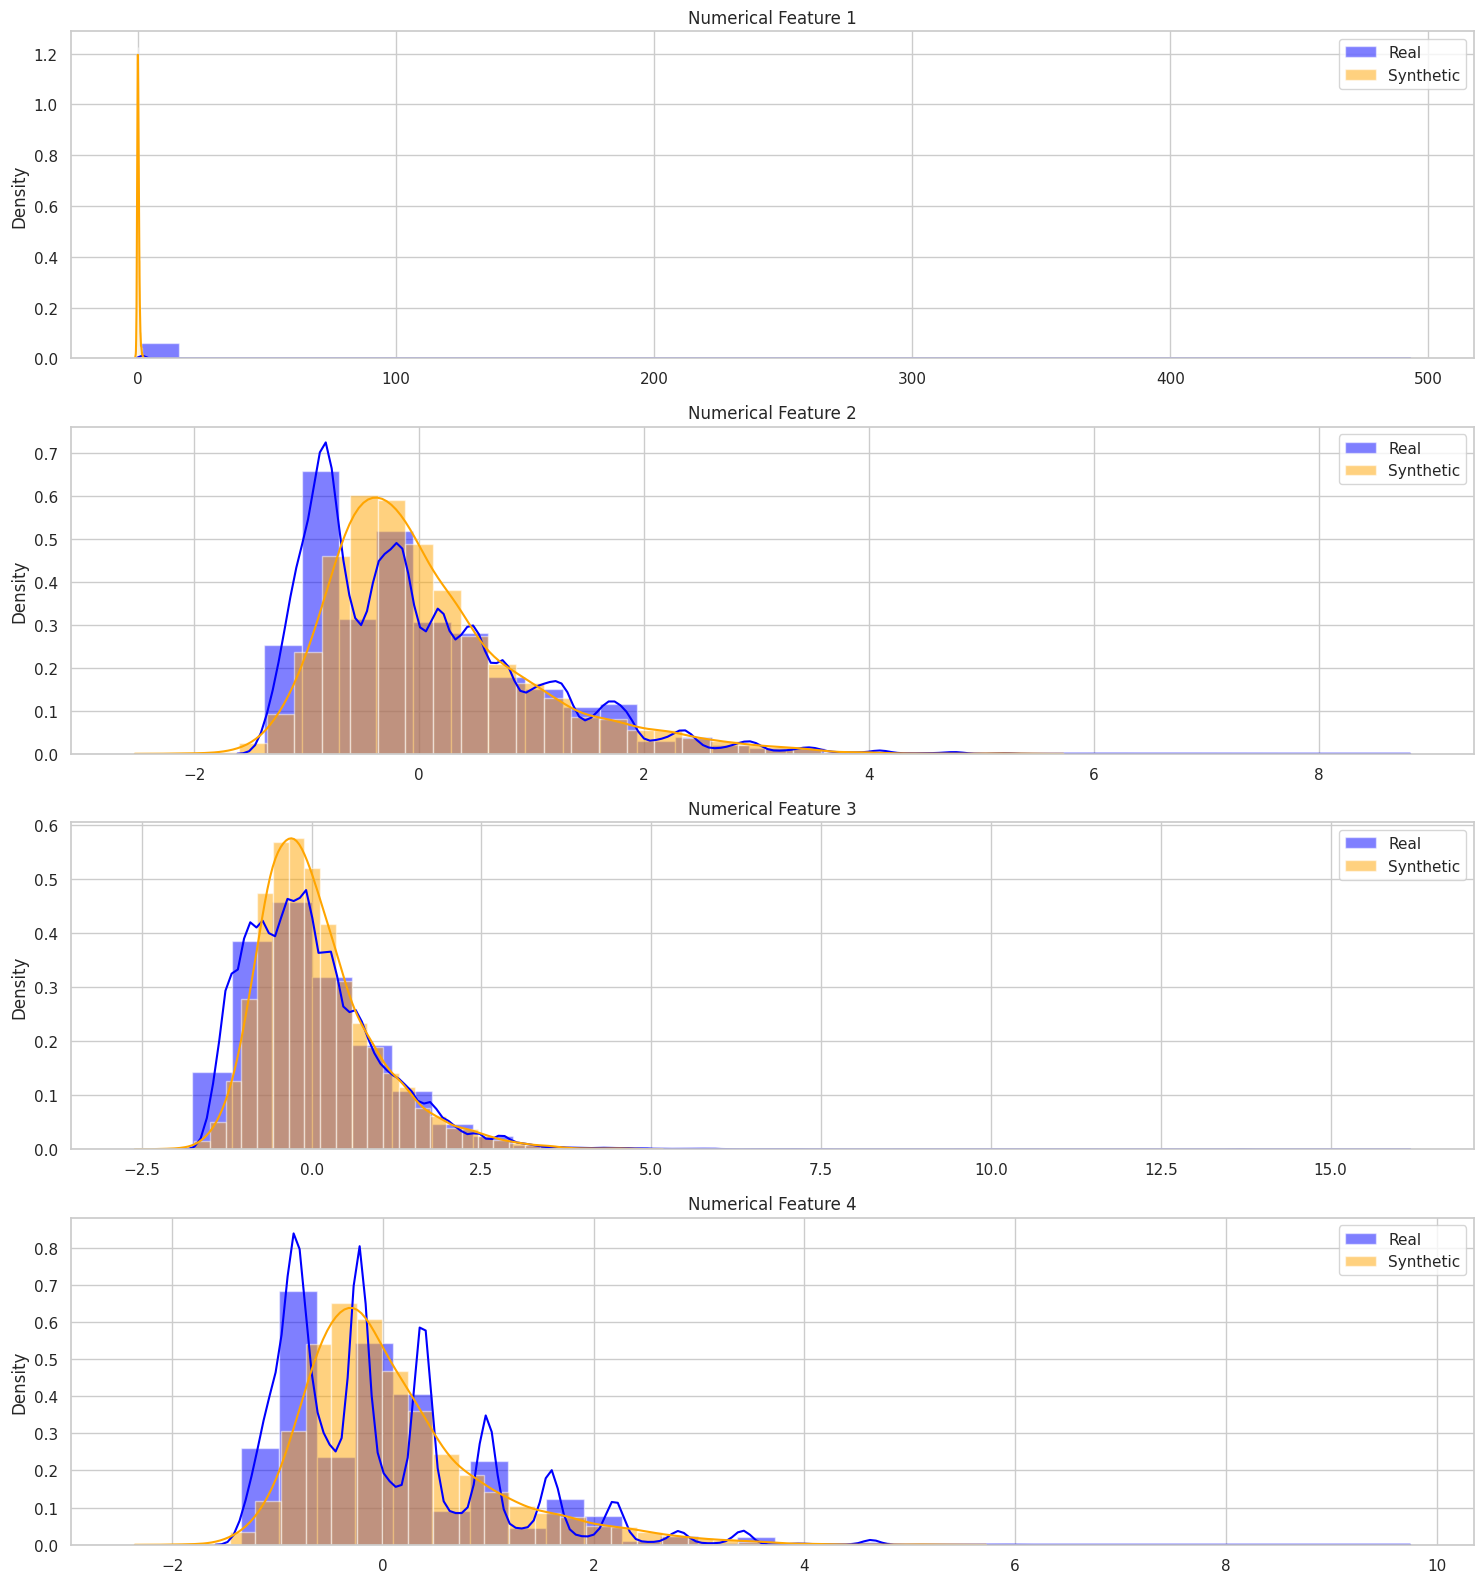

In [29]:
print("Plotting numerical distributions...")
plot_numerical_distributions(X_real_num, X_fake_num)

Plotting numerical boxplots...


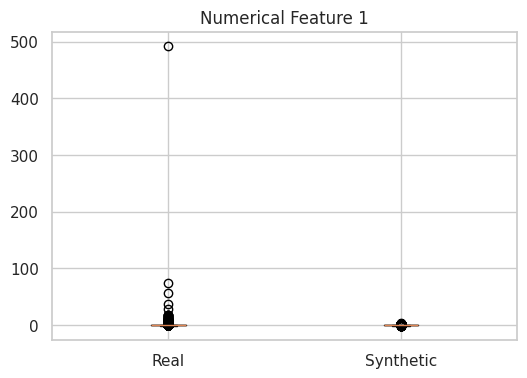

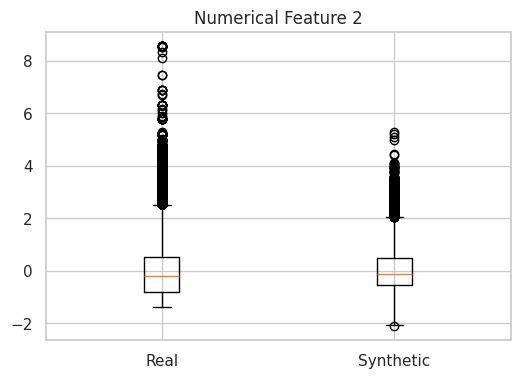

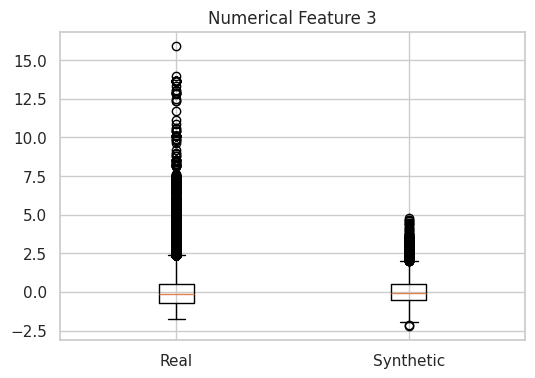

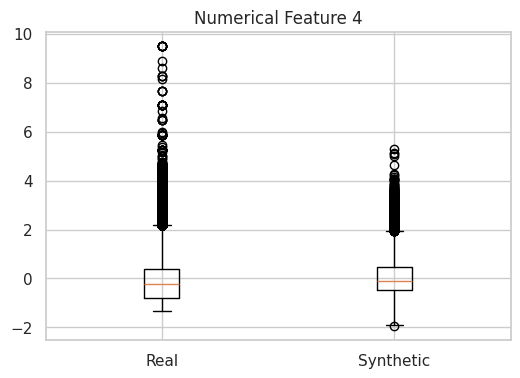

In [30]:
print("Plotting numerical boxplots...")
plot_numerical_boxplots(X_real_num, X_fake_num)

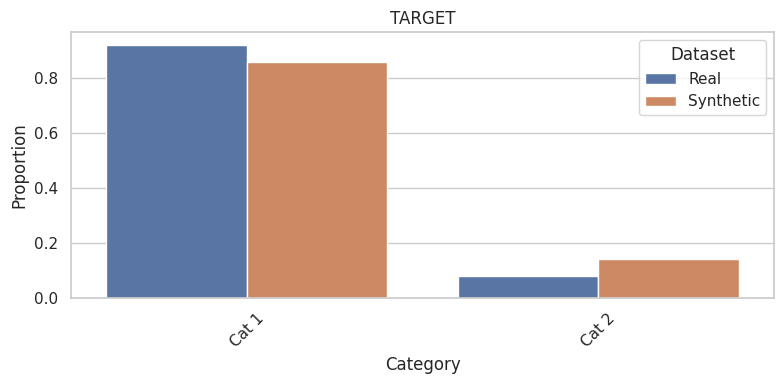

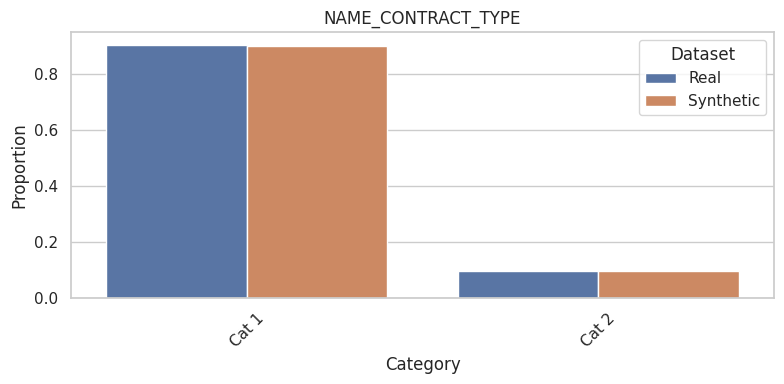

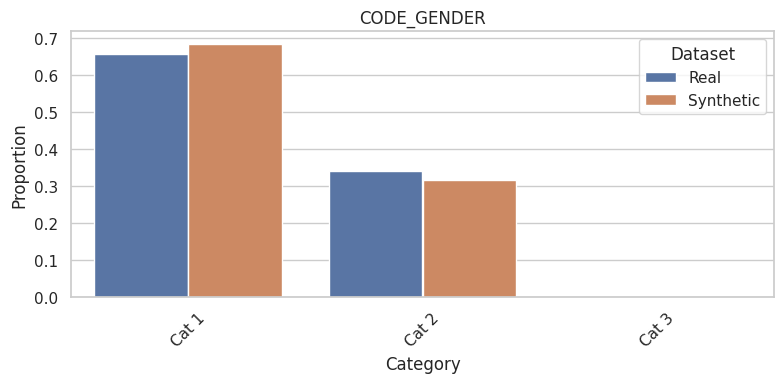

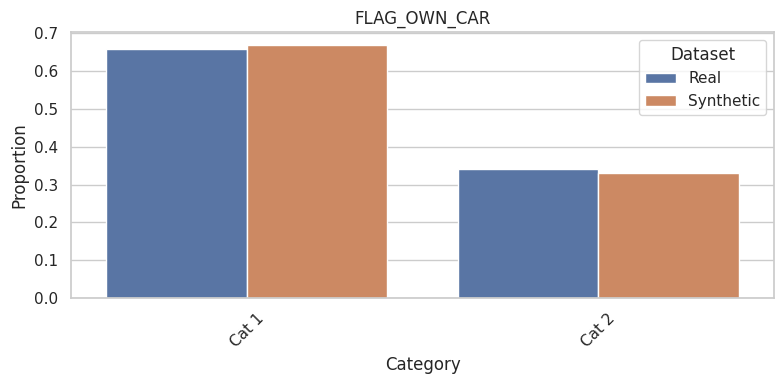

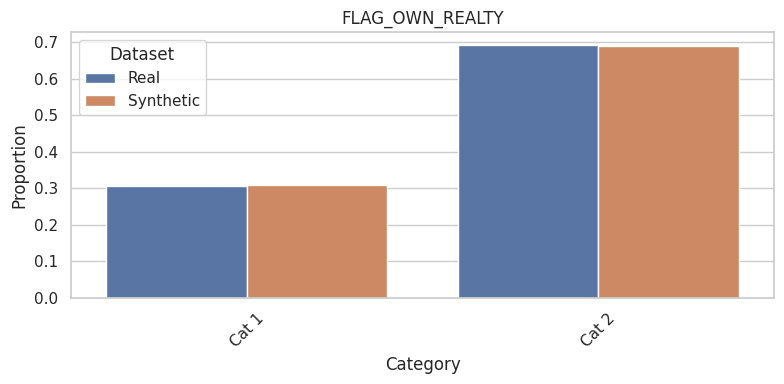

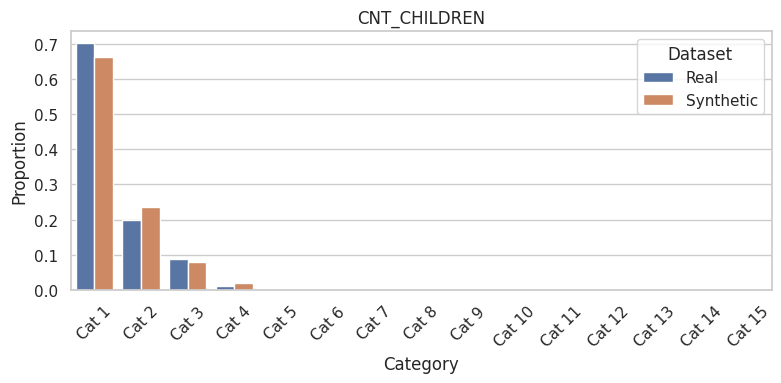

In [31]:
cat_feature_names = [
    'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
    'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN'
]


plot_categorical_frequencies(
    X_real_cat_labels,
    X_fake_cat_labels,
    cat_dims,
    cat_feature_names=cat_feature_names
)

In [33]:
#Save the real and synthetic data
np.save("real_data.npy", X)
np.save("synthetic_data.npy", cleaned_synthetic)